In [2]:
import umap
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import umap.plot
import sys
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/data/shared/software/conda/christian_fellinger/envs/GRADE/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/shared/software/conda/christian_fellinger/envs/GRADE/lib/python3.12/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/data/shared/software/conda/christian_fellinger/envs/GRADE/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings

In [5]:
def load_data(file_paths, set_names, single_file=False):
    dataframes = []
    pdb_codes = []
    if single_file:
        df = pd.read_csv(file_paths[0])
            
        df.replace("general-set","general set",inplace=True)
        df.replace("refined-set","refined set",inplace=True)
        df.replace("coreset","core set",inplace=True)
            
        pdb_codes.extend(df["PDB code"])
        df.drop("PDB code", inplace=True, axis=1)
        dataframes.append(df)
    else:
        for file_path, set_name in zip(file_paths, set_names):
            df = pd.read_csv(file_path)
            pdb_codes.extend(df["PDB code"])
            df.drop("PDB code", inplace=True, axis=1)
            df["Settype"] = set_name
            dataframes.append(df)
    return pd.concat(dataframes), pdb_codes


In [6]:

def preprocess_data(df, n_components=35):
    df_data = df.drop("Settype", inplace=False, axis=1)
    df_refined_data = df[df["Settype"] == "refined set"].drop("Settype", inplace=False, axis=1)
    
    if df_refined_data.empty:
        raise ValueError("Refined set DataFrame is empty.")
    
    scaler = StandardScaler().fit(df_refined_data)
    df_scaled = scaler.transform(df_data)
    df_scaled = np.nan_to_num(df_scaled)
    
    pca = PCA(n_components=n_components)
    df_scaled = pca.fit_transform(df_scaled)

    print("Explained Variance Ratio:", sum(pca.explained_variance_ratio_))
    
    return pd.DataFrame(df_scaled), df["Settype"]


In [7]:

def plot_umap(points_all, settype_full, title):
    points_general = points_all[settype_full == "general set"]
    points_refined = points_all[settype_full == "refined set"]
    points_core = points_all[settype_full == "core set"]
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True, constrained_layout=True)
    fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.0, hspace=0.0, wspace=0.0)
    
    # Plot all points
    axs[0, 0].scatter(points_general[:, 0], points_general[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
    axs[0, 0].scatter(points_refined[:, 0], points_refined[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
    axs[0, 0].scatter(points_core[:, 0], points_core[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
    axs[0, 0].legend(loc="best")
    
    # Plot points_core
    axs[0, 1].scatter(points_core[:, 0], points_core[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
    axs[0, 1].legend(loc="best")
    
    # Plot points_refined
    axs[1, 0].scatter(points_refined[:, 0], points_refined[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
    axs[1, 0].legend(loc="best")
    
    # Plot points_general
    axs[1, 1].scatter(points_general[:, 0], points_general[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
    axs[1, 1].legend(loc="best")
    
    for ax in axs:
        for a in ax:
            a.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    
    plt.suptitle(title)
    plt.show()


In [8]:

def run_umap(file_paths, set_names, title, single_file=False):
    if single_file:
        df, pdb_codes = load_data(file_paths, set_names, single_file)
        df_scaled, settype_full = preprocess_data(df)
        print(f"loaded {len(pdb_codes)} PDB codes.")
    else:
        df, pdb_codes = load_data(file_paths, set_names)
        df_scaled, settype_full = preprocess_data(df)
        print(f"loaded {len(pdb_codes)} PDB codes.")
    
    print("preprocessing DONE")
    
    reducer = umap.UMAP(random_state=42)
    points_all = reducer.fit_transform(df_scaled)
    
    print("UMAP training DONE")
    
    plot_umap(points_all, settype_full, title)
    
    return points_all, settype_full


Running UMAP for X-GRADE descriptors...
Explained Variance Ratio: 0.9999999999999999
loaded 19727 PDB codes.
preprocessing DONE


/data/shared/software/conda/christian_fellinger/envs/GRADE/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP training DONE


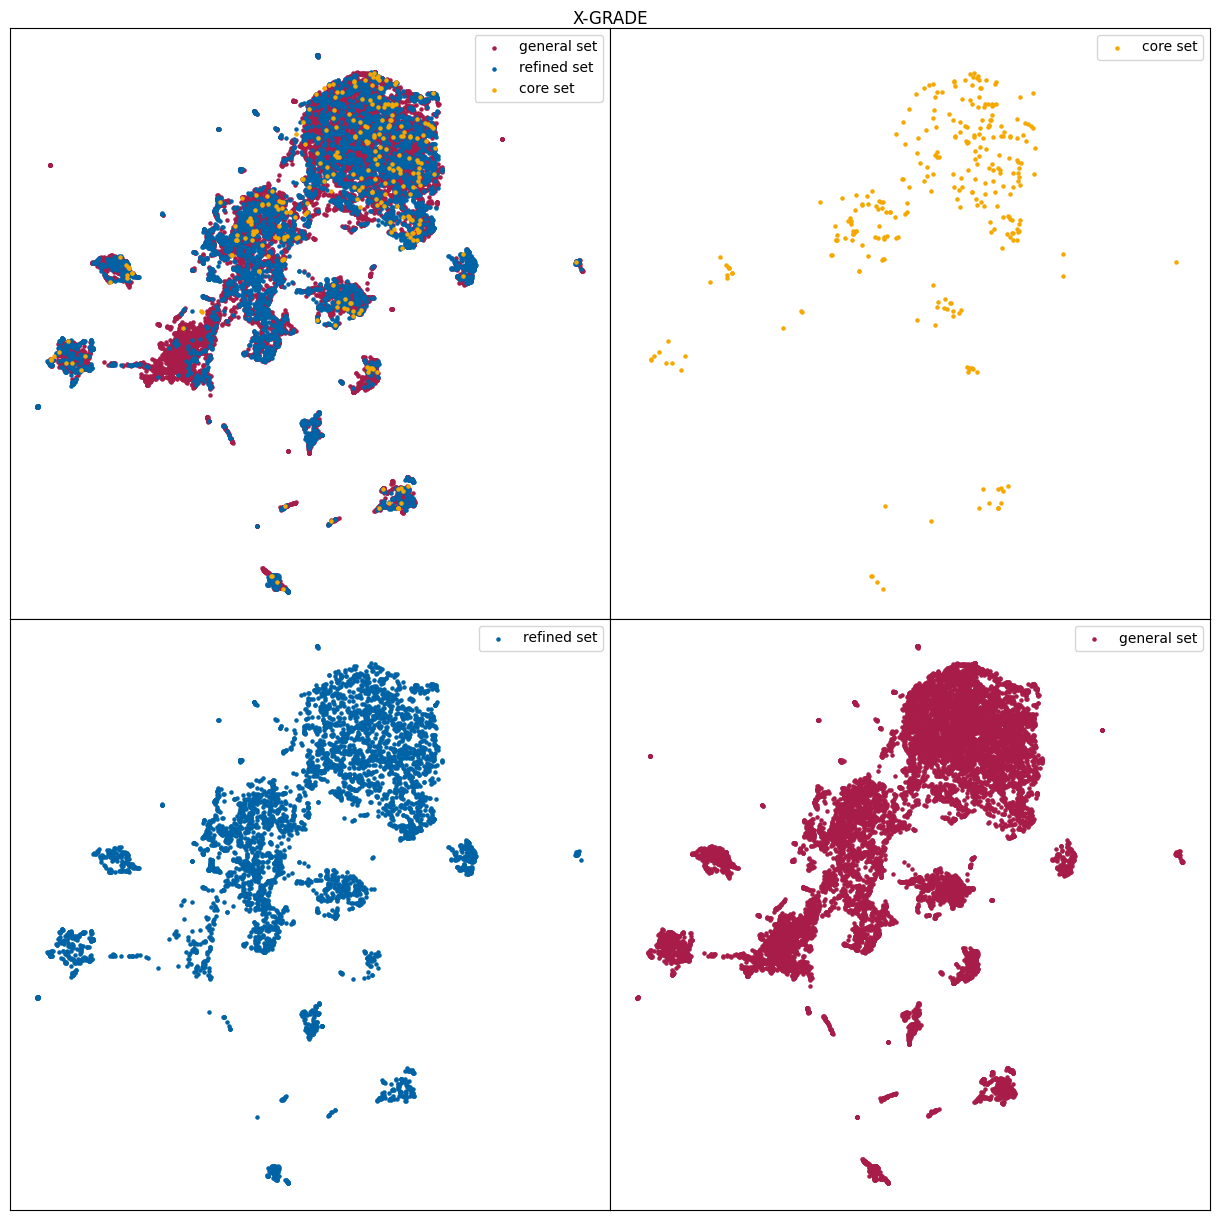

Running UMAP for GRADE descriptors...
Explained Variance Ratio: 1.0000000000000002
loaded 19727 PDB codes.
preprocessing DONE


/data/shared/software/conda/christian_fellinger/envs/GRADE/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP training DONE


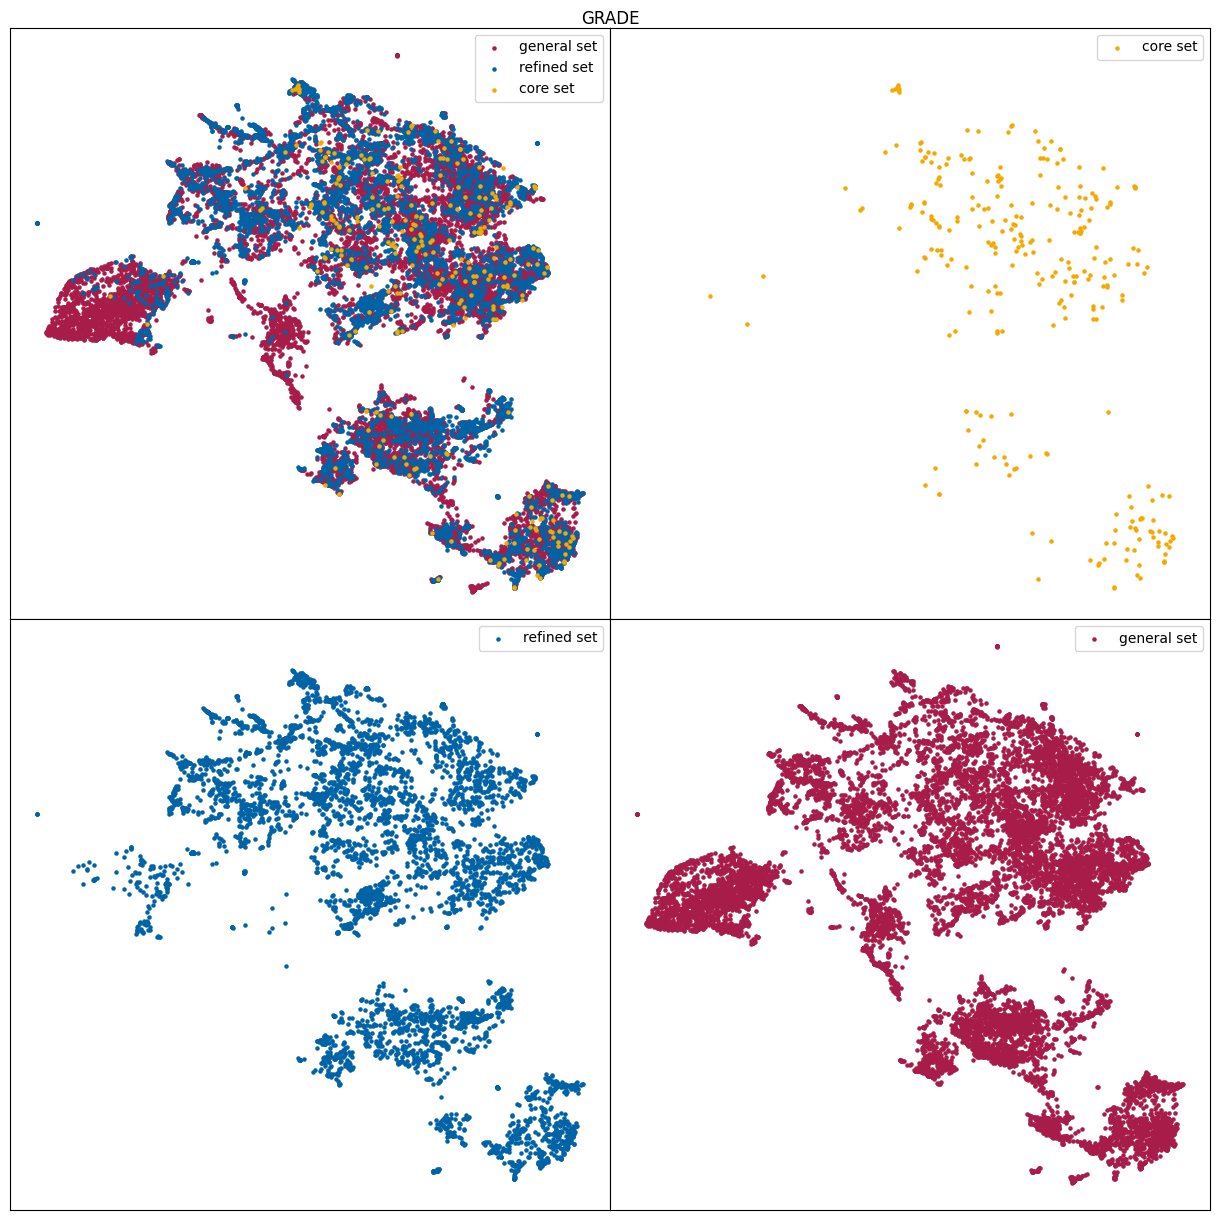

Running UMAP for DXGB descriptors...
Explained Variance Ratio: 0.9984561816880437
loaded 18619 PDB codes.
preprocessing DONE


/data/shared/software/conda/christian_fellinger/envs/GRADE/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP training DONE


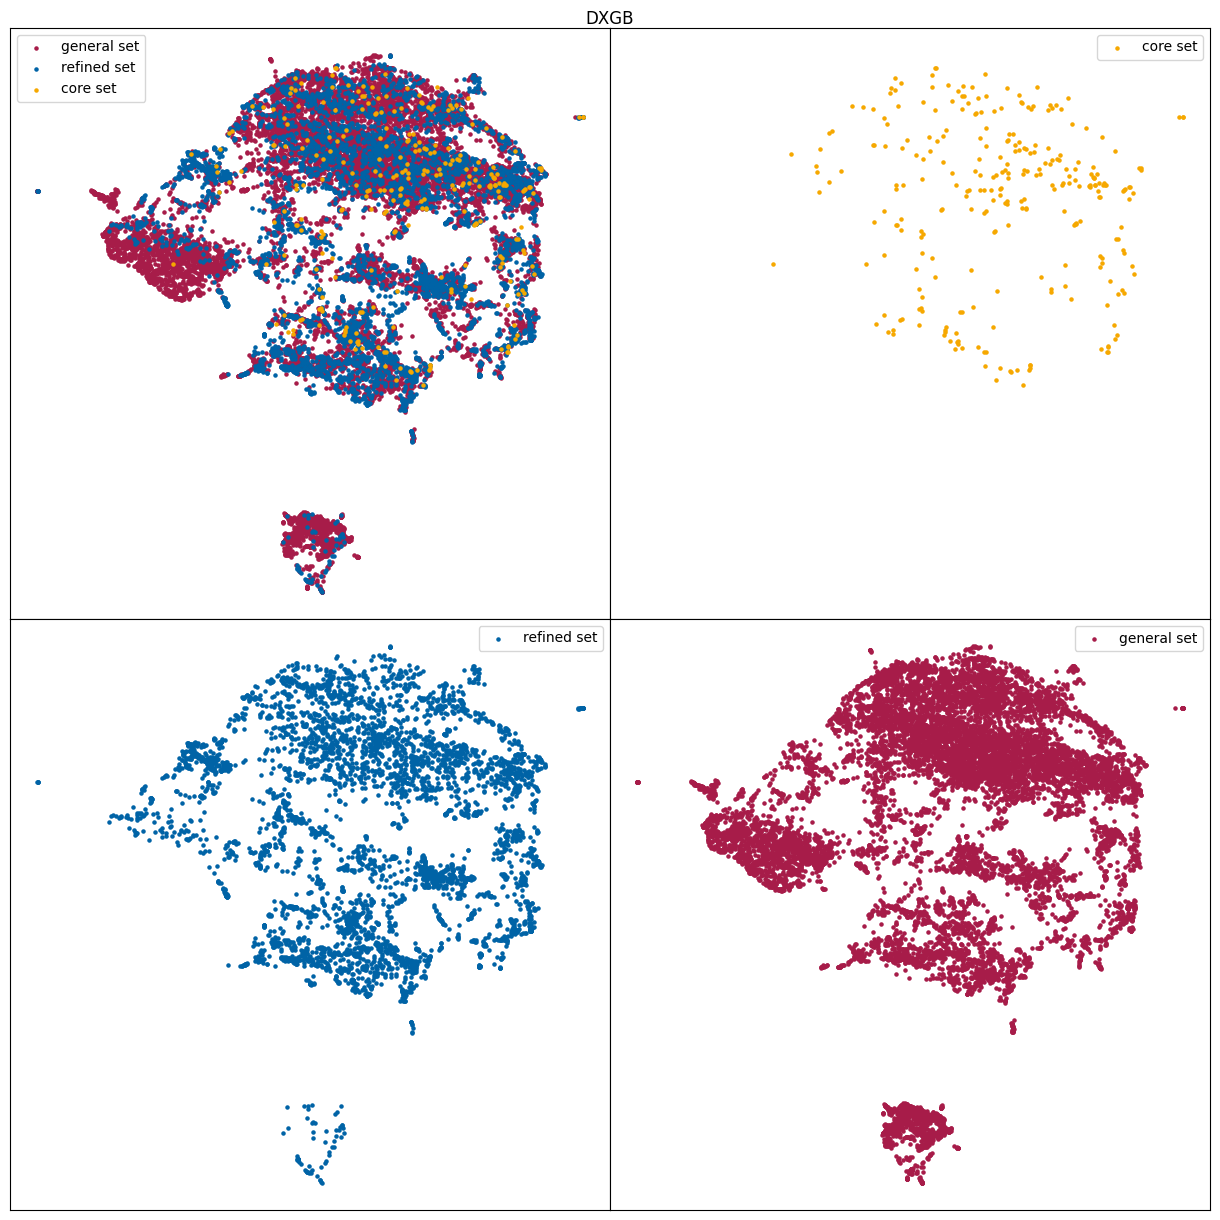

Running UMAP for ECFP descriptors...
Explained Variance Ratio: 0.20985714369396152
loaded 19728 PDB codes.
preprocessing DONE


/data/shared/software/conda/christian_fellinger/envs/GRADE/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/data/shared/software/conda/christian_fellinger/envs/GRADE/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


UMAP training DONE


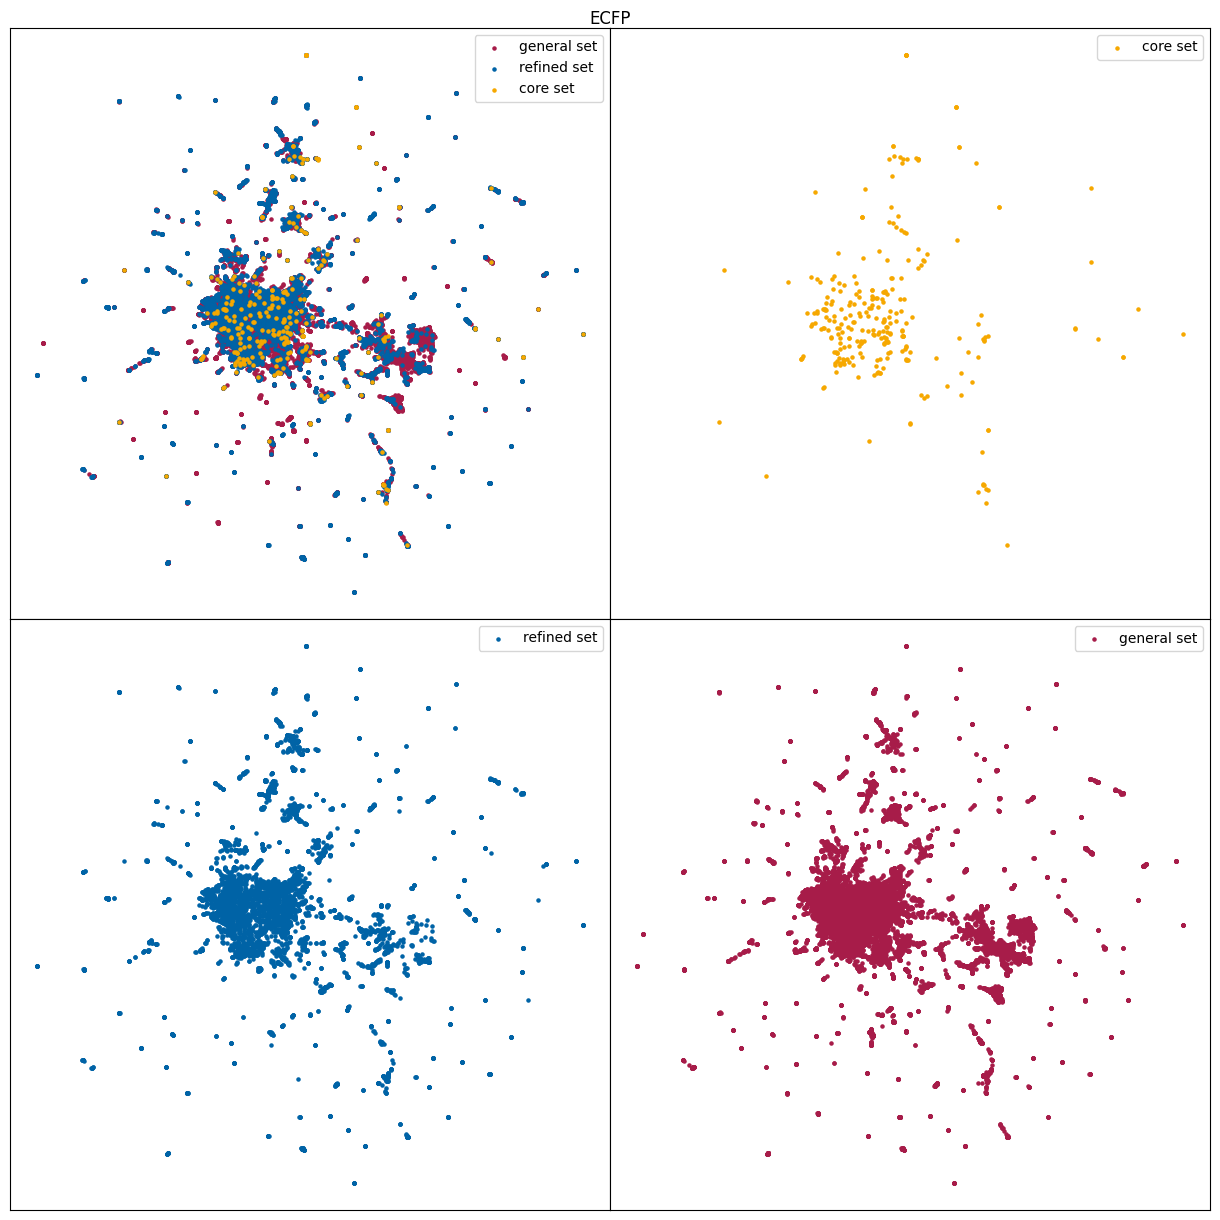

In [9]:

# Define file paths and set names
file_paths_X_GRADE = [
    "../data/Descriptors/PDBbind_general_set_X-GRADE.csv",
    "../data/Descriptors/PDBbind_refined_set_X-GRADE.csv",
    "../data/Descriptors/PDBbind_core_set_X-GRADE.csv"
]
set_names_X_GRADE = ["general set", "refined set", "core set"]

file_paths_GRADE = [
    "../data/Descriptors/PDBbind_general_set_GRADE.csv",
    "../data/Descriptors/PDBbind_refined_set_GRADE.csv",
    "../data/Descriptors/PDBbind_core_set_GRADE.csv"
]
set_names_GRADE = ["general set", "refined set", "core set"]

file_paths_DXGB = ["../data/Descriptors/PDBbind_general_set_DXGB.csv",
                   "../data/Descriptors/PDBbind_refined_set_DXGB.csv",
                   "../data/Descriptors/PDBbind_core_set_DXGB.csv"]
set_names_DXGB = ["general set", "refined set", "core set"]

file_paths_ECFPs = ["../data/Descriptors/PDBbind_general_set_ECFPs.csv",
                    "../data/Descriptors/PDBbind_refined_set_ECFPs.csv",
                    "../data/Descriptors/PDBbind_core_set_ECFPs.csv"]
set_names_ECFPs = ["general set", "refined set", "core set"]

# Run UMAP for each dataset
print("Running UMAP for X-GRADE descriptors...")
points_X_GRADE, settype_full_X_GRADE = run_umap(file_paths_X_GRADE, set_names_X_GRADE, "X-GRADE")
print("Running UMAP for GRADE descriptors...")
points_GRADE, settype_full_GRADE = run_umap(file_paths_GRADE, set_names_GRADE, "GRADE")
print("Running UMAP for DXGB descriptors...")
points_DXGB, settype_full_DXGB = run_umap(file_paths_DXGB, set_names_DXGB, "DXGB")
print("Running UMAP for ECFP descriptors...")
points_ECFPs, settype_full_ECFPs = run_umap(file_paths_ECFPs, set_names_ECFPs, "ECFP")


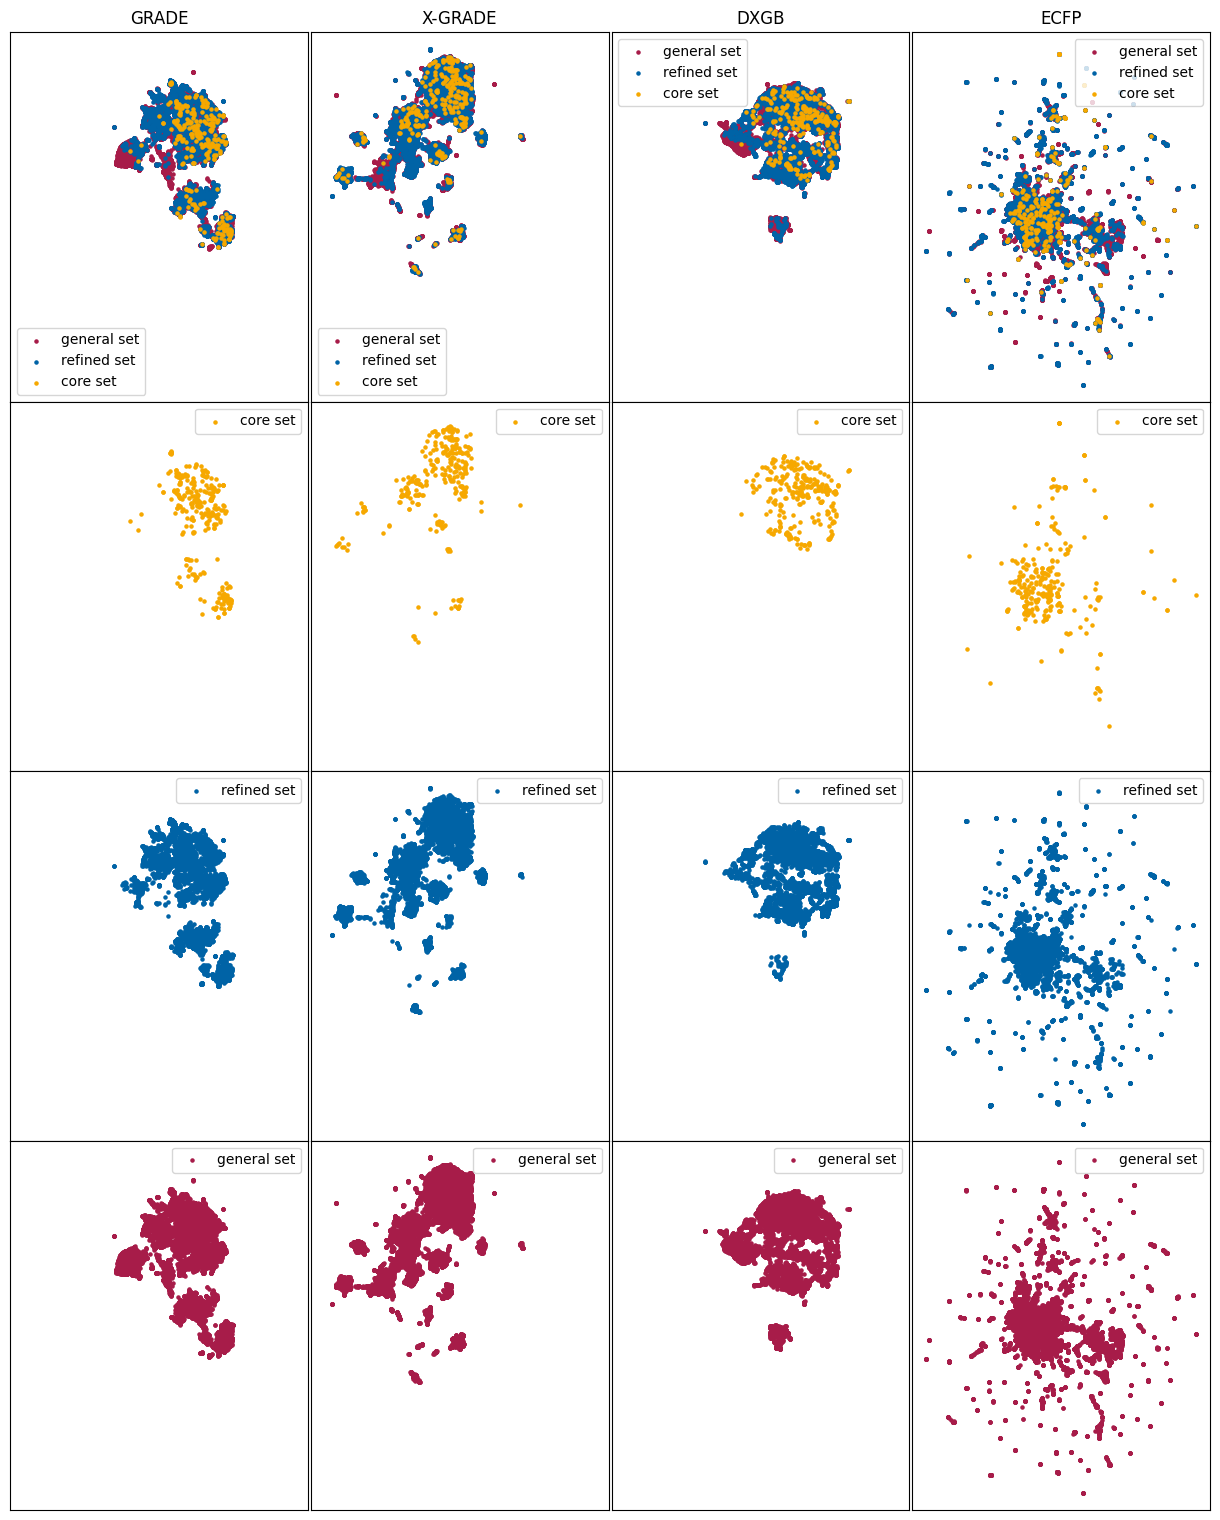

In [10]:

# Plot all UMAPs together
points_general_X_GRADE = points_X_GRADE[settype_full_X_GRADE == "general set"]
points_refined_X_GRADE = points_X_GRADE[settype_full_X_GRADE == "refined set"]
points_core_X_GRADE = points_X_GRADE[settype_full_X_GRADE == "core set"]

points_general_GRADE = points_GRADE[settype_full_GRADE == "general set"]
points_refined_GRADE = points_GRADE[settype_full_GRADE == "refined set"]
points_core_GRADE = points_GRADE[settype_full_GRADE == "core set"]

points_general_DXGB = points_DXGB[settype_full_DXGB == "general set"]
points_refined_DXGB = points_DXGB[settype_full_DXGB == "refined set"]
points_core_DXGB = points_DXGB[settype_full_DXGB == "core set"]

points_general_ECFPs = points_ECFPs[settype_full_ECFPs == "general set"]
points_refined_ECFPs = points_ECFPs[settype_full_ECFPs == "refined set"]
points_core_ECFPs = points_ECFPs[settype_full_ECFPs == "core set"]

fig, axs = plt.subplots(4, 4, figsize=(12, 15), sharex=True, sharey=True, constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0, h_pad=0.0, hspace=0.0, wspace=0.01)

# Plot all points
axs[0, 0].set_title("GRADE")
axs[0, 0].scatter(points_general_GRADE[:, 0], points_general_GRADE[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
axs[0, 0].scatter(points_refined_GRADE[:, 0], points_refined_GRADE[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
axs[0, 0].scatter(points_core_GRADE[:, 0], points_core_GRADE[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
axs[0, 0].legend(loc="best")

axs[0, 1].set_title("X-GRADE")
axs[0, 1].scatter(points_general_X_GRADE[:, 0], points_general_X_GRADE[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
axs[0, 1].scatter(points_refined_X_GRADE[:, 0], points_refined_X_GRADE[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
axs[0, 1].scatter(points_core_X_GRADE[:, 0], points_core_X_GRADE[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
axs[0, 1].legend(loc="best")

axs[0, 2].set_title("DXGB")
axs[0, 2].scatter(points_general_DXGB[:, 0], points_general_DXGB[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
axs[0, 2].scatter(points_refined_DXGB[:, 0], points_refined_DXGB[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
axs[0, 2].scatter(points_core_DXGB[:, 0], points_core_DXGB[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
axs[0, 2].legend(loc="best")

axs[0, 3].set_title("ECFP")
axs[0, 3].scatter(points_general_ECFPs[:, 0], points_general_ECFPs[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
axs[0, 3].scatter(points_refined_ECFPs[:, 0], points_refined_ECFPs[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
axs[0, 3].scatter(points_core_ECFPs[:, 0], points_core_ECFPs[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
axs[0, 3].legend(loc="best")

# Plot points_core
axs[1, 0].scatter(points_core_GRADE[:, 0], points_core_GRADE[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
axs[1, 0].legend(loc="best")

axs[1, 1].scatter(points_core_X_GRADE[:, 0], points_core_X_GRADE[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
axs[1, 1].legend(loc="best")

axs[1, 2].scatter(points_core_DXGB[:, 0], points_core_DXGB[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
axs[1, 2].legend(loc="best")

axs[1, 3].scatter(points_core_ECFPs[:, 0], points_core_ECFPs[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
axs[1, 3].legend(loc="best")

# Plot points_refined
axs[2, 0].scatter(points_refined_GRADE[:, 0], points_refined_GRADE[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
axs[2, 0].legend(loc="best")

axs[2, 1].scatter(points_refined_X_GRADE[:, 0], points_refined_X_GRADE[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
axs[2, 1].legend(loc="best")

axs[2, 2].scatter(points_refined_DXGB[:, 0], points_refined_DXGB[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
axs[2, 2].legend(loc="best")

axs[2, 3].scatter(points_refined_ECFPs[:, 0], points_refined_ECFPs[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
axs[2, 3].legend(loc="best")

# Plot points_general
axs[3, 0].scatter(points_general_GRADE[:, 0], points_general_GRADE[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
axs[3, 0].legend(loc="best")

axs[3, 1].scatter(points_general_X_GRADE[:, 0], points_general_X_GRADE[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
axs[3, 1].legend(loc="best")

axs[3, 2].scatter(points_general_DXGB[:, 0], points_general_DXGB[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
axs[3, 2].legend(loc="best")

axs[3, 3].scatter(points_general_ECFPs[:, 0], points_general_ECFPs[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
axs[3, 3].legend(loc="best")

for ax in axs:
    for a in ax:
        a.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

plt.show()

---------------------------------------------
Aligned UMAP

---------------------------------------------

In [11]:
# Aligned UMAP
file_paths_X_GRADE = [
    "../data/Descriptors/PDBbind_general_set_X-GRADE.csv",
    "../data/Descriptors/PDBbind_refined_set_X-GRADE.csv",
    "../data/Descriptors/PDBbind_core_set_X-GRADE.csv"
]
set_names_X_GRADE = ["general set", "refined set", "core set"]

file_paths_GRADE = [
    "../data/Descriptors/PDBbind_general_set_GRADE.csv",
    "../data/Descriptors/PDBbind_refined_set_GRADE.csv",
    "../data/Descriptors/PDBbind_core_set_GRADE.csv"
]
set_names_GRADE = ["general set", "refined set", "core set"]

file_paths_DXGB = ["../data/Descriptors/PDBbind_general_set_DXGB.csv",
    "../data/Descriptors/PDBbind_refined_set_DXGB.csv",
    "../data/Descriptors/PDBbind_core_set_DXGB.csv"
]
set_names_DXGB = ["general set", "refined set", "core set"]

df_X_GRADE_all, pdb_codes_X_GRADE_all = load_data(file_paths_X_GRADE, set_names_X_GRADE)
print("X-GRADE:")
df_scaled_X_GRADE_all, settype_full_X_GRADE = preprocess_data(df_X_GRADE_all)

df_GRADE_all, pdb_codes_GRADE_all = load_data(file_paths_GRADE, set_names_GRADE)
print("GRADE:")
df_scaled_GRADE_all, settype_full_GRADE = preprocess_data(df_GRADE_all)

df_DXGB_all, pdb_codes_DXGB_all = load_data(file_paths_DXGB, set_names_DXGB)
print("DXGB:")
df_scaled_DXGB_all, settype_full_DXGB = preprocess_data(df_DXGB_all)

relations = []

index_map = {val: idx for idx, val in enumerate(pdb_codes_X_GRADE_all)}
relations_GRADE_all_X_GRADE_all = {i: index_map[val] for i, val in enumerate(pdb_codes_GRADE_all) if val in index_map}
index_map = {val: idx for idx, val in enumerate(pdb_codes_DXGB_all)}
relations_X_GRADE_all_DXGB_all = {i: index_map[val] for i, val in enumerate(pdb_codes_X_GRADE_all) if val in index_map}


relations.append(relations_GRADE_all_X_GRADE_all)
relations.append(relations_X_GRADE_all_DXGB_all)

data = [df_scaled_GRADE_all, df_scaled_X_GRADE_all, df_scaled_DXGB_all]
aligned_mapper = umap.AlignedUMAP().fit(data, relations=relations)

def axis_bounds(embedding):
    left, right = embedding.T[0].min(), embedding.T[0].max()
    bottom, top = embedding.T[1].min(), embedding.T[1].max()
    adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]


X-GRADE:
Explained Variance Ratio: 0.9999999999999999
GRADE:
Explained Variance Ratio: 1.0000000000000002
DXGB:
Explained Variance Ratio: 0.9984561816880437


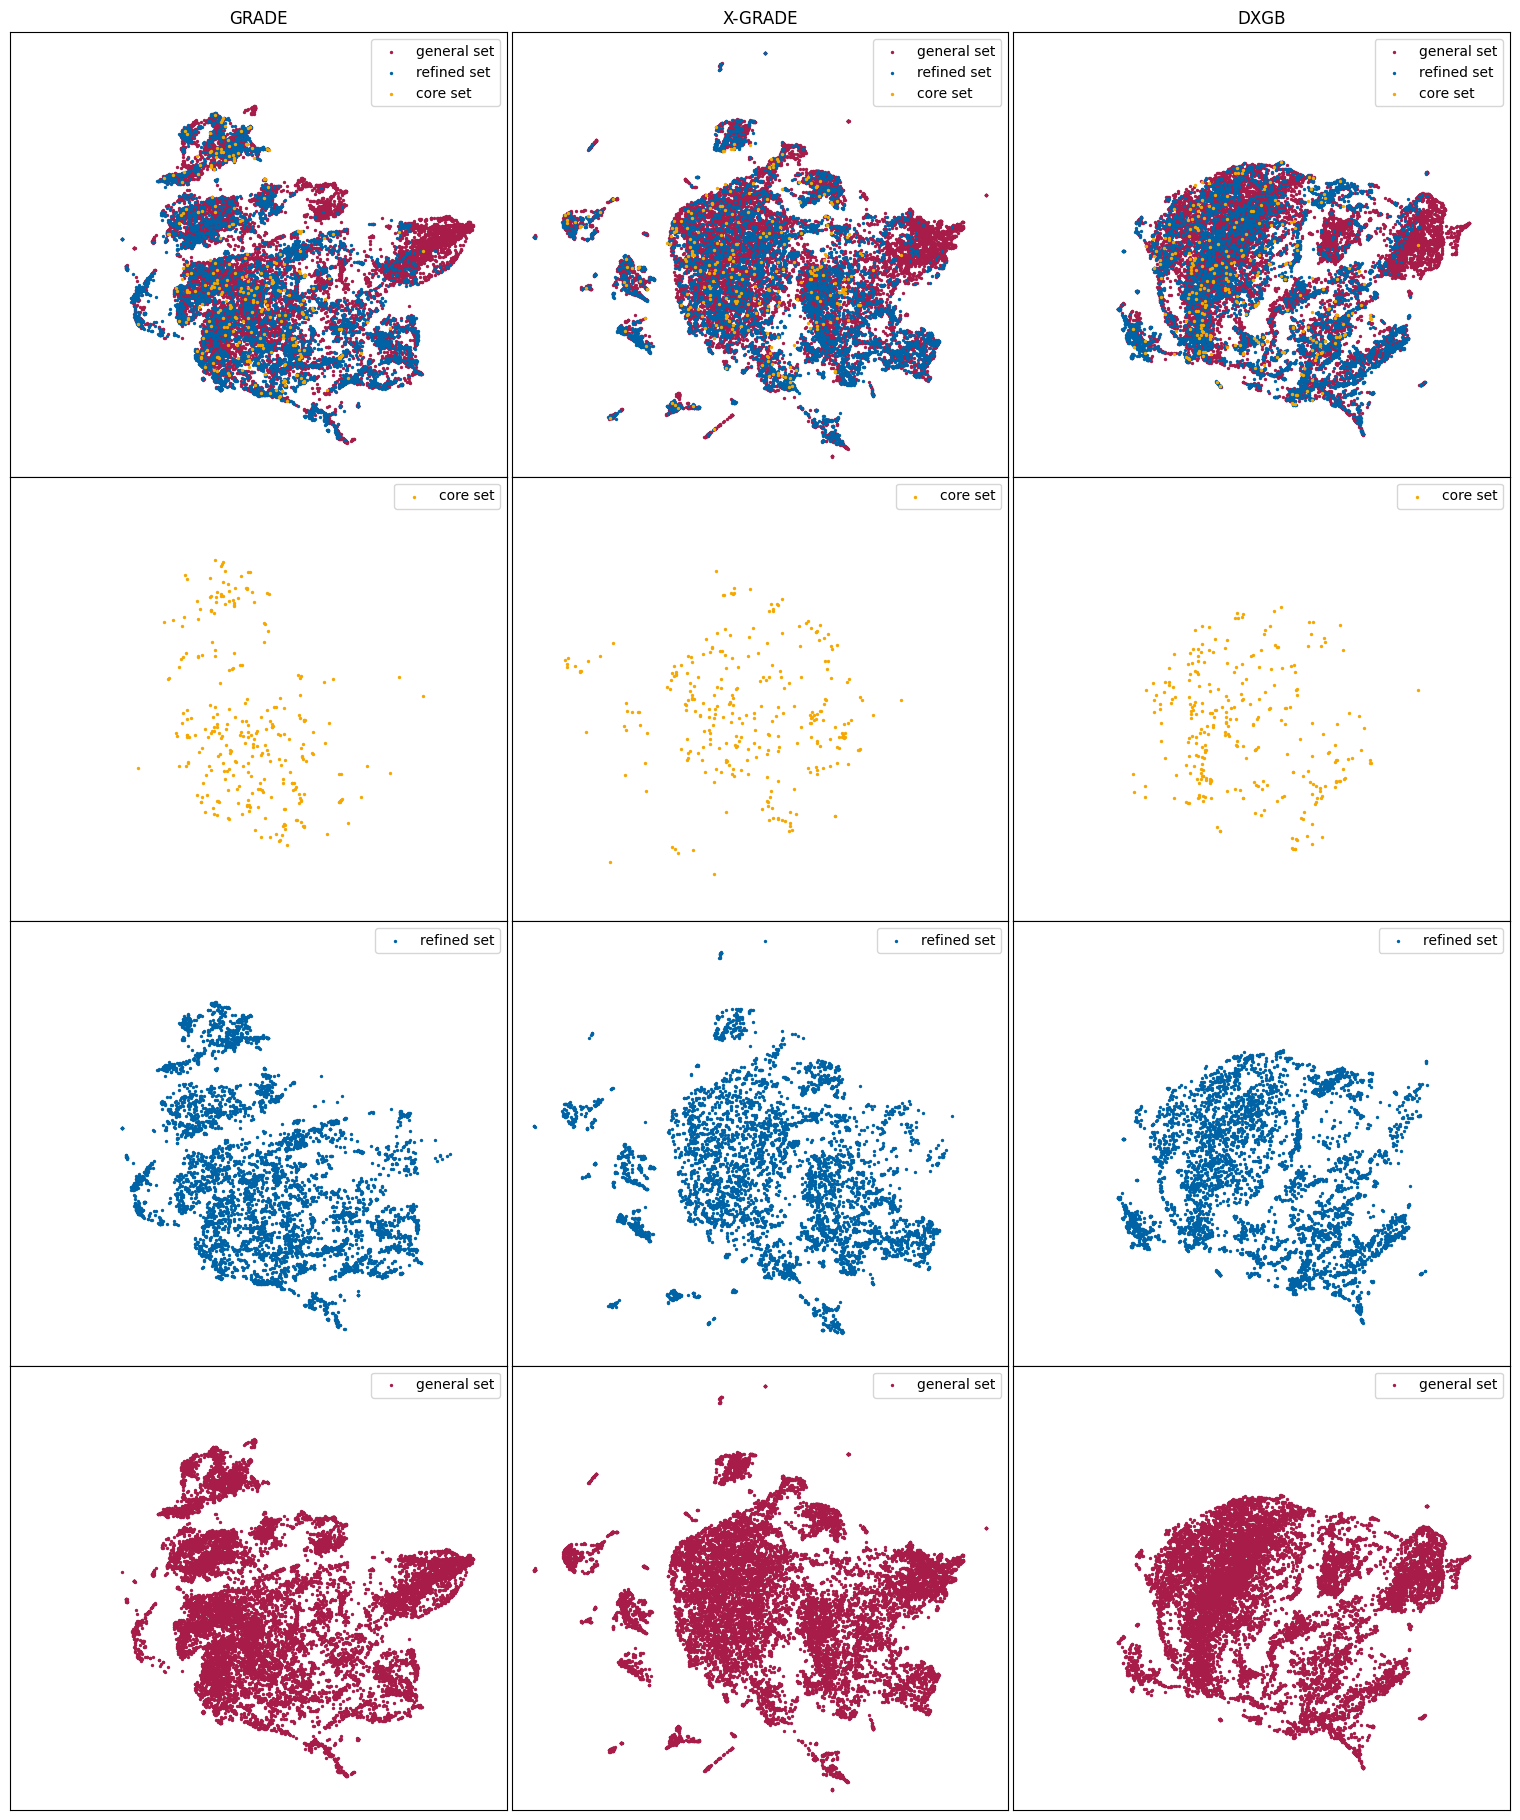

In [12]:
fig, axs = plt.subplots(4,3, figsize=(15,18), sharex=True, sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.0, hspace=0.0, wspace=0.01)
        

for i, ax in enumerate(axs.flatten()):
    if i == 0:
        ax.set_title("GRADE")
        ax.scatter(*aligned_mapper.embeddings_[i][settype_full_GRADE == "general set"].T, s=2, color="#A71C49",label="general set")
        ax.scatter(*aligned_mapper.embeddings_[i][settype_full_GRADE == "refined set"].T, s=2, color="#0063A6",label="refined set")
        ax.scatter(*aligned_mapper.embeddings_[i][settype_full_GRADE == "core set"].T, s=2, color="#F6A800",label="core set")
        ax.legend(loc="best")
    elif i == 1:
        ax.set_title("X-GRADE")
        ax.scatter(*aligned_mapper.embeddings_[i][settype_full_X_GRADE == "general set"].T, s=2, color="#A71C49",label="general set")
        ax.scatter(*aligned_mapper.embeddings_[i][settype_full_X_GRADE == "refined set"].T, s=2, color="#0063A6",label="refined set")
        ax.scatter(*aligned_mapper.embeddings_[i][settype_full_X_GRADE == "core set"].T, s=2, color="#F6A800",label="core set")
        ax.legend(loc="best")
    elif i == 2:
        ax.set_title("DXGB")
        ax.scatter(*aligned_mapper.embeddings_[i][settype_full_DXGB == "general set"].T, s=2, color="#A71C49",label="general set")
        ax.scatter(*aligned_mapper.embeddings_[i][settype_full_DXGB == "refined set"].T, s=2, color="#0063A6",label="refined set")
        ax.scatter(*aligned_mapper.embeddings_[i][settype_full_DXGB == "core set"].T, s=2, color="#F6A800",label="core set")
        ax.legend(loc="best")
    elif i == 3:
        ax.scatter(*aligned_mapper.embeddings_[0][settype_full_GRADE == "core set"].T, s=2, color="#F6A800",label="core set")
        ax.legend(loc="best")
    elif i == 4:
        ax.scatter(*aligned_mapper.embeddings_[1][settype_full_X_GRADE == "core set"].T, s=2, color="#F6A800",label="core set")
        ax.legend(loc="best")
    elif i == 5:
        ax.scatter(*aligned_mapper.embeddings_[2][settype_full_DXGB == "core set"].T, s=2, color="#F6A800",label="core set")
        ax.legend(loc="best")
    elif i == 6:
        ax.scatter(*aligned_mapper.embeddings_[0][settype_full_GRADE == "refined set"].T, s=2, color="#0063A6",label="refined set")
        ax.legend(loc="best")
    elif i == 7:
        ax.scatter(*aligned_mapper.embeddings_[1][settype_full_X_GRADE == "refined set"].T, s=2, color="#0063A6",label="refined set")
        ax.legend(loc="best")
    elif i == 8:
        ax.scatter(*aligned_mapper.embeddings_[2][settype_full_DXGB == "refined set"].T, s=2, color="#0063A6",label="refined set")
        ax.legend(loc="best")
    elif i == 9:
        ax.scatter(*aligned_mapper.embeddings_[0][settype_full_GRADE == "general set"].T, s=2, color="#A71C49",label="general set")
        ax.legend(loc="best")
    elif i == 10:
        ax.scatter(*aligned_mapper.embeddings_[1][settype_full_X_GRADE == "general set"].T, s=2, color="#A71C49",label="general set")
        ax.legend(loc="best")
    elif i == 11:
        ax.scatter(*aligned_mapper.embeddings_[2][settype_full_DXGB == "general set"].T, s=2, color="#A71C49",label="general set")
        ax.legend(loc="best")
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.show()

NameError: name 'aligned_mapper' is not defined

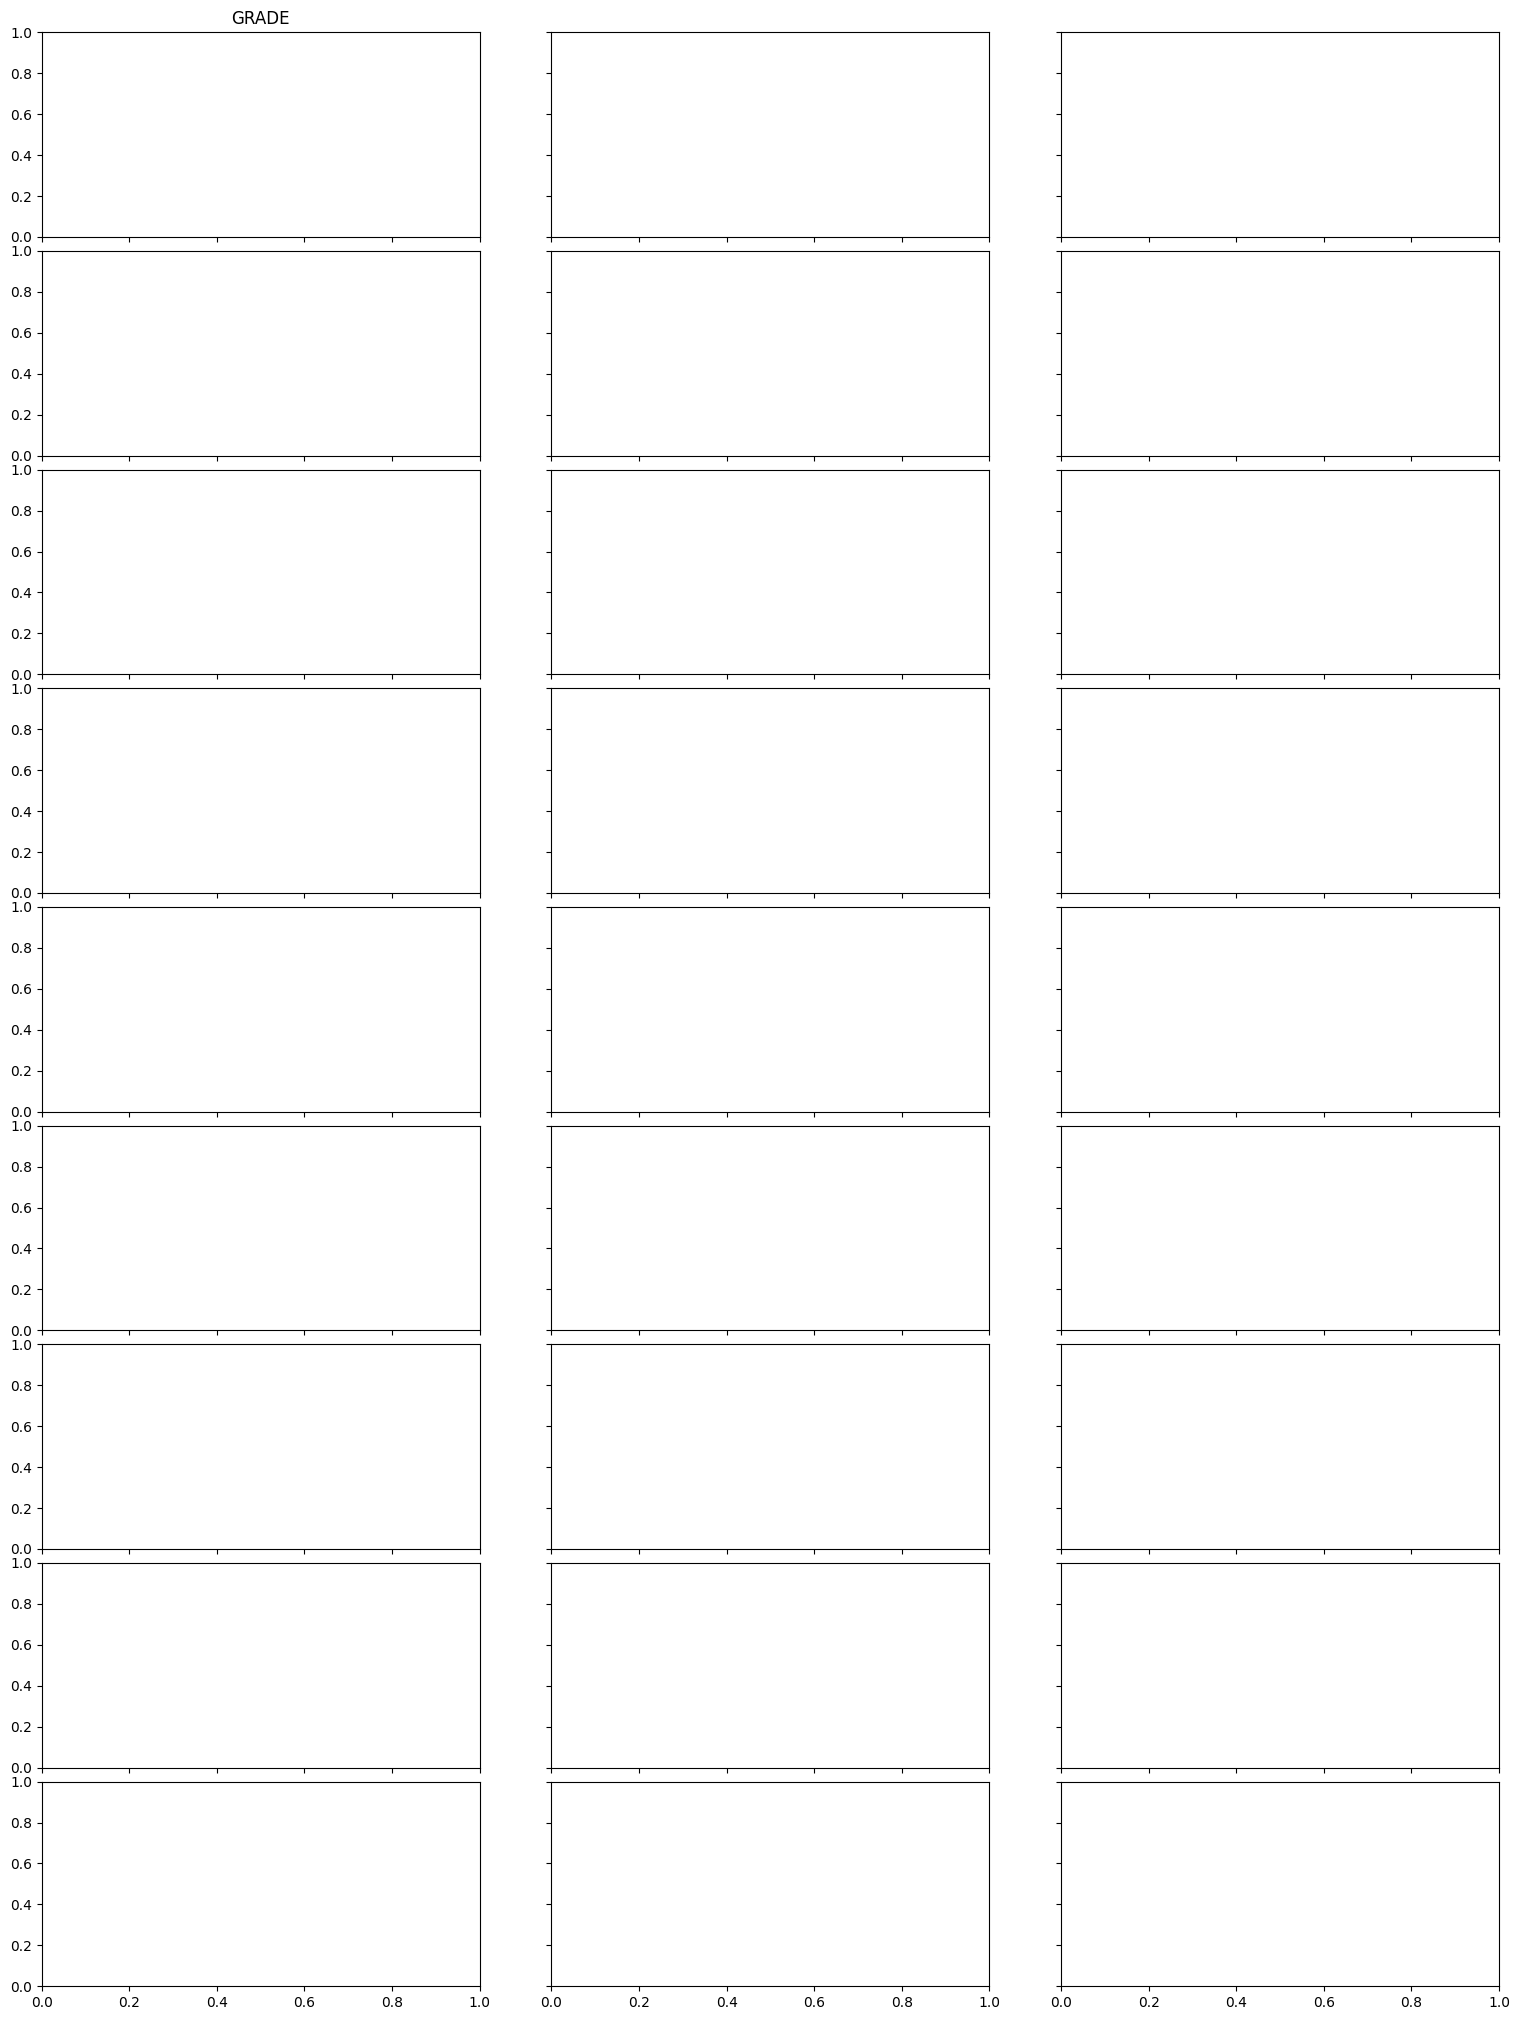

In [3]:
def assign_ec_numbers(descriptor_paths, ec_paths):
    """
    Assign EC numbers to PDB codes based on matching with EC number files.

    Parameters:
        descriptor_paths (list of str): Paths to descriptor CSV files.
        ec_paths (list of str): Paths to EC number CSV files (1_x_x_x.csv, 2_x_x_x.csv, etc.).

    Returns:
        pd.Series: A pandas Series with assigned EC numbers for each PDB code.
    """
    # Load and concatenate descriptor files
    dataframes = [pd.read_csv(path) for path in descriptor_paths]
    df = pd.concat(dataframes)
    
    # Load EC number files into a list of DataFrames
    ec_dataframes = [pd.read_csv(path) for path in ec_paths]
    
    # Create a list to store EC number assignments
    lst = []

    # Assign EC numbers based on PDB code matches
    for pdb in df["PDB code"]:
        assigned = 0  # Default to 0 if no match is found
        for ec_number, ec_df in enumerate(ec_dataframes, start=1):
            if pdb in ec_df["PDB code"].values:
                assigned = ec_number
                break
        lst.append(assigned)
    
    # Convert the list to a pandas Series
    return pd.Series(lst, name="EC_number")

# Example Usage
X_GRADE_paths = [
    "../data/Descriptors/PDBbind_general_set_X-GRADE.csv",
    "../data/Descriptors/PDBbind_refined_set_X-GRADE.csv",
    "../data/Descriptors/PDBbind_core_set_X-GRADE.csv",
]

GRADE_paths = [
    "../data/Descriptors/PDBbind_general_set_GRADE.csv",
    "../data/Descriptors/PDBbind_refined_set_GRADE.csv",
    "../data/Descriptors/PDBbind_core_set_GRADE.csv",
]

DXGB_paths = [
    "../data/Descriptors/PDBbind_general_set_DXGB.csv",
    "../data/Descriptors/PDBbind_refined_set_DXGB.csv",
    "../data/Descriptors/PDBbind_core_set_DXGB.csv",
]

ec_paths = [
    "../data/exp_data/EC_numbers/1_x_x_x.csv",
    "../data/exp_data/EC_numbers/2_x_x_x.csv",
    "../data/exp_data/EC_numbers/3_x_x_x.csv",
    "../data/exp_data/EC_numbers/4_x_x_x.csv",
    "../data/exp_data/EC_numbers/5_x_x_x.csv",
    "../data/exp_data/EC_numbers/6_x_x_x.csv",
    "../data/exp_data/EC_numbers/7_x_x_x.csv",
]

lst_X_GRADE = assign_ec_numbers(X_GRADE_paths, ec_paths)
lst_GRADE = assign_ec_numbers(GRADE_paths, ec_paths)
lst_DXGB = assign_ec_numbers(DXGB_paths, ec_paths)


fig, axs = plt.subplots(9,3, figsize=(15,20), sharex=True, sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.0, hspace=0.0, wspace=0.1)

for i, ax in enumerate(axs.flatten()):
    if i == 0:
        ax.set_title("GRADE")
        ax.scatter(*aligned_mapper.embeddings_[i][lst_GRADE == 0].T, s=2, color="#666666",label=0)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_GRADE == 1].T, s=2, color="#0063A6",label=1)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_GRADE == 2].T, s=2, color="#A71C49",label=2)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_GRADE == 3].T, s=2, color="#DD4814",label=3)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_GRADE == 4].T, s=2, color="#F6A800",label=4)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_GRADE == 5].T, s=2, color="#94C154",label=5)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_GRADE == 6].T, s=2, color="#11897A",label=6)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_GRADE == 7].T, s=2, color="#4B51A1",label=7)
        ax.legend(loc="best")
    elif i == 1:
        ax.set_title("X-GRADE")
        ax.scatter(*aligned_mapper.embeddings_[i][lst_X_GRADE == 0].T, s=2, color="#666666",label=0)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_X_GRADE == 1].T, s=2, color="#0063A6",label=1)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_X_GRADE == 2].T, s=2, color="#A71C49",label=2)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_X_GRADE == 3].T, s=2, color="#DD4814",label=3)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_X_GRADE == 4].T, s=2, color="#F6A800",label=4)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_X_GRADE == 5].T, s=2, color="#94C154",label=5)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_X_GRADE == 6].T, s=2, color="#11897A",label=6)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_X_GRADE == 7].T, s=2, color="#4B51A1",label=7)
        ax.legend(loc="best")
    elif i == 2:
        ax.set_title("DXGB")
        ax.scatter(*aligned_mapper.embeddings_[i][lst_DXGB == 0].T, s=2, color="#666666",label=0)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_DXGB == 1].T, s=2, color="#0063A6",label=1)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_DXGB == 2].T, s=2, color="#A71C49",label=2)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_DXGB == 3].T, s=2, color="#DD4814",label=3)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_DXGB == 4].T, s=2, color="#F6A800",label=4)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_DXGB == 5].T, s=2, color="#94C154",label=5)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_DXGB == 6].T, s=2, color="#11897A",label=6)
        ax.scatter(*aligned_mapper.embeddings_[i][lst_DXGB == 7].T, s=2, color="#4B51A1",label=7)
        ax.legend(loc="best")
    elif i == 3:
        ax.scatter(*aligned_mapper.embeddings_[0][lst_GRADE == 0].T, s=2, color="#666666",label=0)
        ax.legend(loc="best")
    elif i == 4:
        ax.scatter(*aligned_mapper.embeddings_[1][lst_X_GRADE == 0].T, s=2, color="#666666",label=0)
        ax.legend(loc="best")
    elif i == 5:
        ax.scatter(*aligned_mapper.embeddings_[2][lst_DXGB == 0].T, s=2, color="#666666",label=0)
        ax.legend(loc="best")
    elif i == 6:
        ax.scatter(*aligned_mapper.embeddings_[0][lst_GRADE == 1].T, s=2, color="#0063A6",label=1)
        ax.legend(loc="best")
    elif i == 7:
        ax.scatter(*aligned_mapper.embeddings_[1][lst_X_GRADE == 1].T, s=2, color="#0063A6",label=1)
        ax.legend(loc="best")
    elif i == 8:
        ax.scatter(*aligned_mapper.embeddings_[2][lst_DXGB == 1].T, s=2, color="#0063A6",label=1)
        ax.legend(loc="best")
    elif i == 9:
        ax.scatter(*aligned_mapper.embeddings_[0][lst_GRADE == 2].T, s=2, color="#A71C49",label=2)
        ax.legend(loc="best")
    elif i == 10:
        ax.scatter(*aligned_mapper.embeddings_[1][lst_X_GRADE == 2].T, s=2, color="#A71C49",label=2)
        ax.legend(loc="best")
    elif i == 11:
        ax.scatter(*aligned_mapper.embeddings_[2][lst_DXGB == 2].T, s=2, color="#A71C49",label=2)
        ax.legend(loc="best")
    elif i == 12:
        ax.scatter(*aligned_mapper.embeddings_[0][lst_GRADE == 3].T, s=2, color="#DD4814",label=3)
        ax.legend(loc="best")
    elif i == 13:
        ax.scatter(*aligned_mapper.embeddings_[1][lst_X_GRADE == 3].T, s=2, color="#DD4814",label=3)
        ax.legend(loc="best")
    elif i == 14:
        ax.scatter(*aligned_mapper.embeddings_[2][lst_DXGB == 3].T, s=2, color="#DD4814",label=3)
        ax.legend(loc="best")
    elif i == 15:
        ax.scatter(*aligned_mapper.embeddings_[0][lst_GRADE == 4].T, s=2, color="#F6A800",label=4)
        ax.legend(loc="best")
    elif i == 16:
        ax.scatter(*aligned_mapper.embeddings_[1][lst_X_GRADE == 4].T, s=2, color="#F6A800",label=4)
        ax.legend(loc="best")
    elif i == 17:
        ax.scatter(*aligned_mapper.embeddings_[2][lst_DXGB == 4].T, s=2, color="#F6A800",label=4)
        ax.legend(loc="best")
    elif i == 18:
        ax.scatter(*aligned_mapper.embeddings_[0][lst_GRADE == 5].T, s=2, color="#94C154",label=5)
        ax.legend(loc="best")
    elif i == 19:
        ax.scatter(*aligned_mapper.embeddings_[1][lst_X_GRADE == 5].T, s=2, color="#94C154",label=5)
        ax.legend(loc="best")
    elif i == 20:
        ax.scatter(*aligned_mapper.embeddings_[2][lst_DXGB == 5].T, s=2, color="#94C154",label=5)
        ax.legend(loc="best")
    elif i == 21:
        ax.scatter(*aligned_mapper.embeddings_[0][lst_GRADE == 6].T, s=2, color="#11897A",label=6)
        ax.legend(loc="best")
    elif i == 22:
        ax.scatter(*aligned_mapper.embeddings_[1][lst_X_GRADE == 6].T, s=2, color="#11897A",label=6)
        ax.legend(loc="best")
    elif i == 23:
        ax.scatter(*aligned_mapper.embeddings_[2][lst_DXGB == 6].T, s=2, color="#11897A",label=6)
        ax.legend(loc="best")
    elif i == 24:
        ax.scatter(*aligned_mapper.embeddings_[0][lst_GRADE == 7].T, s=2, color="#4B51A1",label=7)
        ax.legend(loc="best")
    elif i == 25:
        ax.scatter(*aligned_mapper.embeddings_[1][lst_X_GRADE == 7].T, s=2, color="#4B51A1",label=7)
        ax.legend(loc="best")
    elif i == 26:
        ax.scatter(*aligned_mapper.embeddings_[2][lst_DXGB == 7].T, s=2, color="#4B51A1",label=7)
        ax.legend(loc="best")
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.show()

preprocessing DONE


/data/shared/software/conda/christian_fellinger/envs/GRADE/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(19727, 2) (8141, 2) (460, 2) (4718, 2) (4914, 2) (772, 2) (295, 2) (426, 2) (1, 2)
UMAP training DONE


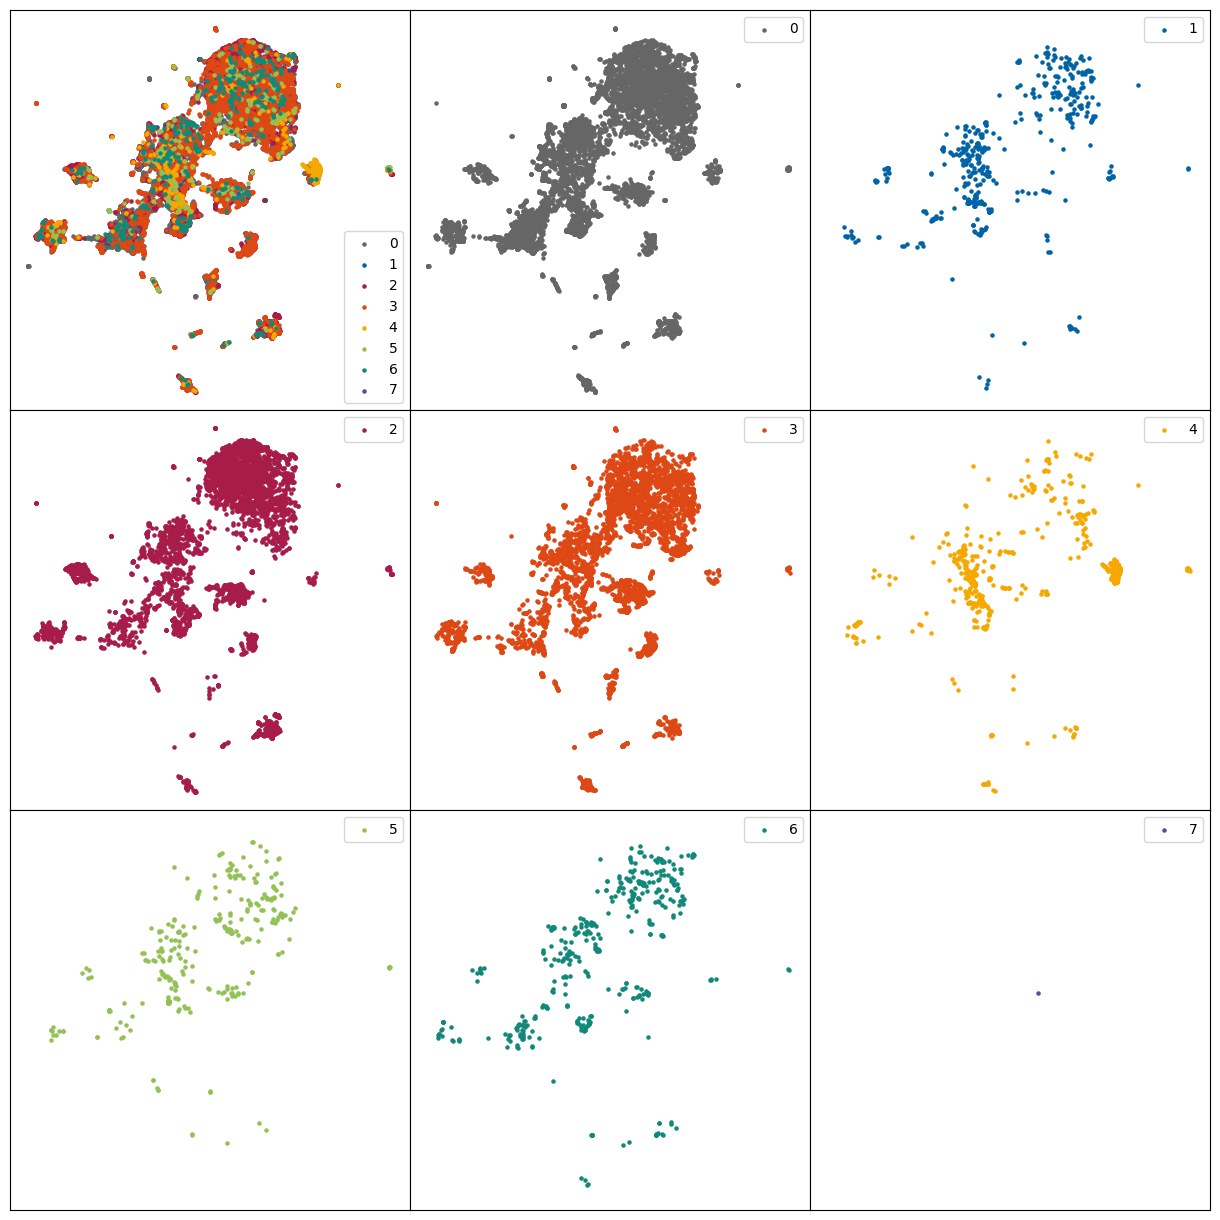

In [28]:
df_general = pd.read_csv("../data/Descriptors/PDBbind_general_set_X-GRADE.csv")
df_refined = pd.read_csv("../data/Descriptors/PDBbind_refined_set_X-GRADE.csv")
df_core = pd.read_csv("../data/Descriptors/PDBbind_core_set_X-GRADE.csv")

dataframes = [df_general,df_refined,df_core]
df = pd.concat(dataframes)

df_1 = pd.read_csv("../data/exp_data/EC_numbers/1_x_x_x.csv")
df_2 = pd.read_csv("../data/exp_data/EC_numbers/2_x_x_x.csv")
df_3 = pd.read_csv("../data/exp_data/EC_numbers/3_x_x_x.csv")
df_4 = pd.read_csv("../data/exp_data/EC_numbers/4_x_x_x.csv")
df_5 = pd.read_csv("../data/exp_data/EC_numbers/5_x_x_x.csv")
df_6 = pd.read_csv("../data/exp_data/EC_numbers/6_x_x_x.csv")
df_7 = pd.read_csv("../data/exp_data/EC_numbers/7_x_x_x.csv")

lst = []

for pdb in df["PDB code"]:
    if pdb in df_1["PDB code"].values:
        lst.append(1)
    elif pdb in df_2["PDB code"].values:
        lst.append(2)
    elif pdb in df_3["PDB code"].values:
        lst.append(3)
    elif pdb in df_4["PDB code"].values:
        lst.append(4)
    elif pdb in df_5["PDB code"].values:
        lst.append(5)
    elif pdb in df_6["PDB code"].values:
        lst.append(6)
    elif pdb in df_7["PDB code"].values:
        lst.append(7)
    else:
        lst.append(0)

df["Class"] = lst

df.drop("PDB code",inplace=True, axis=1)

df_data = df.drop("Class",inplace=False,axis=1)

df_refined_data = df_refined.drop("PDB code",inplace=False,axis=1)
scaler = StandardScaler().fit(df_refined_data)

df_scaled = scaler.transform(df_data)

df_scaled = np.nan_to_num(df_scaled)

pca = PCA(n_components=35)
df_scaled = pca.fit_transform(df_scaled)

print("preprocessing DONE")

reducer =umap.UMAP(random_state=42)

reducer = reducer.fit(df_scaled)
points_all = reducer.fit_transform(df_scaled)
points_0 = points_all[df.Class == 0]
points_1 = points_all[df.Class == 1]
points_2 = points_all[df.Class == 2]
points_3 = points_all[df.Class == 3]
points_4 = points_all[df.Class == 4]
points_5 = points_all[df.Class == 5]
points_6 = points_all[df.Class == 6]
points_7 = points_all[df.Class == 7]
print(points_all.shape,points_0.shape,points_1.shape,points_2.shape,points_3.shape,points_4.shape,points_5.shape,points_6.shape,points_7.shape)
print("UMAP training DONE")

fig, axs = plt.subplots(3, 3, figsize=(12, 12),sharex=True,sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.0, hspace=0.0, wspace=0.0)

# Plot all points
axs[0, 0].scatter(points_0[:, 0], points_0[:, 1], s=5, label="0", color="#666666", alpha=1)
axs[0, 0].scatter(points_1[:, 0], points_1[:, 1], s=5, label="1", color="#0063A6", alpha=1)
axs[0, 0].scatter(points_2[:, 0], points_2[:, 1], s=5, label="2", color="#A71C49", alpha=1)
axs[0, 0].scatter(points_3[:, 0], points_3[:, 1], s=5, label="3", color="#DD4814", alpha=1)
axs[0, 0].scatter(points_4[:, 0], points_4[:, 1], s=5, label="4", color="#F6A800", alpha=1)
axs[0, 0].scatter(points_5[:, 0], points_5[:, 1], s=5, label="5", color="#94C154", alpha=1)
axs[0, 0].scatter(points_6[:, 0], points_6[:, 1], s=5, label="6", color="#11897A", alpha=1)
axs[0, 0].scatter(points_7[:, 0], points_7[:, 1], s=5, label="7", color="#4B51A1", alpha=1)
axs[0, 0].legend(loc="best")

# Plot points_0
axs[0, 1].scatter(points_0[:, 0], points_0[:, 1], s=5, label="0", color="#666666", alpha=1)
axs[0, 1].legend(loc="best")

# Plot points_1
axs[0, 2].scatter(points_1[:, 0], points_1[:, 1], s=5, label="1", color="#0063A6", alpha=1)
axs[0, 2].legend(loc="best")

# Plot points_2
axs[1, 0].scatter(points_2[:, 0], points_2[:, 1], s=5, label="2", color="#A71C49", alpha=1)
axs[1, 0].legend(loc="best")

# Plot points_3
axs[1, 1].scatter(points_3[:, 0], points_3[:, 1], s=5, label="3", color="#DD4814", alpha=1)
axs[1, 1].legend(loc="best")

# Plot points_4
axs[1, 2].scatter(points_4[:, 0], points_4[:, 1], s=5, label="4", color="#F6A800", alpha=1)
axs[1, 2].legend(loc="best")

# Plot points_5
axs[2, 0].scatter(points_5[:, 0], points_5[:, 1], s=5, label="5", color="#94C154", alpha=1)
axs[2, 0].legend(loc="best")

# Plot points_6
axs[2, 1].scatter(points_6[:, 0], points_6[:, 1], s=5, label="6", color="#11897A", alpha=1)
axs[2, 1].legend(loc="best")

# Plot points_7
axs[2, 2].scatter(points_7[:, 0], points_7[:, 1], s=5, label="7", color="#4B51A1", alpha=1)
axs[2, 2].legend(loc="best")

for ax in axs:
    for a in ax:
        a.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        
plt.show()

preprocessing DONE


/data/shared/software/conda/christian_fellinger/envs/GRADE/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(19727, 2) (8141, 2) (460, 2) (4718, 2) (4914, 2) (772, 2) (295, 2) (426, 2) (1, 2)
UMAP training DONE


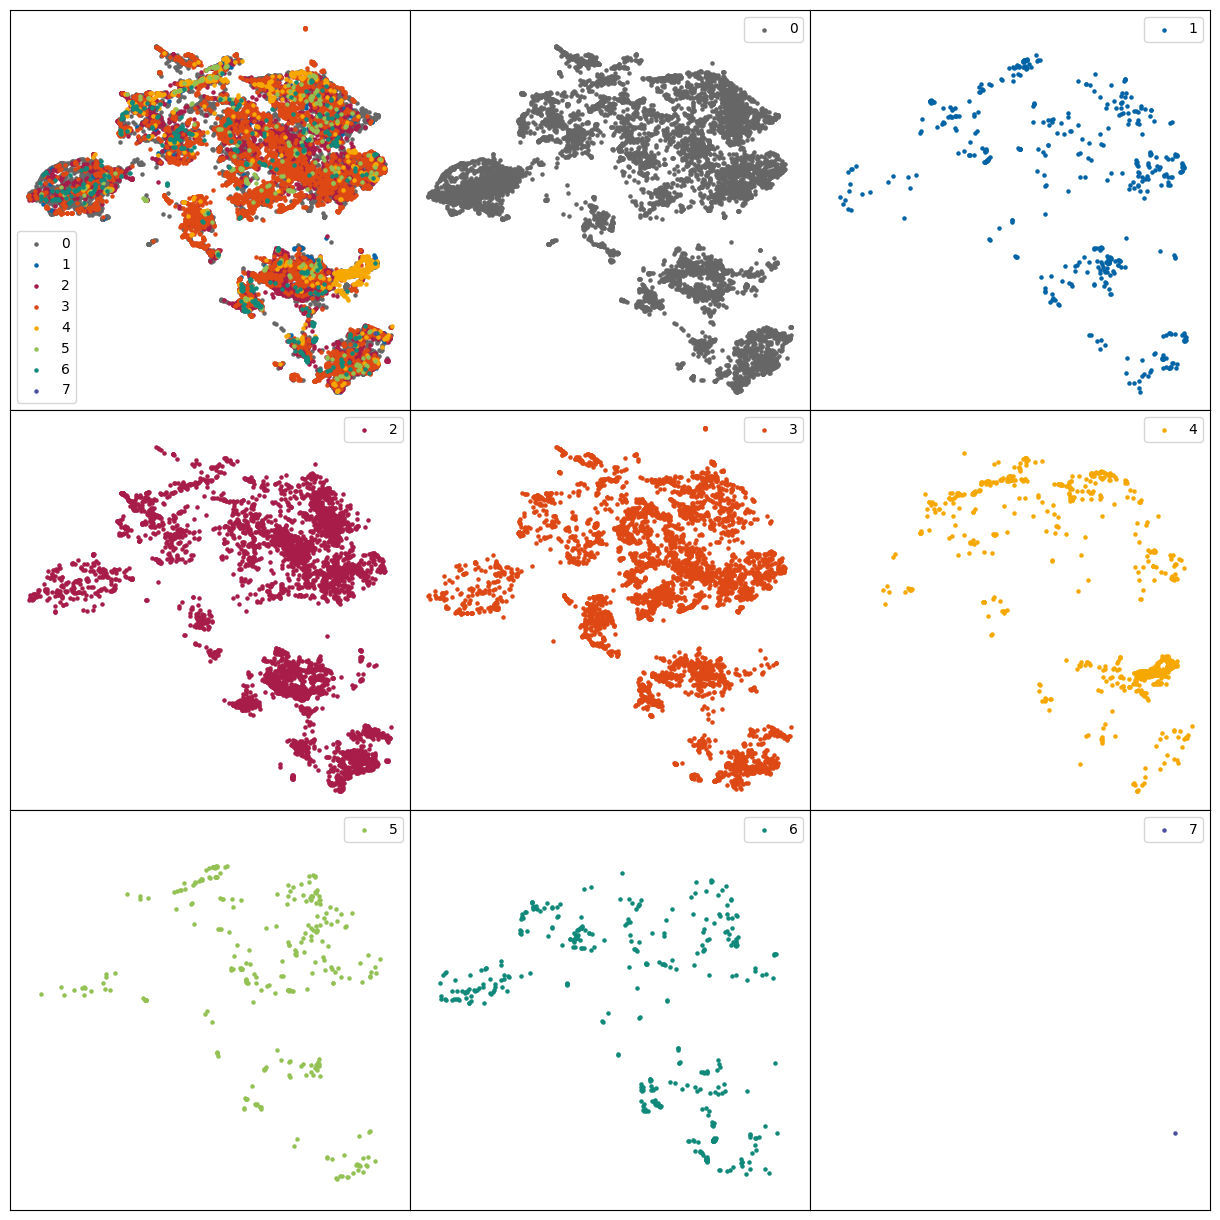

In [29]:
df_general = pd.read_csv("../data/Descriptors/PDBbind_general_set_GRADE.csv")
df_refined = pd.read_csv("/data/shared/projects/pharmacophore_hot_spot_analysis/GAP/data/ref_set_descrs.csv")
df_core = pd.read_csv("/data/shared/projects/pharmacophore_hot_spot_analysis/GAP/data/core_set_descrs.csv")

dataframes = [df_general,df_refined,df_core]
df = pd.concat(dataframes)

df_1 = pd.read_csv("../data/exp_data/EC_numbers/1_x_x_x.csv")
df_2 = pd.read_csv("../data/exp_data/EC_numbers/2_x_x_x.csv")
df_3 = pd.read_csv("../data/exp_data/EC_numbers/3_x_x_x.csv")
df_4 = pd.read_csv("../data/exp_data/EC_numbers/4_x_x_x.csv")
df_5 = pd.read_csv("../data/exp_data/EC_numbers/5_x_x_x.csv")
df_6 = pd.read_csv("../data/exp_data/EC_numbers/6_x_x_x.csv")
df_7 = pd.read_csv("../data/exp_data/EC_numbers/7_x_x_x.csv")

lst = []

for pdb in df["PDB code"]:
    if pdb in df_1["PDB code"].values:
        lst.append(1)
    elif pdb in df_2["PDB code"].values:
        lst.append(2)
    elif pdb in df_3["PDB code"].values:
        lst.append(3)
    elif pdb in df_4["PDB code"].values:
        lst.append(4)
    elif pdb in df_5["PDB code"].values:
        lst.append(5)
    elif pdb in df_6["PDB code"].values:
        lst.append(6)
    elif pdb in df_7["PDB code"].values:
        lst.append(7)
    else:
        lst.append(0)

df["Class"] = lst

df.drop("PDB code",inplace=True, axis=1)

df_data = df.drop("Class",inplace=False,axis=1)

df_refined_data = df_refined.drop("PDB code",inplace=False,axis=1)
scaler = StandardScaler().fit(df_refined_data)

df_scaled = scaler.transform(df_data)

df_scaled = np.nan_to_num(df_scaled)
print("preprocessing DONE")

reducer =umap.UMAP(random_state=42)

reducer = reducer.fit(df_scaled)
points_all = reducer.fit_transform(df_scaled)
points_0 = points_all[df.Class == 0]
points_1 = points_all[df.Class == 1]
points_2 = points_all[df.Class == 2]
points_3 = points_all[df.Class == 3]
points_4 = points_all[df.Class == 4]
points_5 = points_all[df.Class == 5]
points_6 = points_all[df.Class == 6]
points_7 = points_all[df.Class == 7]
print(points_all.shape,points_0.shape,points_1.shape,points_2.shape,points_3.shape,points_4.shape,points_5.shape,points_6.shape,points_7.shape)
print("UMAP training DONE")

fig, axs = plt.subplots(3, 3, figsize=(12, 12),sharex=True,sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.0, hspace=0.0, wspace=0.0)

# Plot all points
axs[0, 0].scatter(points_0[:, 0], points_0[:, 1], s=5, label="0", color="#666666", alpha=1)
axs[0, 0].scatter(points_1[:, 0], points_1[:, 1], s=5, label="1", color="#0063A6", alpha=1)
axs[0, 0].scatter(points_2[:, 0], points_2[:, 1], s=5, label="2", color="#A71C49", alpha=1)
axs[0, 0].scatter(points_3[:, 0], points_3[:, 1], s=5, label="3", color="#DD4814", alpha=1)
axs[0, 0].scatter(points_4[:, 0], points_4[:, 1], s=5, label="4", color="#F6A800", alpha=1)
axs[0, 0].scatter(points_5[:, 0], points_5[:, 1], s=5, label="5", color="#94C154", alpha=1)
axs[0, 0].scatter(points_6[:, 0], points_6[:, 1], s=5, label="6", color="#11897A", alpha=1)
axs[0, 0].scatter(points_7[:, 0], points_7[:, 1], s=5, label="7", color="#4B51A1", alpha=1)
axs[0, 0].legend(loc="best")

# Plot points_0
axs[0, 1].scatter(points_0[:, 0], points_0[:, 1], s=5, label="0", color="#666666", alpha=1)
axs[0, 1].legend(loc="best")

# Plot points_1
axs[0, 2].scatter(points_1[:, 0], points_1[:, 1], s=5, label="1", color="#0063A6", alpha=1)
axs[0, 2].legend(loc="best")

# Plot points_2
axs[1, 0].scatter(points_2[:, 0], points_2[:, 1], s=5, label="2", color="#A71C49", alpha=1)
axs[1, 0].legend(loc="best")

# Plot points_3
axs[1, 1].scatter(points_3[:, 0], points_3[:, 1], s=5, label="3", color="#DD4814", alpha=1)
axs[1, 1].legend(loc="best")

# Plot points_4
axs[1, 2].scatter(points_4[:, 0], points_4[:, 1], s=5, label="4", color="#F6A800", alpha=1)
axs[1, 2].legend(loc="best")

# Plot points_5
axs[2, 0].scatter(points_5[:, 0], points_5[:, 1], s=5, label="5", color="#94C154", alpha=1)
axs[2, 0].legend(loc="best")

# Plot points_6
axs[2, 1].scatter(points_6[:, 0], points_6[:, 1], s=5, label="6", color="#11897A", alpha=1)
axs[2, 1].legend(loc="best")

# Plot points_7
axs[2, 2].scatter(points_7[:, 0], points_7[:, 1], s=5, label="7", color="#4B51A1", alpha=1)
axs[2, 2].legend(loc="best")

for ax in axs:
    for a in ax:
        a.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        
plt.show()

/tmp/ipykernel_1874206/1115002356.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general.drop("Settype",inplace=True, axis=1)
/tmp/ipykernel_1874206/1115002356.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_refined.drop("Settype",inplace=True, axis=1)
/tmp/ipykernel_1874206/1115002356.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_core.drop("Settype",inplace=True, axis=1)


preprocessing DONE


/data/shared/software/conda/christian_fellinger/envs/GRADE/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/data/shared/software/conda/christian_fellinger/envs/GRADE/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/data/shared/software/conda/christian_fellinger/envs/GRADE/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


(19728, 2) (8141, 2) (460, 2) (4718, 2) (4915, 2) (772, 2) (295, 2) (426, 2) (1, 2)
UMAP training DONE


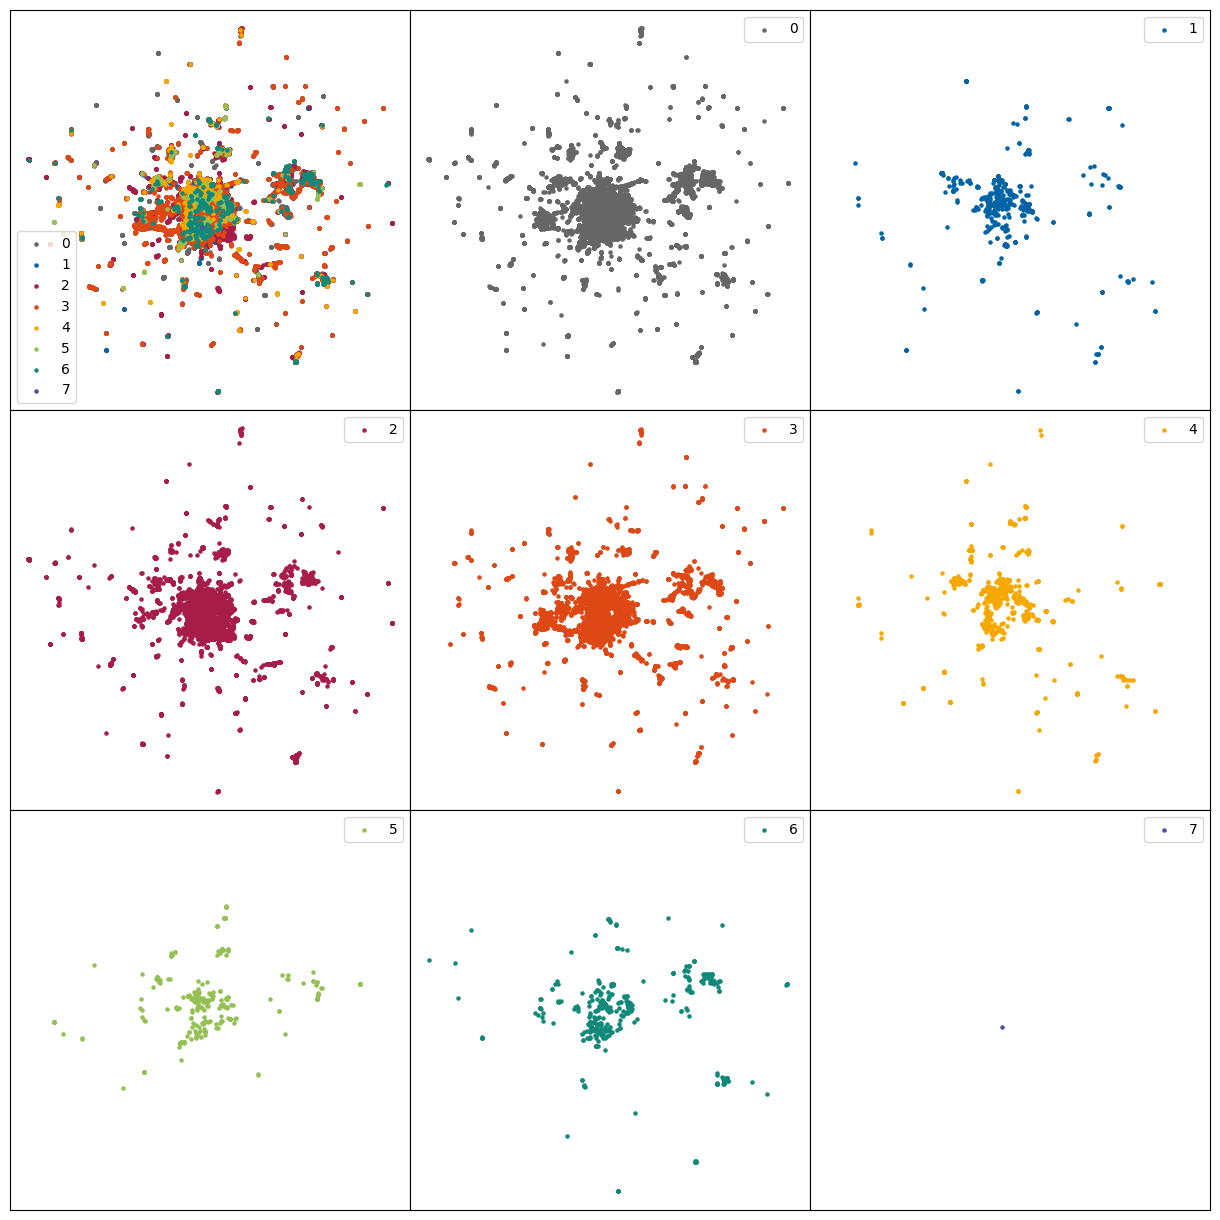

In [31]:
df = pd.read_csv("../data/Descriptors/ECFPs.csv")

df.replace("general-set","general set",inplace=True)
df.replace("refined-set","refined set",inplace=True)
df.replace("coreset","core set",inplace=True)

df_general = df[df["Settype"] == "general set"]
df_refined = df[df["Settype"] == "refined set"]
df_core = df[df["Settype"] == "core set"]

df.drop("Settype",inplace=True, axis=1)
df_general.drop("Settype",inplace=True, axis=1)
df_refined.drop("Settype",inplace=True, axis=1)
df_core.drop("Settype",inplace=True, axis=1)

df_1 = pd.read_csv("../data/exp_data/EC_numbers/1_x_x_x.csv")
df_2 = pd.read_csv("../data/exp_data/EC_numbers/2_x_x_x.csv")
df_3 = pd.read_csv("../data/exp_data/EC_numbers/3_x_x_x.csv")
df_4 = pd.read_csv("../data/exp_data/EC_numbers/4_x_x_x.csv")
df_5 = pd.read_csv("../data/exp_data/EC_numbers/5_x_x_x.csv")
df_6 = pd.read_csv("../data/exp_data/EC_numbers/6_x_x_x.csv")
df_7 = pd.read_csv("../data/exp_data/EC_numbers/7_x_x_x.csv")

lst = []

for pdb in df["PDB code"]:
    if pdb in df_1["PDB code"].values:
        lst.append(1)
    elif pdb in df_2["PDB code"].values:
        lst.append(2)
    elif pdb in df_3["PDB code"].values:
        lst.append(3)
    elif pdb in df_4["PDB code"].values:
        lst.append(4)
    elif pdb in df_5["PDB code"].values:
        lst.append(5)
    elif pdb in df_6["PDB code"].values:
        lst.append(6)
    elif pdb in df_7["PDB code"].values:
        lst.append(7)
    else:
        lst.append(0)

df["Class"] = lst

df.drop("PDB code",inplace=True, axis=1)

df_data = df.drop("Class",inplace=False,axis=1)

df_refined_data = df_refined.drop("PDB code",inplace=False,axis=1)
scaler = StandardScaler().fit(df_refined_data)

df_scaled = scaler.transform(df_data)

df_scaled = np.nan_to_num(df_scaled)

pca = PCA(n_components=35)
df_scaled = pca.fit_transform(df_scaled)

print("preprocessing DONE")

reducer =umap.UMAP(random_state=42)

reducer = reducer.fit(df_scaled)
points_all = reducer.fit_transform(df_scaled)
points_0 = points_all[df.Class == 0]
points_1 = points_all[df.Class == 1]
points_2 = points_all[df.Class == 2]
points_3 = points_all[df.Class == 3]
points_4 = points_all[df.Class == 4]
points_5 = points_all[df.Class == 5]
points_6 = points_all[df.Class == 6]
points_7 = points_all[df.Class == 7]
print(points_all.shape,points_0.shape,points_1.shape,points_2.shape,points_3.shape,points_4.shape,points_5.shape,points_6.shape,points_7.shape)
print("UMAP training DONE")

fig, axs = plt.subplots(3, 3, figsize=(12, 12),sharex=True,sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.0, hspace=0.0, wspace=0.0)

# Plot all points
axs[0, 0].scatter(points_0[:, 0], points_0[:, 1], s=5, label="0", color="#666666", alpha=1)
axs[0, 0].scatter(points_1[:, 0], points_1[:, 1], s=5, label="1", color="#0063A6", alpha=1)
axs[0, 0].scatter(points_2[:, 0], points_2[:, 1], s=5, label="2", color="#A71C49", alpha=1)
axs[0, 0].scatter(points_3[:, 0], points_3[:, 1], s=5, label="3", color="#DD4814", alpha=1)
axs[0, 0].scatter(points_4[:, 0], points_4[:, 1], s=5, label="4", color="#F6A800", alpha=1)
axs[0, 0].scatter(points_5[:, 0], points_5[:, 1], s=5, label="5", color="#94C154", alpha=1)
axs[0, 0].scatter(points_6[:, 0], points_6[:, 1], s=5, label="6", color="#11897A", alpha=1)
axs[0, 0].scatter(points_7[:, 0], points_7[:, 1], s=5, label="7", color="#4B51A1", alpha=1)
axs[0, 0].legend(loc="best")

# Plot points_0
axs[0, 1].scatter(points_0[:, 0], points_0[:, 1], s=5, label="0", color="#666666", alpha=1)
axs[0, 1].legend(loc="best")

# Plot points_1
axs[0, 2].scatter(points_1[:, 0], points_1[:, 1], s=5, label="1", color="#0063A6", alpha=1)
axs[0, 2].legend(loc="best")

# Plot points_2
axs[1, 0].scatter(points_2[:, 0], points_2[:, 1], s=5, label="2", color="#A71C49", alpha=1)
axs[1, 0].legend(loc="best")

# Plot points_3
axs[1, 1].scatter(points_3[:, 0], points_3[:, 1], s=5, label="3", color="#DD4814", alpha=1)
axs[1, 1].legend(loc="best")

# Plot points_4
axs[1, 2].scatter(points_4[:, 0], points_4[:, 1], s=5, label="4", color="#F6A800", alpha=1)
axs[1, 2].legend(loc="best")

# Plot points_5
axs[2, 0].scatter(points_5[:, 0], points_5[:, 1], s=5, label="5", color="#94C154", alpha=1)
axs[2, 0].legend(loc="best")

# Plot points_6
axs[2, 1].scatter(points_6[:, 0], points_6[:, 1], s=5, label="6", color="#11897A", alpha=1)
axs[2, 1].legend(loc="best")

# Plot points_7
axs[2, 2].scatter(points_7[:, 0], points_7[:, 1], s=5, label="7", color="#4B51A1", alpha=1)
axs[2, 2].legend(loc="best")

for ax in axs:
    for a in ax:
        a.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        
plt.show()

/tmp/ipykernel_1874206/2069019148.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general.drop("Settype",inplace=True, axis=1)
/tmp/ipykernel_1874206/2069019148.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_refined.drop("Settype",inplace=True, axis=1)
/tmp/ipykernel_1874206/2069019148.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_core.drop("Settype",inplace=True, axis=1)


preprocessing DONE


/data/shared/software/conda/christian_fellinger/envs/GRADE/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(18904, 2) (7976, 2) (450, 2) (4509, 2) (4550, 2) (726, 2) (291, 2) (401, 2) (1, 2)
UMAP training DONE


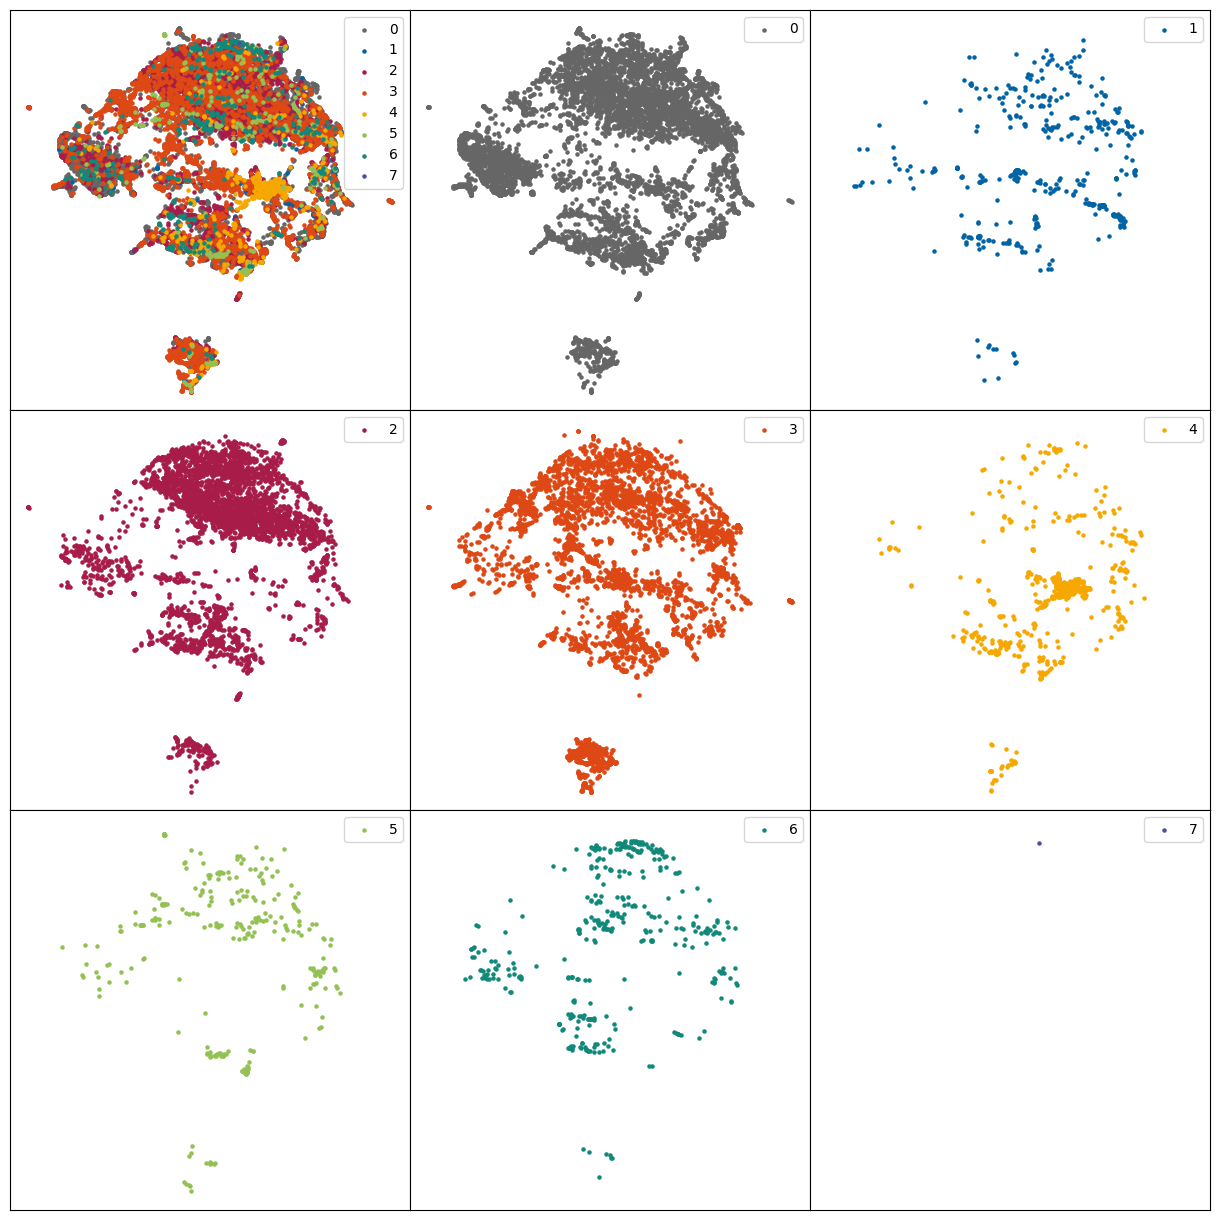

In [33]:
df = pd.read_csv("../data/Descriptors/DXGB.csv")

df_general = df[df["Settype"] == "general-set"]
df_refined = df[df["Settype"] == "refined-set"]
df_core = df[df["Settype"] == "coreset"]

df.drop("Settype",inplace=True, axis=1)
df_general.drop("Settype",inplace=True, axis=1)
df_refined.drop("Settype",inplace=True, axis=1)
df_core.drop("Settype",inplace=True, axis=1)

df_1 = pd.read_csv("../data/exp_data/EC_numbers/1_x_x_x.csv")
df_2 = pd.read_csv("../data/exp_data/EC_numbers/2_x_x_x.csv")
df_3 = pd.read_csv("../data/exp_data/EC_numbers/3_x_x_x.csv")
df_4 = pd.read_csv("../data/exp_data/EC_numbers/4_x_x_x.csv")
df_5 = pd.read_csv("../data/exp_data/EC_numbers/5_x_x_x.csv")
df_6 = pd.read_csv("../data/exp_data/EC_numbers/6_x_x_x.csv")
df_7 = pd.read_csv("../data/exp_data/EC_numbers/7_x_x_x.csv")

lst = []

for pdb in df["PDB code"]:
    if pdb in df_1["PDB code"].values:
        lst.append(1)
    elif pdb in df_2["PDB code"].values:
        lst.append(2)
    elif pdb in df_3["PDB code"].values:
        lst.append(3)
    elif pdb in df_4["PDB code"].values:
        lst.append(4)
    elif pdb in df_5["PDB code"].values:
        lst.append(5)
    elif pdb in df_6["PDB code"].values:
        lst.append(6)
    elif pdb in df_7["PDB code"].values:
        lst.append(7)
    else:
        lst.append(0)

df["Class"] = lst

df.drop("PDB code",inplace=True, axis=1)

df_data = df.drop("Class",inplace=False,axis=1)

df_refined_data = df_refined.drop("PDB code",inplace=False,axis=1)
scaler = StandardScaler().fit(df_refined_data)

df_scaled = scaler.transform(df_data)

df_scaled = np.nan_to_num(df_scaled)

pca = PCA(n_components=35)
df_scaled = pca.fit_transform(df_scaled)

print("preprocessing DONE")

reducer =umap.UMAP(random_state=42)

reducer = reducer.fit(df_scaled)
points_all = reducer.fit_transform(df_scaled)
points_0 = points_all[df.Class == 0]
points_1 = points_all[df.Class == 1]
points_2 = points_all[df.Class == 2]
points_3 = points_all[df.Class == 3]
points_4 = points_all[df.Class == 4]
points_5 = points_all[df.Class == 5]
points_6 = points_all[df.Class == 6]
points_7 = points_all[df.Class == 7]
print(points_all.shape,points_0.shape,points_1.shape,points_2.shape,points_3.shape,points_4.shape,points_5.shape,points_6.shape,points_7.shape)
print("UMAP training DONE")

fig, axs = plt.subplots(3, 3, figsize=(12, 12),sharex=True,sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.0, hspace=0.0, wspace=0.0)

# Plot all points
axs[0, 0].scatter(points_0[:, 0], points_0[:, 1], s=5, label="0", color="#666666", alpha=1)
axs[0, 0].scatter(points_1[:, 0], points_1[:, 1], s=5, label="1", color="#0063A6", alpha=1)
axs[0, 0].scatter(points_2[:, 0], points_2[:, 1], s=5, label="2", color="#A71C49", alpha=1)
axs[0, 0].scatter(points_3[:, 0], points_3[:, 1], s=5, label="3", color="#DD4814", alpha=1)
axs[0, 0].scatter(points_4[:, 0], points_4[:, 1], s=5, label="4", color="#F6A800", alpha=1)
axs[0, 0].scatter(points_5[:, 0], points_5[:, 1], s=5, label="5", color="#94C154", alpha=1)
axs[0, 0].scatter(points_6[:, 0], points_6[:, 1], s=5, label="6", color="#11897A", alpha=1)
axs[0, 0].scatter(points_7[:, 0], points_7[:, 1], s=5, label="7", color="#4B51A1", alpha=1)
axs[0, 0].legend(loc="best")

# Plot points_0
axs[0, 1].scatter(points_0[:, 0], points_0[:, 1], s=5, label="0", color="#666666", alpha=1)
axs[0, 1].legend(loc="best")

# Plot points_1
axs[0, 2].scatter(points_1[:, 0], points_1[:, 1], s=5, label="1", color="#0063A6", alpha=1)
axs[0, 2].legend(loc="best")

# Plot points_2
axs[1, 0].scatter(points_2[:, 0], points_2[:, 1], s=5, label="2", color="#A71C49", alpha=1)
axs[1, 0].legend(loc="best")

# Plot points_3
axs[1, 1].scatter(points_3[:, 0], points_3[:, 1], s=5, label="3", color="#DD4814", alpha=1)
axs[1, 1].legend(loc="best")

# Plot points_4
axs[1, 2].scatter(points_4[:, 0], points_4[:, 1], s=5, label="4", color="#F6A800", alpha=1)
axs[1, 2].legend(loc="best")

# Plot points_5
axs[2, 0].scatter(points_5[:, 0], points_5[:, 1], s=5, label="5", color="#94C154", alpha=1)
axs[2, 0].legend(loc="best")

# Plot points_6
axs[2, 1].scatter(points_6[:, 0], points_6[:, 1], s=5, label="6", color="#11897A", alpha=1)
axs[2, 1].legend(loc="best")

# Plot points_7
axs[2, 2].scatter(points_7[:, 0], points_7[:, 1], s=5, label="7", color="#4B51A1", alpha=1)
axs[2, 2].legend(loc="best")

for ax in axs:
    for a in ax:
        a.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        
plt.show()

---------------------------------------------------------------
PL-REX

---------------------------------------------------------------

Preprocessing DONE


/data/shared/software/conda/christian_fellinger/envs/GRADE/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP training DONE


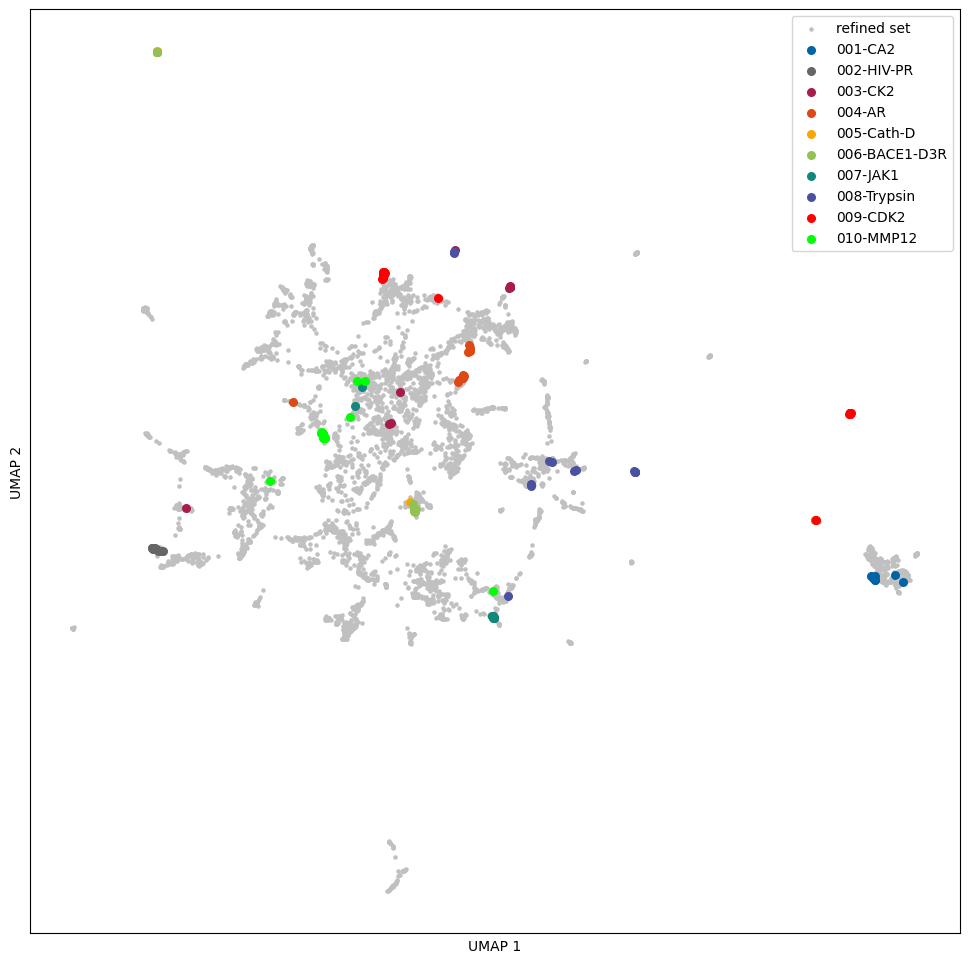

In [34]:
# X-GRADE descriptors
# Load and preprocess data
df_refined = pd.read_csv("../data/Descriptors/PDBbind_refined_set_X-GRADE.csv")
df_refined.drop("PDB code", inplace=True, axis=1)
df_refined["Settype"] = "refined set"

df_001 = pd.read_csv("../data/Descriptors/PL-REX/001-CA2/X-GRADE.csv")
df_001.drop("PDB code", inplace=True, axis=1)
df_001["Settype"] = "001-CA2"

df_002 = pd.read_csv("../data/Descriptors/PL-REX/002-HIV-PR/X-GRADE.csv")
df_002.drop("PDB code", inplace=True, axis=1)
df_002["Settype"] = "002-HIV-PR"

df_003 = pd.read_csv("../data/Descriptors/PL-REX/003-CK2/X-GRADE.csv")
df_003.drop("PDB code", inplace=True, axis=1)
df_003["Settype"] = "003-CK2"

df_004 = pd.read_csv("../data/Descriptors/PL-REX/004-AR/X-GRADE.csv")
df_004.drop("PDB code", inplace=True, axis=1)
df_004["Settype"] = "004-AR"

df_005 = pd.read_csv("../data/Descriptors/PL-REX/005-Cath-D/X-GRADE.csv")
df_005.drop("PDB code", inplace=True, axis=1)
df_005["Settype"] = "005-Cath-D"

df_006 = pd.read_csv("../data/Descriptors/PL-REX/006-BACE1-D3R/X-GRADE.csv")
df_006.drop("PDB code", inplace=True, axis=1)
df_006["Settype"] = "006-BACE1-D3R"

df_007 = pd.read_csv("../data/Descriptors/PL-REX/007-JAK1/X-GRADE.csv")
df_007.drop("PDB code", inplace=True, axis=1)
df_007["Settype"] = "007-JAK1"

df_008 = pd.read_csv("../data/Descriptors/PL-REX/008-Trypsin/X-GRADE.csv")
df_008.drop("PDB code", inplace=True, axis=1)
df_008["Settype"] = "008-Trypsin"

df_009 = pd.read_csv("../data/Descriptors/PL-REX/009-CDK2/X-GRADE.csv")
df_009.drop("PDB code", inplace=True, axis=1)
df_009["Settype"] = "009-CDK2"

df_010 = pd.read_csv("../data/Descriptors/PL-REX/010-MMP12/X-GRADE.csv")
df_010.drop("PDB code", inplace=True, axis=1)
df_010["Settype"] = "010-MMP12"

dataframes = [df_refined, df_001, df_002, df_003, df_004, df_005, df_006, df_007, df_008, df_009, df_010]
df = pd.concat(dataframes)

# Separate data and set type
df_data = df.drop("Settype", inplace=False, axis=1)
df_refined_data = df_refined.drop("Settype", inplace=False, axis=1)

# Standardize the data
scaler = StandardScaler().fit(df_refined_data)
df_scaled = scaler.transform(df_data)
df_scaled = np.nan_to_num(df_scaled)

pca = PCA(n_components=35)
df_scaled = pca.fit_transform(df_scaled)

print("Preprocessing DONE")

# Apply UMAP
reducer = umap.UMAP(random_state=42)
points_all = reducer.fit_transform(df_scaled)
print("UMAP training DONE")

# Convert Settype column to a category
df["Settype"] = df["Settype"].astype('category')
categories = df["Settype"].cat.categories
colors = ["#0063A6", "#666666", "#A71C49", "#DD4814", "#F6A800", "#94C154", "#11897A", "#4B51A1", "#FF0000", "#00FF00", "#D3D3D3"]

# Plot UMAP
plt.figure(figsize=(12, 12))

# Plot refined set in the background
subset_refined = points_all[df["Settype"] == "refined set"]
plt.scatter(subset_refined[:, 0], subset_refined[:, 1], s=5, label="refined set", color="#C0C0C0", alpha=1)

# Plot all other sets on top
for i, category in enumerate(categories):
    if category != "refined set":
        subset = points_all[df["Settype"] == category]
        plt.scatter(subset[:, 0], subset[:, 1], s=30, label=category, color=colors[i], alpha=1)

# plt.title("UMAP projection of the PL-REX dataset in comparison to the PDBbind refined set using X-GRADE descriptors")
plt.xticks([])
plt.yticks([])
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc="best")
plt.show()


Preprocessing DONE


/data/shared/software/conda/christian_fellinger/envs/GRADE/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP training DONE


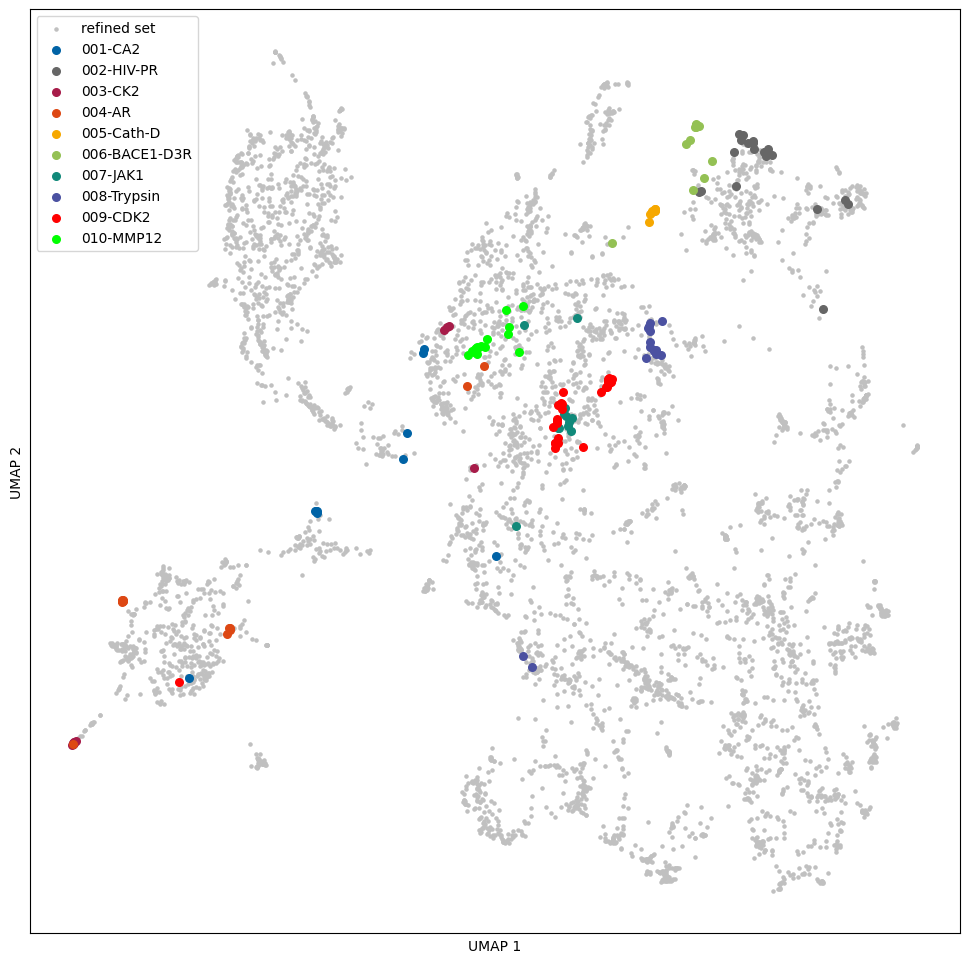

In [35]:
# GRADE descriptors
# Load and preprocess data
df_refined = pd.read_csv("../data/Descriptors/PDBbind_refined_set_GRADE.csv")
df_refined.drop("PDB code", inplace=True, axis=1)
df_refined["Settype"] = "refined set"

df_001 = pd.read_csv("../data/Descriptors/PL-REX/001-CA2/GRADE.csv")
df_001.drop("PDB code", inplace=True, axis=1)
df_001["Settype"] = "001-CA2"

df_002 = pd.read_csv("../data/Descriptors/PL-REX/002-HIV-PR/GRADE.csv")
df_002.drop("PDB code", inplace=True, axis=1)
df_002["Settype"] = "002-HIV-PR"

df_003 = pd.read_csv("../data/Descriptors/PL-REX/003-CK2/GRADE.csv")
df_003.drop("PDB code", inplace=True, axis=1)
df_003["Settype"] = "003-CK2"

df_004 = pd.read_csv("../data/Descriptors/PL-REX/004-AR/GRADE.csv")
df_004.drop("PDB code", inplace=True, axis=1)
df_004["Settype"] = "004-AR"

df_005 = pd.read_csv("../data/Descriptors/PL-REX/005-Cath-D/GRADE.csv")
df_005.drop("PDB code", inplace=True, axis=1)
df_005["Settype"] = "005-Cath-D"

df_006 = pd.read_csv("../data/Descriptors/PL-REX/006-BACE1-D3R/GRADE.csv")
df_006.drop("PDB code", inplace=True, axis=1)
df_006["Settype"] = "006-BACE1-D3R"

df_007 = pd.read_csv("../data/Descriptors/PL-REX/007-JAK1/GRADE.csv")
df_007.drop("PDB code", inplace=True, axis=1)
df_007["Settype"] = "007-JAK1"

df_008 = pd.read_csv("../data/Descriptors/PL-REX/008-Trypsin/GRADE.csv")
df_008.drop("PDB code", inplace=True, axis=1)
df_008["Settype"] = "008-Trypsin"

df_009 = pd.read_csv("../data/Descriptors/PL-REX/009-CDK2/GRADE.csv")
df_009.drop("PDB code", inplace=True, axis=1)
df_009["Settype"] = "009-CDK2"

df_010 = pd.read_csv("../data/Descriptors/PL-REX/010-MMP12/GRADE.csv")
df_010.drop("PDB code", inplace=True, axis=1)
df_010["Settype"] = "010-MMP12"

dataframes = [df_refined, df_001, df_002, df_003, df_004, df_005, df_006, df_007, df_008, df_009, df_010]
df = pd.concat(dataframes)

# Separate data and set type
df_data = df.drop("Settype", inplace=False, axis=1)
df_refined_data = df_refined.drop("Settype", inplace=False, axis=1)

# Standardize the data
scaler = StandardScaler().fit(df_refined_data)
df_scaled = scaler.transform(df_data)
df_scaled = np.nan_to_num(df_scaled)

pca = PCA(n_components=35)
df_scaled = pca.fit_transform(df_scaled)

print("Preprocessing DONE")

# Apply UMAP
reducer = umap.UMAP(random_state=42)
points_all = reducer.fit_transform(df_scaled)
print("UMAP training DONE")

# Convert Settype column to a category
df["Settype"] = df["Settype"].astype('category')
categories = df["Settype"].cat.categories
colors = ["#0063A6", "#666666", "#A71C49", "#DD4814", "#F6A800", "#94C154", "#11897A", "#4B51A1", "#FF0000", "#00FF00", "#D3D3D3"]

# Plot UMAP
plt.figure(figsize=(12, 12))

# Plot refined set in the background
subset_refined = points_all[df["Settype"] == "refined set"]
plt.scatter(subset_refined[:, 0], subset_refined[:, 1], s=5, label="refined set", color="#C0C0C0", alpha=1)

# Plot all other sets on top
for i, category in enumerate(categories):
    if category != "refined set":
        subset = points_all[df["Settype"] == category]
        plt.scatter(subset[:, 0], subset[:, 1], s=30, label=category, color=colors[i], alpha=1)

# plt.title("UMAP projection of the PL-REX dataset in comparison to the PDBbind refined set using X-GRADE descriptors")
plt.xticks([])
plt.yticks([])
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc="best")
plt.show()


-------------------------------------------
t-SNE

-------------------------------------------

preprocessing DONE
t-SNE training DONE


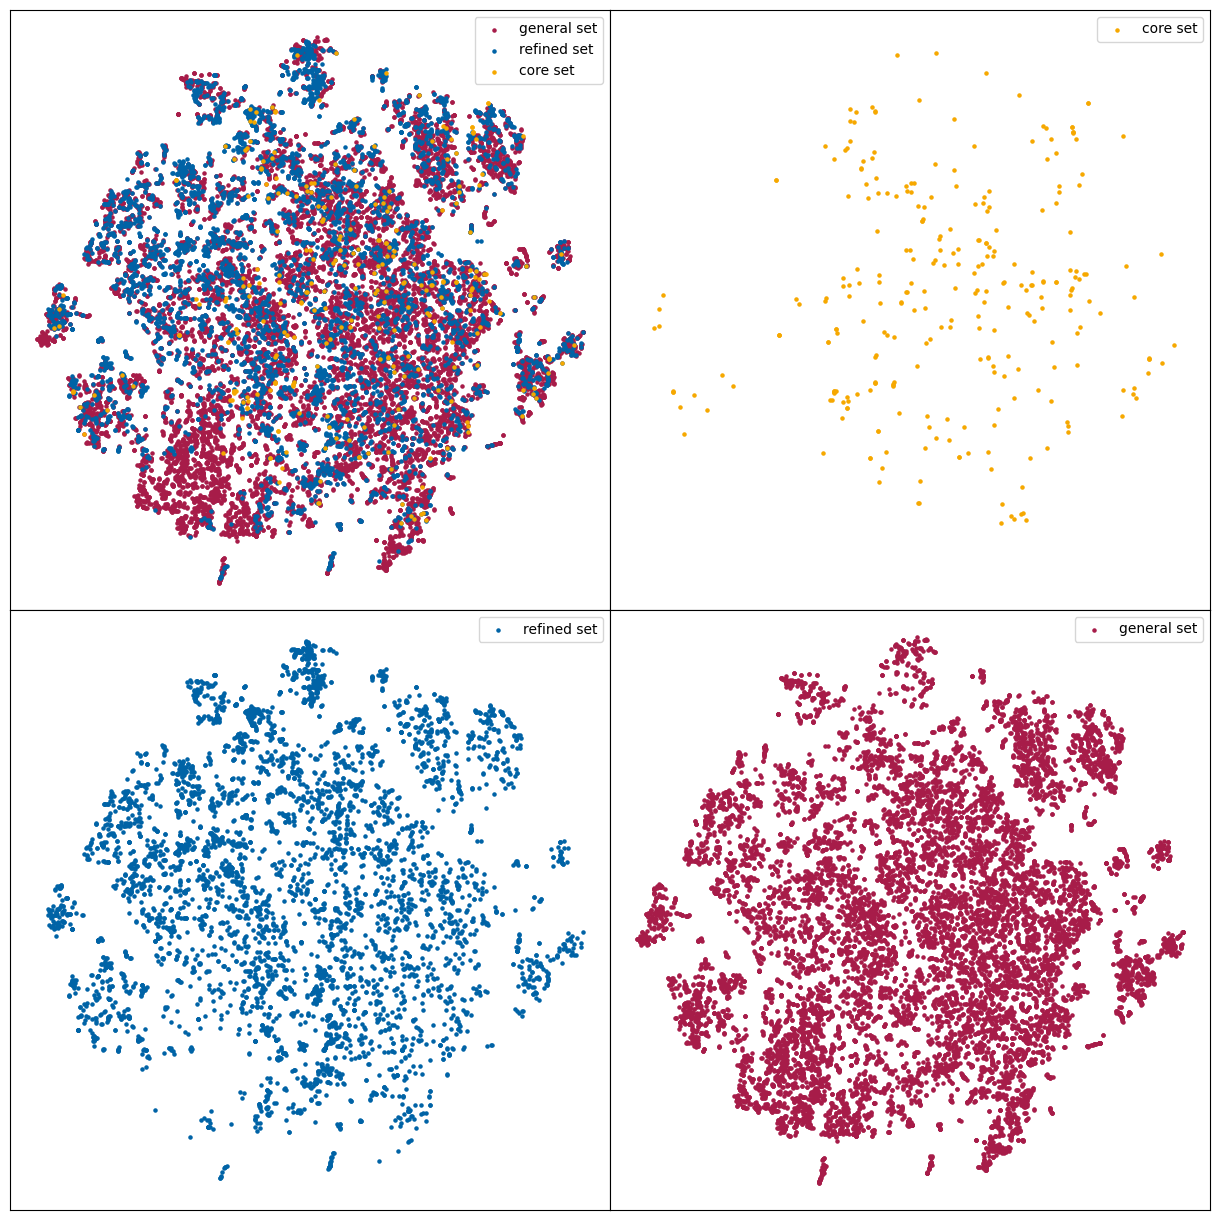

In [36]:
# X-GRADE descriptors
df_general = pd.read_csv("../data/Descriptors/PDBbind_general_set_X-GRADE.csv")
df_general.drop("PDB code",inplace=True, axis=1)
df_general["Settype"] = "general set"
df_refined = pd.read_csv("../data/Descriptors/PDBbind_refined_set_X-GRADE.csv")
df_refined.drop("PDB code",inplace=True, axis=1)
df_refined["Settype"] = "refined set"
df_core = pd.read_csv("../data/Descriptors/PDBbind_core_set_X-GRADE.csv")
df_core.drop("PDB code",inplace=True, axis=1)
df_core["Settype"] = "core set"

dataframes = [df_general,df_refined,df_core]
df = pd.concat(dataframes)

df_data = df.drop("Settype",inplace=False,axis=1)

df_refined_data = df_refined.drop("Settype",inplace=False,axis=1)
df_core_data = df_core.drop("Settype",inplace=False,axis=1)
df_general_data = df_general.drop("Settype",inplace=False,axis=1)
scaler = StandardScaler().fit(df_refined_data)

df_scaled = scaler.transform(df_data)

df_scaled = np.nan_to_num(df_scaled)

pca = PCA(n_components=35)
df_scaled = pca.fit_transform(df_scaled)

print("preprocessing DONE")

reducer = TSNE(n_components=2)

points_all = reducer.fit_transform(df_scaled)
points_general = points_all[df.Settype == "general set"]
points_refined = points_all[df.Settype == "refined set"]
points_core = points_all[df.Settype == "core set"]
print("t-SNE training DONE")

# Plot t-SNE
fig, axs = plt.subplots(2, 2, figsize=(12, 12),sharex=True,sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.0, hspace=0.0, wspace=0.0)

# Plot all points
axs[0, 0].scatter(points_general[:, 0], points_general[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
axs[0, 0].scatter(points_refined[:, 0], points_refined[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
axs[0, 0].scatter(points_core[:, 0], points_core[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
axs[0, 0].legend(loc="best")

# Plot points_core
axs[0, 1].scatter(points_core[:, 0], points_core[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
axs[0, 1].legend(loc="best")

# Plot points_refined
axs[1, 0].scatter(points_refined[:, 0], points_refined[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
axs[1, 0].legend(loc="best")

# Plot points_general
axs[1, 1].scatter(points_general[:, 0], points_general[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
axs[1, 1].legend(loc="best")

for ax in axs:
    for a in ax:
        a.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        
plt.show()


preprocessing DONE
t-SNE training DONE


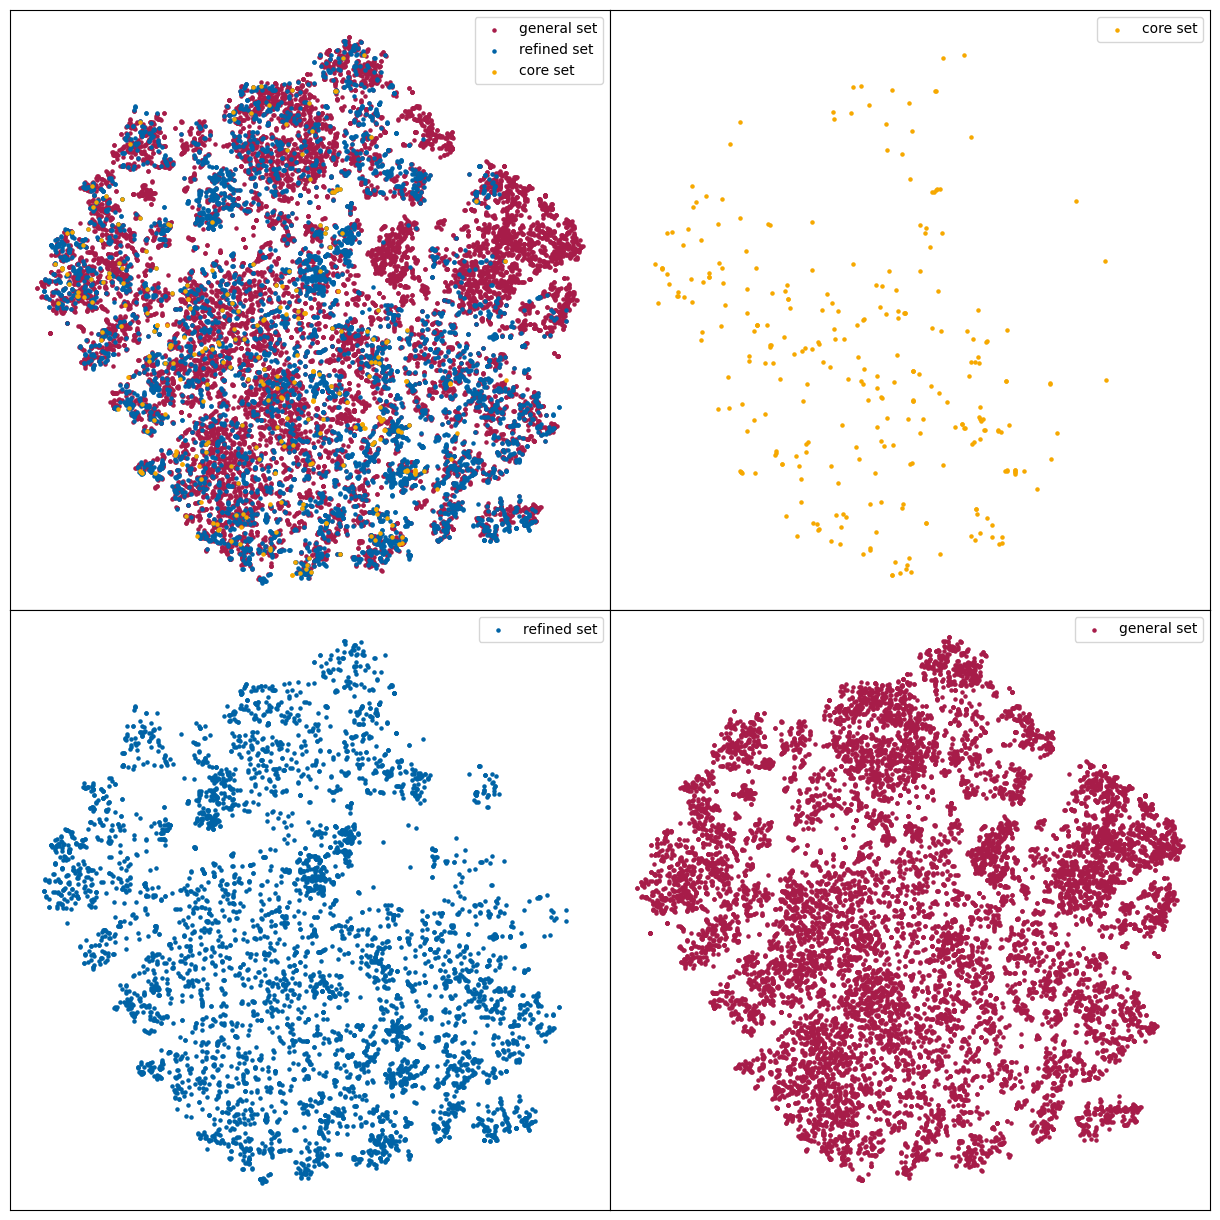

In [37]:
# GRADE descriptors
df_general = pd.read_csv("../data/Descriptors/PDBbind_general_set_GRADE.csv")
df_general.drop("PDB code",inplace=True, axis=1)
df_general["Settype"] = "general set"
df_refined = pd.read_csv("../data/Descriptors/PDBbind_refined_set_GRADE.csv")
df_refined.drop("PDB code",inplace=True, axis=1)
df_refined["Settype"] = "refined set"
df_core = pd.read_csv("../data/Descriptors/PDBbind_core_set_GRADE.csv")
df_core.drop("PDB code",inplace=True, axis=1)
df_core["Settype"] = "core set"

dataframes = [df_general,df_refined,df_core]
df = pd.concat(dataframes)

df_data = df.drop("Settype",inplace=False,axis=1)

df_refined_data = df_refined.drop("Settype",inplace=False,axis=1)
df_core_data = df_core.drop("Settype",inplace=False,axis=1)
df_general_data = df_general.drop("Settype",inplace=False,axis=1)
scaler = StandardScaler().fit(df_refined_data)

df_scaled = scaler.transform(df_data)

df_scaled = np.nan_to_num(df_scaled)

print("preprocessing DONE")

reducer = TSNE(n_components=2)

points_all = reducer.fit_transform(df_scaled)
points_general = points_all[df.Settype == "general set"]
points_refined = points_all[df.Settype == "refined set"]
points_core = points_all[df.Settype == "core set"]
print("t-SNE training DONE")

# Plot t-SNE
fig, axs = plt.subplots(2, 2, figsize=(12, 12),sharex=True,sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.0, hspace=0.0, wspace=0.0)

# Plot all points
axs[0, 0].scatter(points_general[:, 0], points_general[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
axs[0, 0].scatter(points_refined[:, 0], points_refined[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
axs[0, 0].scatter(points_core[:, 0], points_core[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
axs[0, 0].legend(loc="best")

# Plot points_core
axs[0, 1].scatter(points_core[:, 0], points_core[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
axs[0, 1].legend(loc="best")

# Plot points_refined
axs[1, 0].scatter(points_refined[:, 0], points_refined[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
axs[1, 0].legend(loc="best")

# Plot points_general
axs[1, 1].scatter(points_general[:, 0], points_general[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
axs[1, 1].legend(loc="best")

for ax in axs:
    for a in ax:
        a.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        
plt.show()

preprocessing DONE
(19727, 2) (8141, 2) (460, 2) (4718, 2) (4914, 2) (772, 2) (295, 2) (426, 2) (1, 2)
t-SNE training DONE


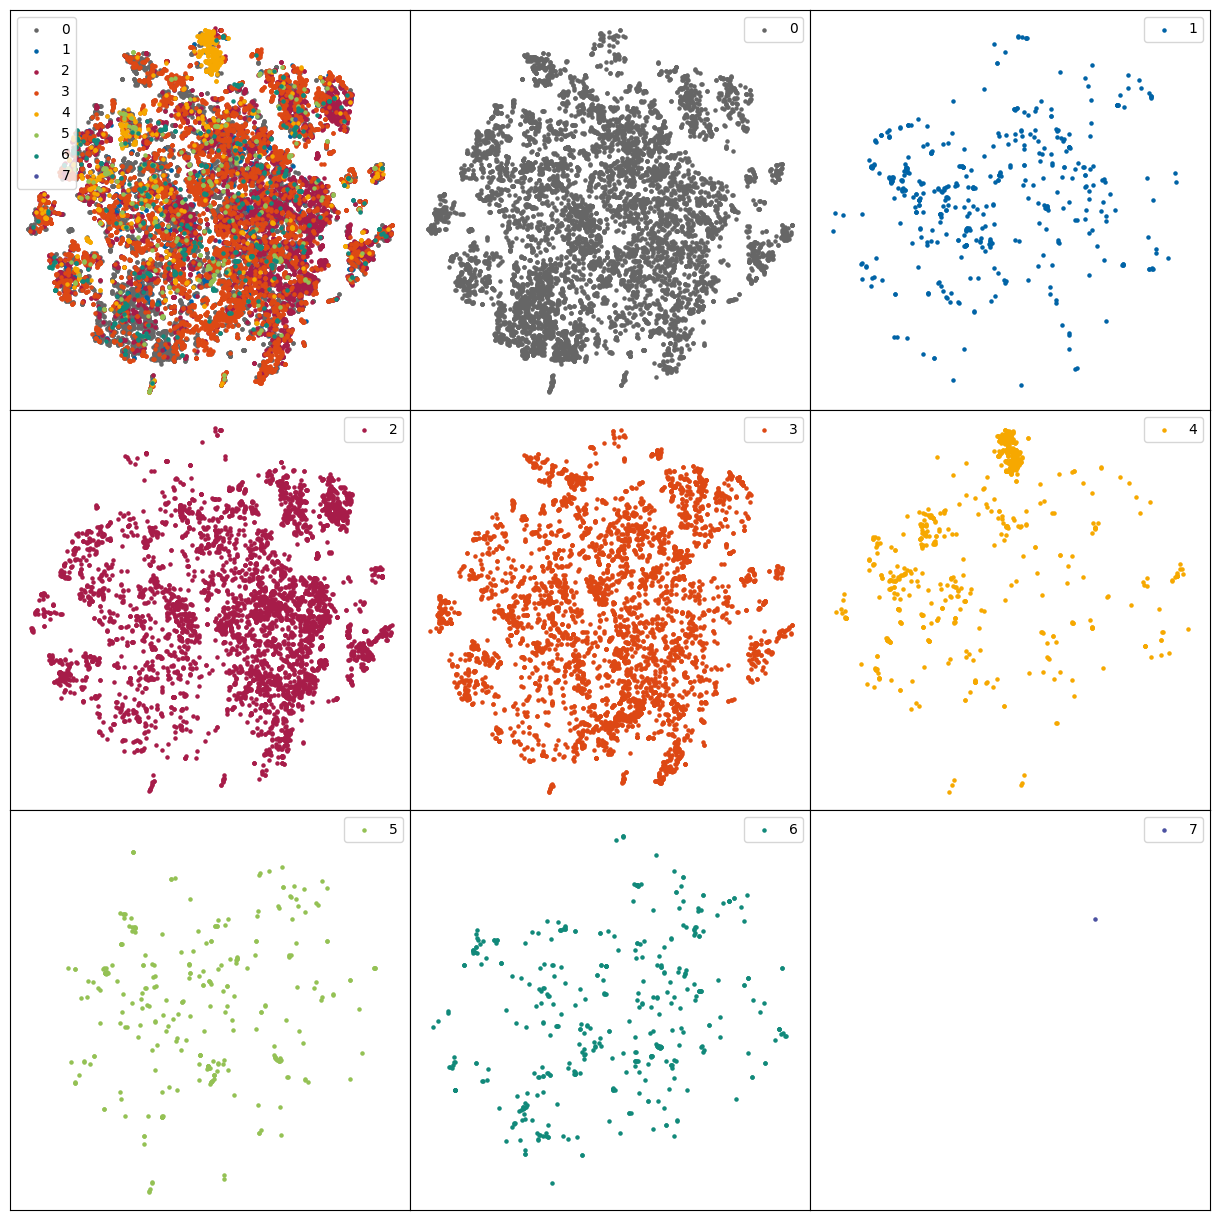

In [38]:
# X-GRADE descriptors
df_general = pd.read_csv("../data/Descriptors/PDBbind_general_set_X-GRADE.csv")
df_refined = pd.read_csv("../data/Descriptors/PDBbind_refined_set_X-GRADE.csv")
df_core = pd.read_csv("../data/Descriptors/PDBbind_core_set_X-GRADE.csv")

dataframes = [df_general,df_refined,df_core]
df = pd.concat(dataframes)

df_1 = pd.read_csv("../data/exp_data/EC_numbers/1_x_x_x.csv")
df_2 = pd.read_csv("../data/exp_data/EC_numbers/2_x_x_x.csv")
df_3 = pd.read_csv("../data/exp_data/EC_numbers/3_x_x_x.csv")
df_4 = pd.read_csv("../data/exp_data/EC_numbers/4_x_x_x.csv")
df_5 = pd.read_csv("../data/exp_data/EC_numbers/5_x_x_x.csv")
df_6 = pd.read_csv("../data/exp_data/EC_numbers/6_x_x_x.csv")
df_7 = pd.read_csv("../data/exp_data/EC_numbers/7_x_x_x.csv")

lst = []

for pdb in df["PDB code"]:
    if pdb in df_1["PDB code"].values:
        lst.append(1)
    elif pdb in df_2["PDB code"].values:
        lst.append(2)
    elif pdb in df_3["PDB code"].values:
        lst.append(3)
    elif pdb in df_4["PDB code"].values:
        lst.append(4)
    elif pdb in df_5["PDB code"].values:
        lst.append(5)
    elif pdb in df_6["PDB code"].values:
        lst.append(6)
    elif pdb in df_7["PDB code"].values:
        lst.append(7)
    else:
        lst.append(0)

df["Class"] = lst

df.drop("PDB code",inplace=True, axis=1)

df_data = df.drop("Class",inplace=False,axis=1)

df_refined_data = df_refined.drop("PDB code",inplace=False,axis=1)
scaler = StandardScaler().fit(df_refined_data)

df_scaled = scaler.transform(df_data)

df_scaled = np.nan_to_num(df_scaled)

pca = PCA(n_components=35)
df_scaled = pca.fit_transform(df_scaled)

print("preprocessing DONE")

reducer =TSNE(n_components=2)

reducer = reducer.fit(df_scaled)
points_all = reducer.fit_transform(df_scaled)
points_0 = points_all[df.Class == 0]
points_1 = points_all[df.Class == 1]
points_2 = points_all[df.Class == 2]
points_3 = points_all[df.Class == 3]
points_4 = points_all[df.Class == 4]
points_5 = points_all[df.Class == 5]
points_6 = points_all[df.Class == 6]
points_7 = points_all[df.Class == 7]
print(points_all.shape,points_0.shape,points_1.shape,points_2.shape,points_3.shape,points_4.shape,points_5.shape,points_6.shape,points_7.shape)
print("t-SNE training DONE")

# Plot t-SNE
fig, axs = plt.subplots(3, 3, figsize=(12, 12),sharex=True,sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.0, hspace=0.0, wspace=0.0)

# Plot all points
axs[0, 0].scatter(points_0[:, 0], points_0[:, 1], s=5, label="0", color="#666666", alpha=1)
axs[0, 0].scatter(points_1[:, 0], points_1[:, 1], s=5, label="1", color="#0063A6", alpha=1)
axs[0, 0].scatter(points_2[:, 0], points_2[:, 1], s=5, label="2", color="#A71C49", alpha=1)
axs[0, 0].scatter(points_3[:, 0], points_3[:, 1], s=5, label="3", color="#DD4814", alpha=1)
axs[0, 0].scatter(points_4[:, 0], points_4[:, 1], s=5, label="4", color="#F6A800", alpha=1)
axs[0, 0].scatter(points_5[:, 0], points_5[:, 1], s=5, label="5", color="#94C154", alpha=1)
axs[0, 0].scatter(points_6[:, 0], points_6[:, 1], s=5, label="6", color="#11897A", alpha=1)
axs[0, 0].scatter(points_7[:, 0], points_7[:, 1], s=5, label="7", color="#4B51A1", alpha=1)
axs[0, 0].legend(loc="best")

# Plot points_0
axs[0, 1].scatter(points_0[:, 0], points_0[:, 1], s=5, label="0", color="#666666", alpha=1)
axs[0, 1].legend(loc="best")

# Plot points_1
axs[0, 2].scatter(points_1[:, 0], points_1[:, 1], s=5, label="1", color="#0063A6", alpha=1)
axs[0, 2].legend(loc="best")

# Plot points_2
axs[1, 0].scatter(points_2[:, 0], points_2[:, 1], s=5, label="2", color="#A71C49", alpha=1)
axs[1, 0].legend(loc="best")

# Plot points_3
axs[1, 1].scatter(points_3[:, 0], points_3[:, 1], s=5, label="3", color="#DD4814", alpha=1)
axs[1, 1].legend(loc="best")

# Plot points_4
axs[1, 2].scatter(points_4[:, 0], points_4[:, 1], s=5, label="4", color="#F6A800", alpha=1)
axs[1, 2].legend(loc="best")

# Plot points_5
axs[2, 0].scatter(points_5[:, 0], points_5[:, 1], s=5, label="5", color="#94C154", alpha=1)
axs[2, 0].legend(loc="best")

# Plot points_6
axs[2, 1].scatter(points_6[:, 0], points_6[:, 1], s=5, label="6", color="#11897A", alpha=1)
axs[2, 1].legend(loc="best")

# Plot points_7
axs[2, 2].scatter(points_7[:, 0], points_7[:, 1], s=5, label="7", color="#4B51A1", alpha=1)
axs[2, 2].legend(loc="best")

for ax in axs:
    for a in ax:
        a.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        
plt.show()

preprocessing DONE
(19727, 2) (8141, 2) (460, 2) (4718, 2) (4914, 2) (772, 2) (295, 2) (426, 2) (1, 2)
t-SNE training DONE


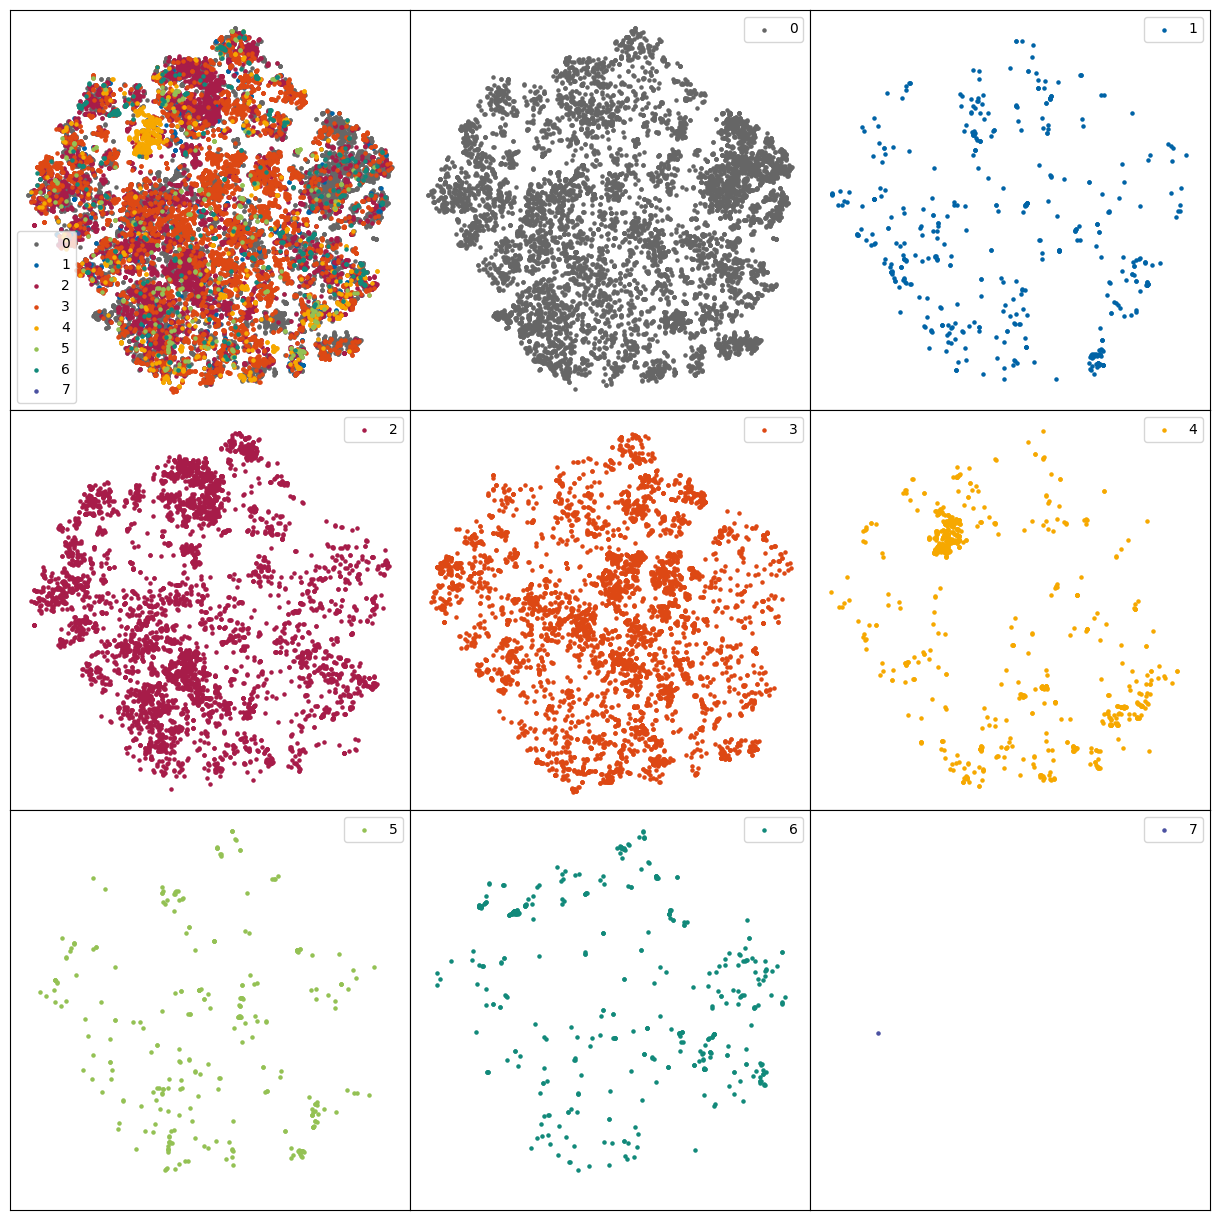

In [39]:
# GRADE descriptors
df_general = pd.read_csv("../data/Descriptors/PDBbind_general_set_GRADE.csv")
df_refined = pd.read_csv("../data/Descriptors/PDBbind_refined_set_GRADE.csv")
df_core = pd.read_csv("../data/Descriptors/PDBbind_core_set_GRADE.csv")

dataframes = [df_general,df_refined,df_core]
df = pd.concat(dataframes)

df_1 = pd.read_csv("../data/exp_data/EC_numbers/1_x_x_x.csv")
df_2 = pd.read_csv("../data/exp_data/EC_numbers/2_x_x_x.csv")
df_3 = pd.read_csv("../data/exp_data/EC_numbers/3_x_x_x.csv")
df_4 = pd.read_csv("../data/exp_data/EC_numbers/4_x_x_x.csv")
df_5 = pd.read_csv("../data/exp_data/EC_numbers/5_x_x_x.csv")
df_6 = pd.read_csv("../data/exp_data/EC_numbers/6_x_x_x.csv")
df_7 = pd.read_csv("../data/exp_data/EC_numbers/7_x_x_x.csv")

lst = []

for pdb in df["PDB code"]:
    if pdb in df_1["PDB code"].values:
        lst.append(1)
    elif pdb in df_2["PDB code"].values:
        lst.append(2)
    elif pdb in df_3["PDB code"].values:
        lst.append(3)
    elif pdb in df_4["PDB code"].values:
        lst.append(4)
    elif pdb in df_5["PDB code"].values:
        lst.append(5)
    elif pdb in df_6["PDB code"].values:
        lst.append(6)
    elif pdb in df_7["PDB code"].values:
        lst.append(7)
    else:
        lst.append(0)

df["Class"] = lst

df.drop("PDB code",inplace=True, axis=1)

df_data = df.drop("Class",inplace=False,axis=1)

df_refined_data = df_refined.drop("PDB code",inplace=False,axis=1)
scaler = StandardScaler().fit(df_refined_data)

df_scaled = scaler.transform(df_data)

df_scaled = np.nan_to_num(df_scaled)
print("preprocessing DONE")

reducer = TSNE(n_components=2)

reducer = reducer.fit(df_scaled)
points_all = reducer.fit_transform(df_scaled)
points_0 = points_all[df.Class == 0]
points_1 = points_all[df.Class == 1]
points_2 = points_all[df.Class == 2]
points_3 = points_all[df.Class == 3]
points_4 = points_all[df.Class == 4]
points_5 = points_all[df.Class == 5]
points_6 = points_all[df.Class == 6]
points_7 = points_all[df.Class == 7]
print(points_all.shape,points_0.shape,points_1.shape,points_2.shape,points_3.shape,points_4.shape,points_5.shape,points_6.shape,points_7.shape)
print("t-SNE training DONE")

# Plot t-SNE
fig, axs = plt.subplots(3, 3, figsize=(12, 12),sharex=True,sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.0, hspace=0.0, wspace=0.0)

# Plot all points
axs[0, 0].scatter(points_0[:, 0], points_0[:, 1], s=5, label="0", color="#666666", alpha=1)
axs[0, 0].scatter(points_1[:, 0], points_1[:, 1], s=5, label="1", color="#0063A6", alpha=1)
axs[0, 0].scatter(points_2[:, 0], points_2[:, 1], s=5, label="2", color="#A71C49", alpha=1)
axs[0, 0].scatter(points_3[:, 0], points_3[:, 1], s=5, label="3", color="#DD4814", alpha=1)
axs[0, 0].scatter(points_4[:, 0], points_4[:, 1], s=5, label="4", color="#F6A800", alpha=1)
axs[0, 0].scatter(points_5[:, 0], points_5[:, 1], s=5, label="5", color="#94C154", alpha=1)
axs[0, 0].scatter(points_6[:, 0], points_6[:, 1], s=5, label="6", color="#11897A", alpha=1)
axs[0, 0].scatter(points_7[:, 0], points_7[:, 1], s=5, label="7", color="#4B51A1", alpha=1)
axs[0, 0].legend(loc="best")

# Plot points_0
axs[0, 1].scatter(points_0[:, 0], points_0[:, 1], s=5, label="0", color="#666666", alpha=1)
axs[0, 1].legend(loc="best")

# Plot points_1
axs[0, 2].scatter(points_1[:, 0], points_1[:, 1], s=5, label="1", color="#0063A6", alpha=1)
axs[0, 2].legend(loc="best")

# Plot points_2
axs[1, 0].scatter(points_2[:, 0], points_2[:, 1], s=5, label="2", color="#A71C49", alpha=1)
axs[1, 0].legend(loc="best")

# Plot points_3
axs[1, 1].scatter(points_3[:, 0], points_3[:, 1], s=5, label="3", color="#DD4814", alpha=1)
axs[1, 1].legend(loc="best")

# Plot points_4
axs[1, 2].scatter(points_4[:, 0], points_4[:, 1], s=5, label="4", color="#F6A800", alpha=1)
axs[1, 2].legend(loc="best")

# Plot points_5
axs[2, 0].scatter(points_5[:, 0], points_5[:, 1], s=5, label="5", color="#94C154", alpha=1)
axs[2, 0].legend(loc="best")

# Plot points_6
axs[2, 1].scatter(points_6[:, 0], points_6[:, 1], s=5, label="6", color="#11897A", alpha=1)
axs[2, 1].legend(loc="best")

# Plot points_7
axs[2, 2].scatter(points_7[:, 0], points_7[:, 1], s=5, label="7", color="#4B51A1", alpha=1)
axs[2, 2].legend(loc="best")

for ax in axs:
    for a in ax:
        a.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        
plt.show()

preprocessing DONE
t-SNE training DONE


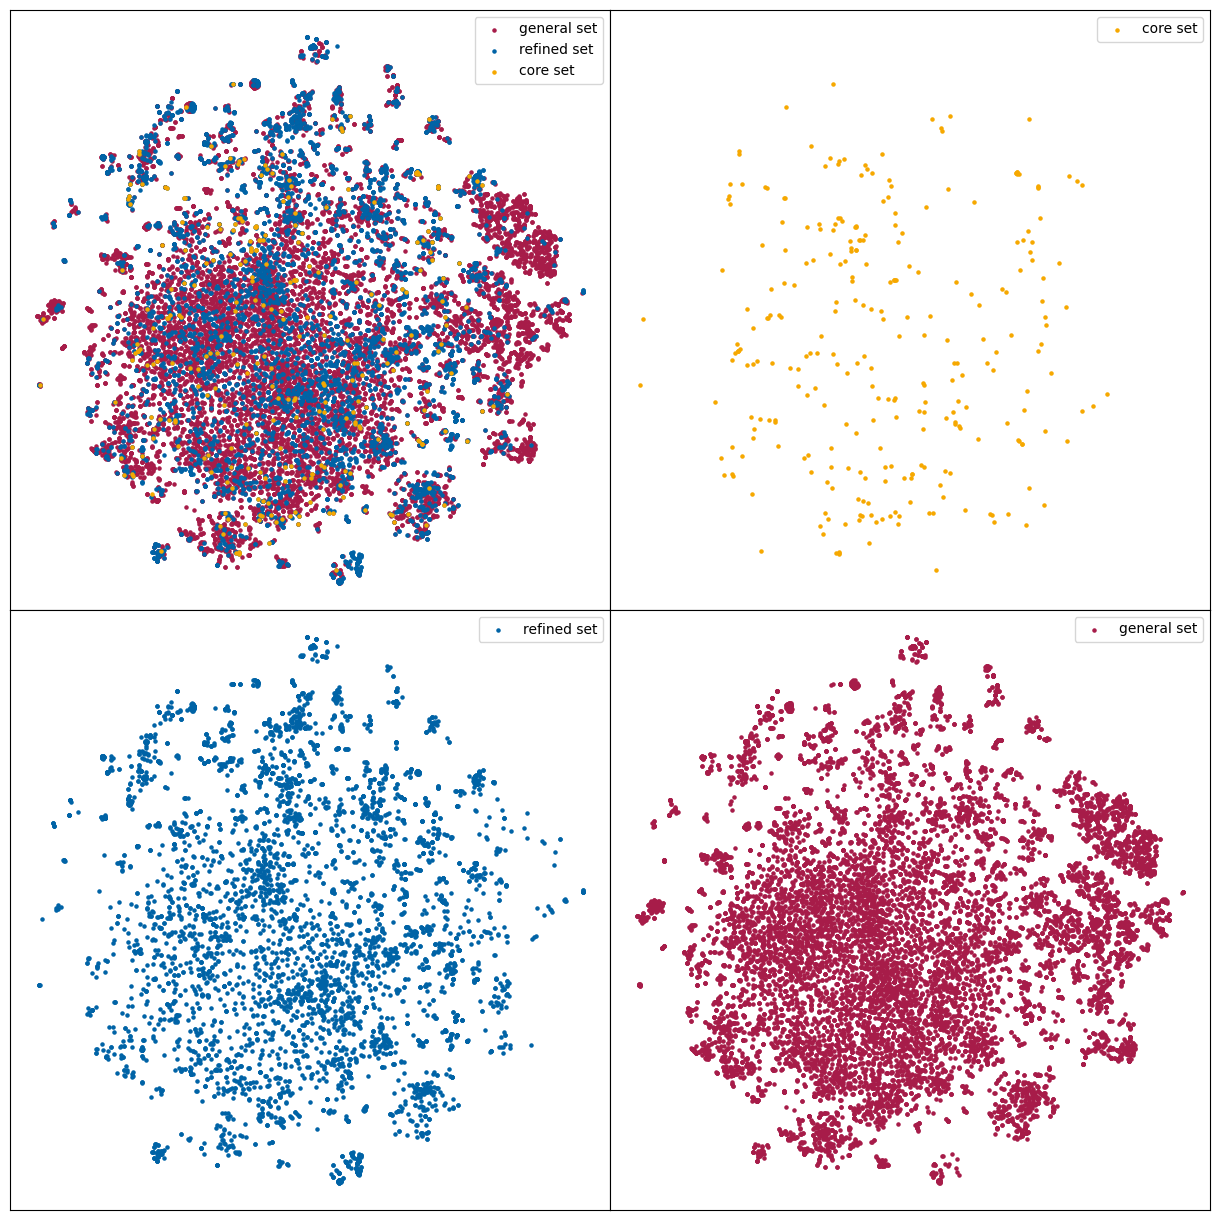

In [40]:
# ECFP descriptors
df = pd.read_csv("../data/Descriptors/ECFPs.csv")
df.drop("PDB code",inplace=True, axis=1)

df.replace("general-set","general set",inplace=True)
df.replace("refined-set","refined set",inplace=True)
df.replace("coreset","core set",inplace=True)

df_general = df[df["Settype"] == "general set"]
df_refined = df[df["Settype"] == "refined set"]
df_core = df[df["Settype"] == "core set"]

df_data = df.drop("Settype",inplace=False,axis=1)
df_refined_data = df[df["Settype"] == "refined set"].drop("Settype",inplace=False,axis=1)

scaler = StandardScaler().fit(df_refined_data)

df_scaled = scaler.transform(df_data)

df_scaled = np.nan_to_num(df_scaled)

pca = PCA(n_components=35)
df_scaled = pca.fit_transform(df_scaled)

print("preprocessing DONE")

reducer = TSNE(n_components=2)
reducer = reducer.fit(df_scaled)
points_all = reducer.fit_transform(df_scaled)
points_general = points_all[df.Settype == "general set"]
points_refined = points_all[df.Settype == "refined set"]
points_core = points_all[df.Settype == "core set"]
print("t-SNE training DONE")

# Plot t-SNE
fig, axs = plt.subplots(2, 2, figsize=(12, 12),sharex=True,sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.0, hspace=0.0, wspace=0.0)

# Plot all points
axs[0, 0].scatter(points_general[:, 0], points_general[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
axs[0, 0].scatter(points_refined[:, 0], points_refined[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
axs[0, 0].scatter(points_core[:, 0], points_core[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
axs[0, 0].legend(loc="best")

# Plot points_core
axs[0, 1].scatter(points_core[:, 0], points_core[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
axs[0, 1].legend(loc="best")

# Plot points_refined
axs[1, 0].scatter(points_refined[:, 0], points_refined[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
axs[1, 0].legend(loc="best")

# Plot points_general
axs[1, 1].scatter(points_general[:, 0], points_general[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
axs[1, 1].legend(loc="best")

for ax in axs:
    for a in ax:
        a.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        
plt.show()

/tmp/ipykernel_1874206/3629485793.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general.drop("Settype",inplace=True, axis=1)
/tmp/ipykernel_1874206/3629485793.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_refined.drop("Settype",inplace=True, axis=1)
/tmp/ipykernel_1874206/3629485793.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_core.drop("Settype",inplace=True, axis=1)


preprocessing DONE
(19728, 2) (8141, 2) (460, 2) (4718, 2) (4915, 2) (772, 2) (295, 2) (426, 2) (1, 2)
t-SNE training DONE


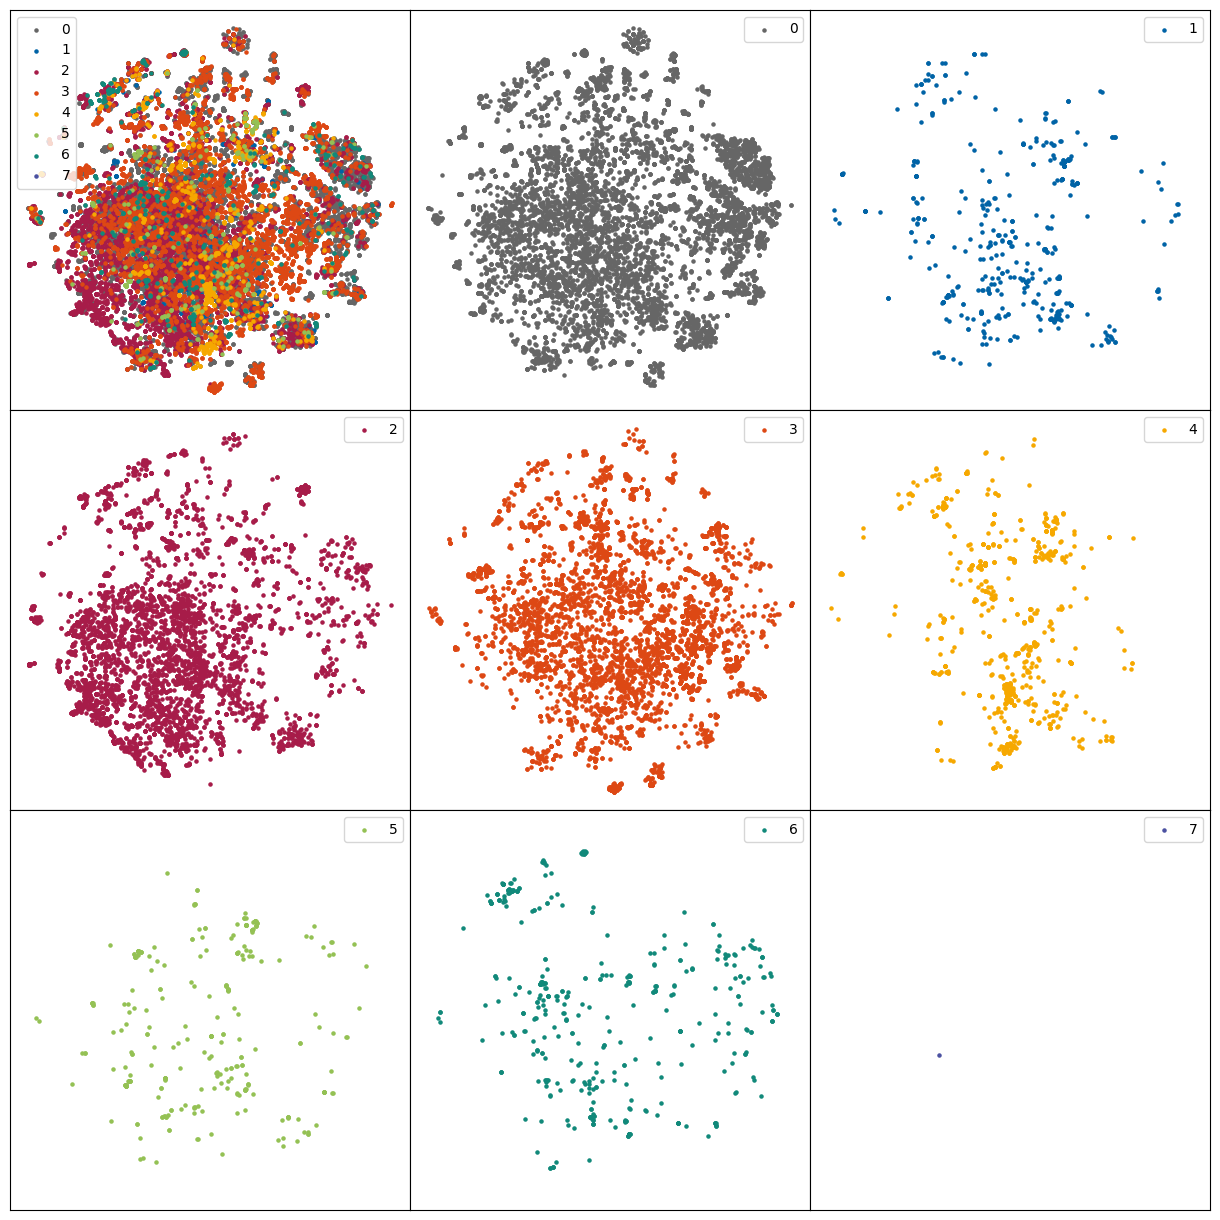

In [41]:
df = pd.read_csv("../data/Descriptors/ECFPs.csv")

df.replace("general-set","general set",inplace=True)
df.replace("refined-set","refined set",inplace=True)
df.replace("coreset","core set",inplace=True)

df_general = df[df["Settype"] == "general set"]
df_refined = df[df["Settype"] == "refined set"]
df_core = df[df["Settype"] == "core set"]

df.drop("Settype",inplace=True, axis=1)
df_general.drop("Settype",inplace=True, axis=1)
df_refined.drop("Settype",inplace=True, axis=1)
df_core.drop("Settype",inplace=True, axis=1)

df_1 = pd.read_csv("../data/exp_data/EC_numbers/1_x_x_x.csv")
df_2 = pd.read_csv("../data/exp_data/EC_numbers/2_x_x_x.csv")
df_3 = pd.read_csv("../data/exp_data/EC_numbers/3_x_x_x.csv")
df_4 = pd.read_csv("../data/exp_data/EC_numbers/4_x_x_x.csv")
df_5 = pd.read_csv("../data/exp_data/EC_numbers/5_x_x_x.csv")
df_6 = pd.read_csv("../data/exp_data/EC_numbers/6_x_x_x.csv")
df_7 = pd.read_csv("../data/exp_data/EC_numbers/7_x_x_x.csv")

lst = []

for pdb in df["PDB code"]:
    if pdb in df_1["PDB code"].values:
        lst.append(1)
    elif pdb in df_2["PDB code"].values:
        lst.append(2)
    elif pdb in df_3["PDB code"].values:
        lst.append(3)
    elif pdb in df_4["PDB code"].values:
        lst.append(4)
    elif pdb in df_5["PDB code"].values:
        lst.append(5)
    elif pdb in df_6["PDB code"].values:
        lst.append(6)
    elif pdb in df_7["PDB code"].values:
        lst.append(7)
    else:
        lst.append(0)

df["Class"] = lst

df.drop("PDB code",inplace=True, axis=1)

df_data = df.drop("Class",inplace=False,axis=1)

df_refined_data = df_refined.drop("PDB code",inplace=False,axis=1)
scaler = StandardScaler().fit(df_refined_data)

df_scaled = scaler.transform(df_data)

df_scaled = np.nan_to_num(df_scaled)

pca = PCA(n_components=35)
df_scaled = pca.fit_transform(df_scaled)

print("preprocessing DONE")

reducer = TSNE(n_components=2)

reducer = reducer.fit(df_scaled)
points_all = reducer.fit_transform(df_scaled)
points_0 = points_all[df.Class == 0]
points_1 = points_all[df.Class == 1]
points_2 = points_all[df.Class == 2]
points_3 = points_all[df.Class == 3]
points_4 = points_all[df.Class == 4]
points_5 = points_all[df.Class == 5]
points_6 = points_all[df.Class == 6]
points_7 = points_all[df.Class == 7]
print(points_all.shape,points_0.shape,points_1.shape,points_2.shape,points_3.shape,points_4.shape,points_5.shape,points_6.shape,points_7.shape)
print("t-SNE training DONE")

# Plot t-SNE
fig, axs = plt.subplots(3, 3, figsize=(12, 12),sharex=True,sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.0, hspace=0.0, wspace=0.0)

# Plot all points
axs[0, 0].scatter(points_0[:, 0], points_0[:, 1], s=5, label="0", color="#666666", alpha=1)
axs[0, 0].scatter(points_1[:, 0], points_1[:, 1], s=5, label="1", color="#0063A6", alpha=1)
axs[0, 0].scatter(points_2[:, 0], points_2[:, 1], s=5, label="2", color="#A71C49", alpha=1)
axs[0, 0].scatter(points_3[:, 0], points_3[:, 1], s=5, label="3", color="#DD4814", alpha=1)
axs[0, 0].scatter(points_4[:, 0], points_4[:, 1], s=5, label="4", color="#F6A800", alpha=1)
axs[0, 0].scatter(points_5[:, 0], points_5[:, 1], s=5, label="5", color="#94C154", alpha=1)
axs[0, 0].scatter(points_6[:, 0], points_6[:, 1], s=5, label="6", color="#11897A", alpha=1)
axs[0, 0].scatter(points_7[:, 0], points_7[:, 1], s=5, label="7", color="#4B51A1", alpha=1)
axs[0, 0].legend(loc="best")

# Plot points_0
axs[0, 1].scatter(points_0[:, 0], points_0[:, 1], s=5, label="0", color="#666666", alpha=1)
axs[0, 1].legend(loc="best")

# Plot points_1
axs[0, 2].scatter(points_1[:, 0], points_1[:, 1], s=5, label="1", color="#0063A6", alpha=1)
axs[0, 2].legend(loc="best")

# Plot points_2
axs[1, 0].scatter(points_2[:, 0], points_2[:, 1], s=5, label="2", color="#A71C49", alpha=1)
axs[1, 0].legend(loc="best")

# Plot points_3
axs[1, 1].scatter(points_3[:, 0], points_3[:, 1], s=5, label="3", color="#DD4814", alpha=1)
axs[1, 1].legend(loc="best")

# Plot points_4
axs[1, 2].scatter(points_4[:, 0], points_4[:, 1], s=5, label="4", color="#F6A800", alpha=1)
axs[1, 2].legend(loc="best")

# Plot points_5
axs[2, 0].scatter(points_5[:, 0], points_5[:, 1], s=5, label="5", color="#94C154", alpha=1)
axs[2, 0].legend(loc="best")

# Plot points_6
axs[2, 1].scatter(points_6[:, 0], points_6[:, 1], s=5, label="6", color="#11897A", alpha=1)
axs[2, 1].legend(loc="best")

# Plot points_7
axs[2, 2].scatter(points_7[:, 0], points_7[:, 1], s=5, label="7", color="#4B51A1", alpha=1)
axs[2, 2].legend(loc="best")

for ax in axs:
    for a in ax:
        a.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        
plt.show()

preprocessing DONE
t-SNE training DONE


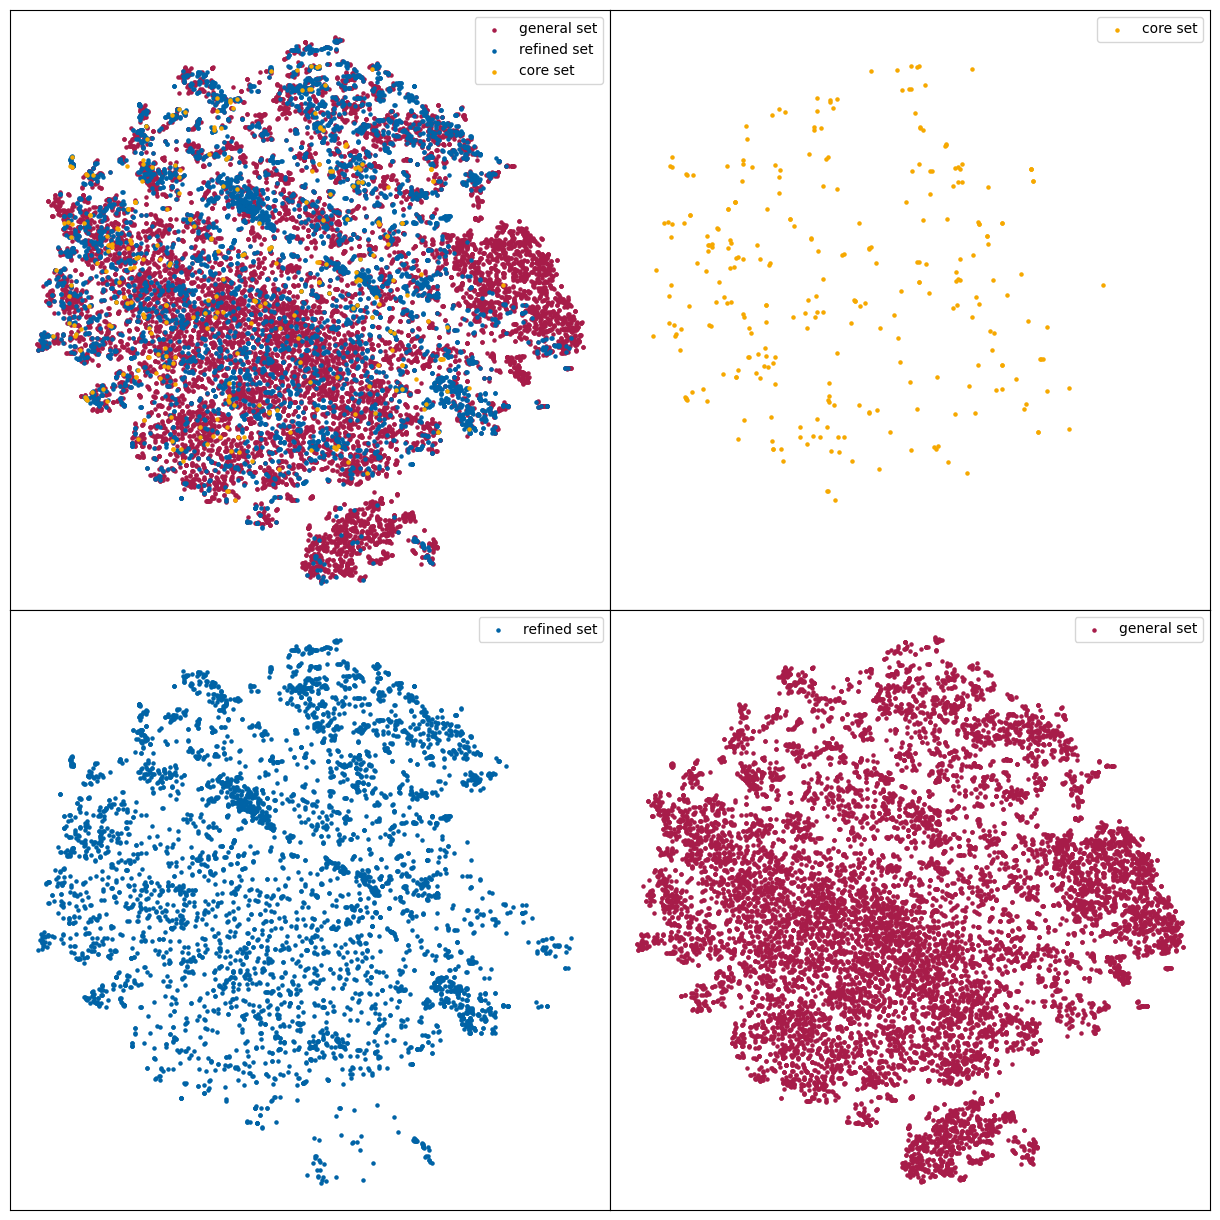

In [42]:
df = pd.read_csv("../data/Descriptors/DXGB.csv")
df.drop("PDB code",inplace=True, axis=1)
df.dropna(inplace=True)

df.replace("general-set","general set",inplace=True)
df.replace("refined-set","refined set",inplace=True)
df.replace("coreset","core set",inplace=True)

df_general = df[df["Settype"] == "general set"]
df_refined = df[df["Settype"] == "refined set"]
df_core = df[df["Settype"] == "core set"]

df_data = df.drop("Settype",inplace=False,axis=1)
df_refined_data = df[df["Settype"] == "refined set"].drop("Settype",inplace=False,axis=1)

scaler = StandardScaler().fit(df_refined_data)

df_scaled = scaler.transform(df_data)

df_scaled = np.nan_to_num(df_scaled)

pca = PCA(n_components=35)
df_scaled = pca.fit_transform(df_scaled)

print("preprocessing DONE")

reducer = TSNE(n_components=2)
reducer = reducer.fit(df_scaled)
points_all = reducer.fit_transform(df_scaled)
points_general = points_all[df.Settype == "general set"]
points_refined = points_all[df.Settype == "refined set"]
points_core = points_all[df.Settype == "core set"]
print("t-SNE training DONE")

# Plot t-SNE
fig, axs = plt.subplots(2, 2, figsize=(12, 12),sharex=True,sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.0, hspace=0.0, wspace=0.0)

# Plot all points
axs[0, 0].scatter(points_general[:, 0], points_general[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
axs[0, 0].scatter(points_refined[:, 0], points_refined[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
axs[0, 0].scatter(points_core[:, 0], points_core[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
axs[0, 0].legend(loc="best")

# Plot points_core
axs[0, 1].scatter(points_core[:, 0], points_core[:, 1], s=5, label="core set", color="#F6A800", alpha=1)
axs[0, 1].legend(loc="best")

# Plot points_refined
axs[1, 0].scatter(points_refined[:, 0], points_refined[:, 1], s=5, label="refined set", color="#0063A6", alpha=1)
axs[1, 0].legend(loc="best")

# Plot points_general
axs[1, 1].scatter(points_general[:, 0], points_general[:, 1], s=5, label="general set", color="#A71C49", alpha=1)
axs[1, 1].legend(loc="best")

for ax in axs:
    for a in ax:
        a.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        
plt.show()

/tmp/ipykernel_1874206/930160326.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general.drop("Settype",inplace=True, axis=1)
/tmp/ipykernel_1874206/930160326.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_refined.drop("Settype",inplace=True, axis=1)
/tmp/ipykernel_1874206/930160326.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_core.drop("Settype",inplace=True, axis=1)


preprocessing DONE
(18904, 2) (7976, 2) (450, 2) (4509, 2) (4550, 2) (726, 2) (291, 2) (401, 2) (1, 2)
t-SNE training DONE


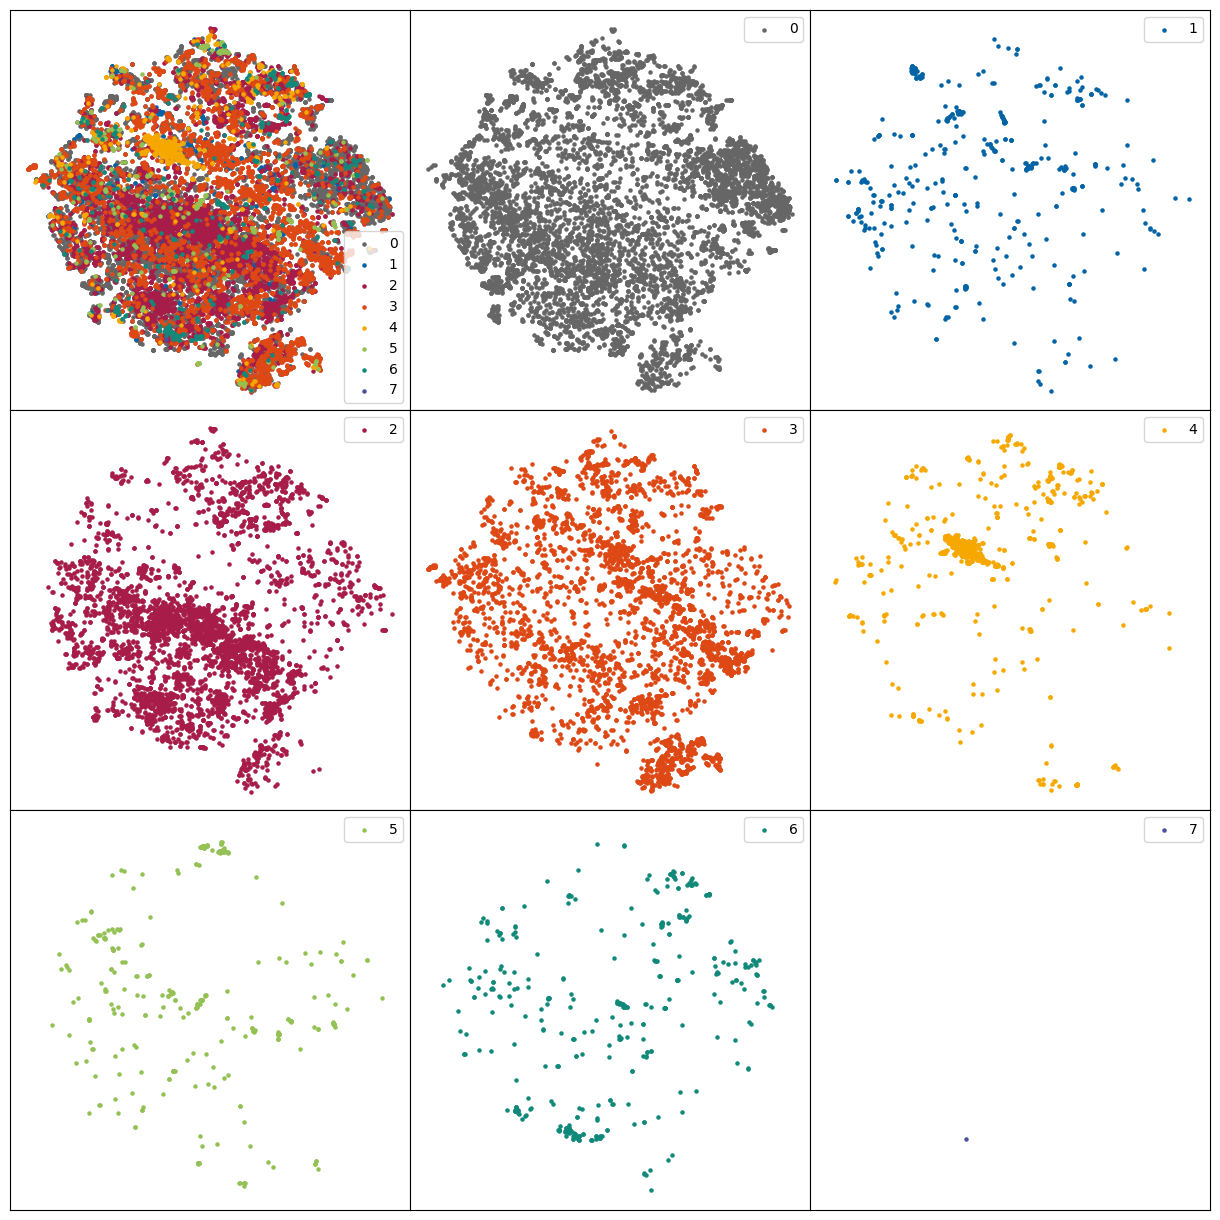

In [43]:
# DXGB descriptors
df = pd.read_csv("../data/Descriptors/DXGB.csv")

df_general = df[df["Settype"] == "general-set"]
df_refined = df[df["Settype"] == "refined-set"]
df_core = df[df["Settype"] == "coreset"]

df.drop("Settype",inplace=True, axis=1)
df_general.drop("Settype",inplace=True, axis=1)
df_refined.drop("Settype",inplace=True, axis=1)
df_core.drop("Settype",inplace=True, axis=1)

df_1 = pd.read_csv("../data/exp_data/EC_numbers/1_x_x_x.csv")
df_2 = pd.read_csv("../data/exp_data/EC_numbers/2_x_x_x.csv")
df_3 = pd.read_csv("../data/exp_data/EC_numbers/3_x_x_x.csv")
df_4 = pd.read_csv("../data/exp_data/EC_numbers/4_x_x_x.csv")
df_5 = pd.read_csv("../data/exp_data/EC_numbers/5_x_x_x.csv")
df_6 = pd.read_csv("../data/exp_data/EC_numbers/6_x_x_x.csv")
df_7 = pd.read_csv("../data/exp_data/EC_numbers/7_x_x_x.csv")

lst = []

for pdb in df["PDB code"]:
    if pdb in df_1["PDB code"].values:
        lst.append(1)
    elif pdb in df_2["PDB code"].values:
        lst.append(2)
    elif pdb in df_3["PDB code"].values:
        lst.append(3)
    elif pdb in df_4["PDB code"].values:
        lst.append(4)
    elif pdb in df_5["PDB code"].values:
        lst.append(5)
    elif pdb in df_6["PDB code"].values:
        lst.append(6)
    elif pdb in df_7["PDB code"].values:
        lst.append(7)
    else:
        lst.append(0)

df["Class"] = lst

df.drop("PDB code",inplace=True, axis=1)

df_data = df.drop("Class",inplace=False,axis=1)

df_refined_data = df_refined.drop("PDB code",inplace=False,axis=1)
scaler = StandardScaler().fit(df_refined_data)

df_scaled = scaler.transform(df_data)

df_scaled = np.nan_to_num(df_scaled)

pca = PCA(n_components=35)
df_scaled = pca.fit_transform(df_scaled)

print("preprocessing DONE")

reducer = TSNE(n_components=2)

reducer = reducer.fit(df_scaled)
points_all = reducer.fit_transform(df_scaled)
points_0 = points_all[df.Class == 0]
points_1 = points_all[df.Class == 1]
points_2 = points_all[df.Class == 2]
points_3 = points_all[df.Class == 3]
points_4 = points_all[df.Class == 4]
points_5 = points_all[df.Class == 5]
points_6 = points_all[df.Class == 6]
points_7 = points_all[df.Class == 7]
print(points_all.shape,points_0.shape,points_1.shape,points_2.shape,points_3.shape,points_4.shape,points_5.shape,points_6.shape,points_7.shape)
print("t-SNE training DONE")

# Plot t-SNE
fig, axs = plt.subplots(3, 3, figsize=(12, 12),sharex=True,sharey=True,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.0, hspace=0.0, wspace=0.0)

# Plot all points
axs[0, 0].scatter(points_0[:, 0], points_0[:, 1], s=5, label="0", color="#666666", alpha=1)
axs[0, 0].scatter(points_1[:, 0], points_1[:, 1], s=5, label="1", color="#0063A6", alpha=1)
axs[0, 0].scatter(points_2[:, 0], points_2[:, 1], s=5, label="2", color="#A71C49", alpha=1)
axs[0, 0].scatter(points_3[:, 0], points_3[:, 1], s=5, label="3", color="#DD4814", alpha=1)
axs[0, 0].scatter(points_4[:, 0], points_4[:, 1], s=5, label="4", color="#F6A800", alpha=1)
axs[0, 0].scatter(points_5[:, 0], points_5[:, 1], s=5, label="5", color="#94C154", alpha=1)
axs[0, 0].scatter(points_6[:, 0], points_6[:, 1], s=5, label="6", color="#11897A", alpha=1)
axs[0, 0].scatter(points_7[:, 0], points_7[:, 1], s=5, label="7", color="#4B51A1", alpha=1)
axs[0, 0].legend(loc="best")

# Plot points_0
axs[0, 1].scatter(points_0[:, 0], points_0[:, 1], s=5, label="0", color="#666666", alpha=1)
axs[0, 1].legend(loc="best")

# Plot points_1
axs[0, 2].scatter(points_1[:, 0], points_1[:, 1], s=5, label="1", color="#0063A6", alpha=1)
axs[0, 2].legend(loc="best")

# Plot points_2
axs[1, 0].scatter(points_2[:, 0], points_2[:, 1], s=5, label="2", color="#A71C49", alpha=1)
axs[1, 0].legend(loc="best")

# Plot points_3
axs[1, 1].scatter(points_3[:, 0], points_3[:, 1], s=5, label="3", color="#DD4814", alpha=1)
axs[1, 1].legend(loc="best")

# Plot points_4
axs[1, 2].scatter(points_4[:, 0], points_4[:, 1], s=5, label="4", color="#F6A800", alpha=1)
axs[1, 2].legend(loc="best")

# Plot points_5
axs[2, 0].scatter(points_5[:, 0], points_5[:, 1], s=5, label="5", color="#94C154", alpha=1)
axs[2, 0].legend(loc="best")

# Plot points_6
axs[2, 1].scatter(points_6[:, 0], points_6[:, 1], s=5, label="6", color="#11897A", alpha=1)
axs[2, 1].legend(loc="best")

# Plot points_7
axs[2, 2].scatter(points_7[:, 0], points_7[:, 1], s=5, label="7", color="#4B51A1", alpha=1)
axs[2, 2].legend(loc="best")

for ax in axs:
    for a in ax:
        a.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        
plt.show()

Preprocessing DONE
t-SNE training DONE


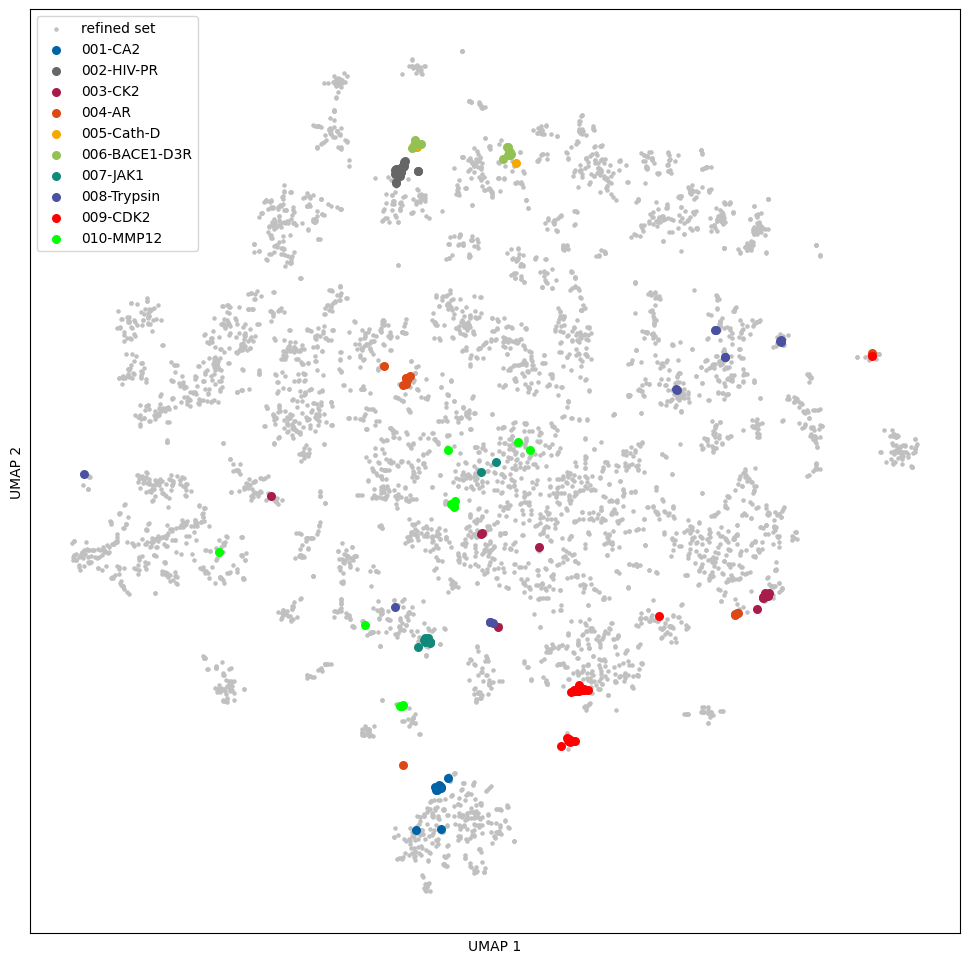

In [44]:
# X-GRADE descriptors
# Load and preprocess data
df_refined = pd.read_csv("../data/Descriptors/PDBbind_refined_set_X-GRADE.csv")
df_refined.drop("PDB code", inplace=True, axis=1)
df_refined["Settype"] = "refined set"

df_001 = pd.read_csv("../data/Descriptors/PL-REX/001-CA2/X-GRADE.csv")
df_001.drop("PDB code", inplace=True, axis=1)
df_001["Settype"] = "001-CA2"

df_002 = pd.read_csv("../data/Descriptors/PL-REX/002-HIV-PR/X-GRADE.csv")
df_002.drop("PDB code", inplace=True, axis=1)
df_002["Settype"] = "002-HIV-PR"

df_003 = pd.read_csv("../data/Descriptors/PL-REX/003-CK2/X-GRADE.csv")
df_003.drop("PDB code", inplace=True, axis=1)
df_003["Settype"] = "003-CK2"

df_004 = pd.read_csv("../data/Descriptors/PL-REX/004-AR/X-GRADE.csv")
df_004.drop("PDB code", inplace=True, axis=1)
df_004["Settype"] = "004-AR"

df_005 = pd.read_csv("../data/Descriptors/PL-REX/005-Cath-D/X-GRADE.csv")
df_005.drop("PDB code", inplace=True, axis=1)
df_005["Settype"] = "005-Cath-D"

df_006 = pd.read_csv("../data/Descriptors/PL-REX/006-BACE1-D3R/X-GRADE.csv")
df_006.drop("PDB code", inplace=True, axis=1)
df_006["Settype"] = "006-BACE1-D3R"

df_007 = pd.read_csv("../data/Descriptors/PL-REX/007-JAK1/X-GRADE.csv")
df_007.drop("PDB code", inplace=True, axis=1)
df_007["Settype"] = "007-JAK1"

df_008 = pd.read_csv("../data/Descriptors/PL-REX/008-Trypsin/X-GRADE.csv")
df_008.drop("PDB code", inplace=True, axis=1)
df_008["Settype"] = "008-Trypsin"

df_009 = pd.read_csv("../data/Descriptors/PL-REX/009-CDK2/X-GRADE.csv")
df_009.drop("PDB code", inplace=True, axis=1)
df_009["Settype"] = "009-CDK2"

df_010 = pd.read_csv("../data/Descriptors/PL-REX/010-MMP12/X-GRADE.csv")
df_010.drop("PDB code", inplace=True, axis=1)
df_010["Settype"] = "010-MMP12"

dataframes = [df_refined, df_001, df_002, df_003, df_004, df_005, df_006, df_007, df_008, df_009, df_010]
df = pd.concat(dataframes)

# Separate data and set type
df_data = df.drop("Settype", inplace=False, axis=1)
df_refined_data = df_refined.drop("Settype", inplace=False, axis=1)

# Standardize the data
scaler = StandardScaler().fit(df_refined_data)
df_scaled = scaler.transform(df_data)
df_scaled = np.nan_to_num(df_scaled)

pca = PCA(n_components=35)
df_scaled = pca.fit_transform(df_scaled)

print("Preprocessing DONE")

# Apply t-SNE
reducer = TSNE(n_components=2)
points_all = reducer.fit_transform(df_scaled)
print("t-SNE training DONE")

# Convert Settype column to a category
df["Settype"] = df["Settype"].astype('category')
categories = df["Settype"].cat.categories
colors = ["#0063A6", "#666666", "#A71C49", "#DD4814", "#F6A800", "#94C154", "#11897A", "#4B51A1", "#FF0000", "#00FF00", "#D3D3D3"]

# Plot t-SNE
plt.figure(figsize=(12, 12))

# Plot refined set in the background
subset_refined = points_all[df["Settype"] == "refined set"]
plt.scatter(subset_refined[:, 0], subset_refined[:, 1], s=5, label="refined set", color="#C0C0C0", alpha=1)

# Plot all other sets on top
for i, category in enumerate(categories):
    if category != "refined set":
        subset = points_all[df["Settype"] == category]
        plt.scatter(subset[:, 0], subset[:, 1], s=30, label=category, color=colors[i], alpha=1)

# plt.title("UMAP projection of the PL-REX dataset in comparison to the PDBbind refined set using X-GRADE descriptors")
plt.xticks([])
plt.yticks([])
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc="best")
plt.show()

Preprocessing DONE
t-SNE training DONE


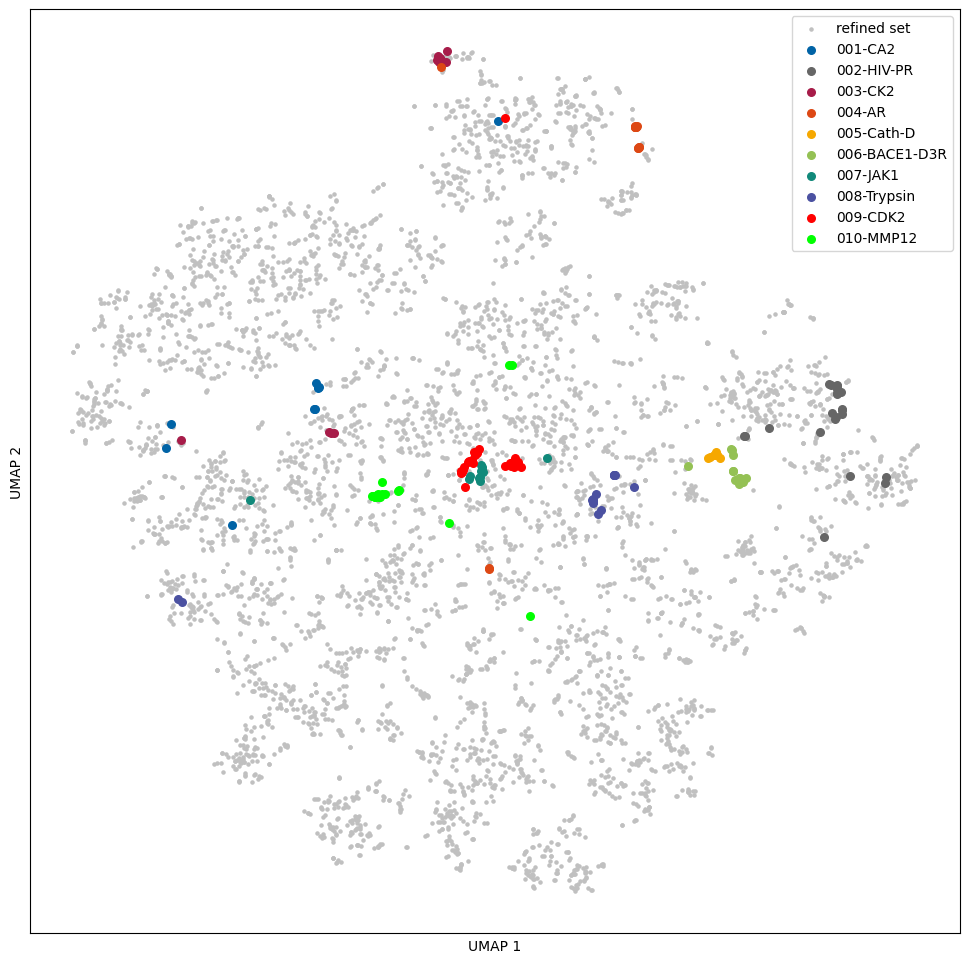

In [45]:
# GRADE descriptors
# Load and preprocess data
df_refined = pd.read_csv("../data/Descriptors/PDBbind_refined_set_GRADE.csv")
df_refined.drop("PDB code", inplace=True, axis=1)
df_refined["Settype"] = "refined set"

df_001 = pd.read_csv("../data/Descriptors/PL-REX/001-CA2/GRADE.csv")
df_001.drop("PDB code", inplace=True, axis=1)
df_001["Settype"] = "001-CA2"

df_002 = pd.read_csv("../data/Descriptors/PL-REX/002-HIV-PR/GRADE.csv")
df_002.drop("PDB code", inplace=True, axis=1)
df_002["Settype"] = "002-HIV-PR"

df_003 = pd.read_csv("../data/Descriptors/PL-REX/003-CK2/GRADE.csv")
df_003.drop("PDB code", inplace=True, axis=1)
df_003["Settype"] = "003-CK2"

df_004 = pd.read_csv("../data/Descriptors/PL-REX/004-AR/GRADE.csv")
df_004.drop("PDB code", inplace=True, axis=1)
df_004["Settype"] = "004-AR"

df_005 = pd.read_csv("../data/Descriptors/PL-REX/005-Cath-D/GRADE.csv")
df_005.drop("PDB code", inplace=True, axis=1)
df_005["Settype"] = "005-Cath-D"

df_006 = pd.read_csv("../data/Descriptors/PL-REX/006-BACE1-D3R/GRADE.csv")
df_006.drop("PDB code", inplace=True, axis=1)
df_006["Settype"] = "006-BACE1-D3R"

df_007 = pd.read_csv("../data/Descriptors/PL-REX/007-JAK1/GRADE.csv")
df_007.drop("PDB code", inplace=True, axis=1)
df_007["Settype"] = "007-JAK1"

df_008 = pd.read_csv("../data/Descriptors/PL-REX/008-Trypsin/GRADE.csv")
df_008.drop("PDB code", inplace=True, axis=1)
df_008["Settype"] = "008-Trypsin"

df_009 = pd.read_csv("../data/Descriptors/PL-REX/009-CDK2/GRADE.csv")
df_009.drop("PDB code", inplace=True, axis=1)
df_009["Settype"] = "009-CDK2"

df_010 = pd.read_csv("../data/Descriptors/PL-REX/010-MMP12/GRADE.csv")
df_010.drop("PDB code", inplace=True, axis=1)
df_010["Settype"] = "010-MMP12"

dataframes = [df_refined, df_001, df_002, df_003, df_004, df_005, df_006, df_007, df_008, df_009, df_010]
df = pd.concat(dataframes)

# Separate data and set type
df_data = df.drop("Settype", inplace=False, axis=1)
df_refined_data = df_refined.drop("Settype", inplace=False, axis=1)

# Standardize the data
scaler = StandardScaler().fit(df_refined_data)
df_scaled = scaler.transform(df_data)
df_scaled = np.nan_to_num(df_scaled)

pca = PCA(n_components=35)
df_scaled = pca.fit_transform(df_scaled)

print("Preprocessing DONE")

# Apply t-SNE
reducer = TSNE(n_components=2)
points_all = reducer.fit_transform(df_scaled)
print("t-SNE training DONE")

# Convert Settype column to a category
df["Settype"] = df["Settype"].astype('category')
categories = df["Settype"].cat.categories
colors = ["#0063A6", "#666666", "#A71C49", "#DD4814", "#F6A800", "#94C154", "#11897A", "#4B51A1", "#FF0000", "#00FF00", "#D3D3D3"]

# Plot t-SNE
plt.figure(figsize=(12, 12))

# Plot refined set in the background
subset_refined = points_all[df["Settype"] == "refined set"]
plt.scatter(subset_refined[:, 0], subset_refined[:, 1], s=5, label="refined set", color="#C0C0C0", alpha=1)

# Plot all other sets on top
for i, category in enumerate(categories):
    if category != "refined set":
        subset = points_all[df["Settype"] == category]
        plt.scatter(subset[:, 0], subset[:, 1], s=30, label=category, color=colors[i], alpha=1)

# plt.title("UMAP projection of the PL-REX dataset in comparison to the PDBbind refined set using X-GRADE descriptors")
plt.xticks([])
plt.yticks([])
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc="best")
plt.show()


Explained Variance Ratio: 0.9999999999999999
Explained Variance Ratio: 1.0000000000000002
Explained Variance Ratio: 0.9984561816880437


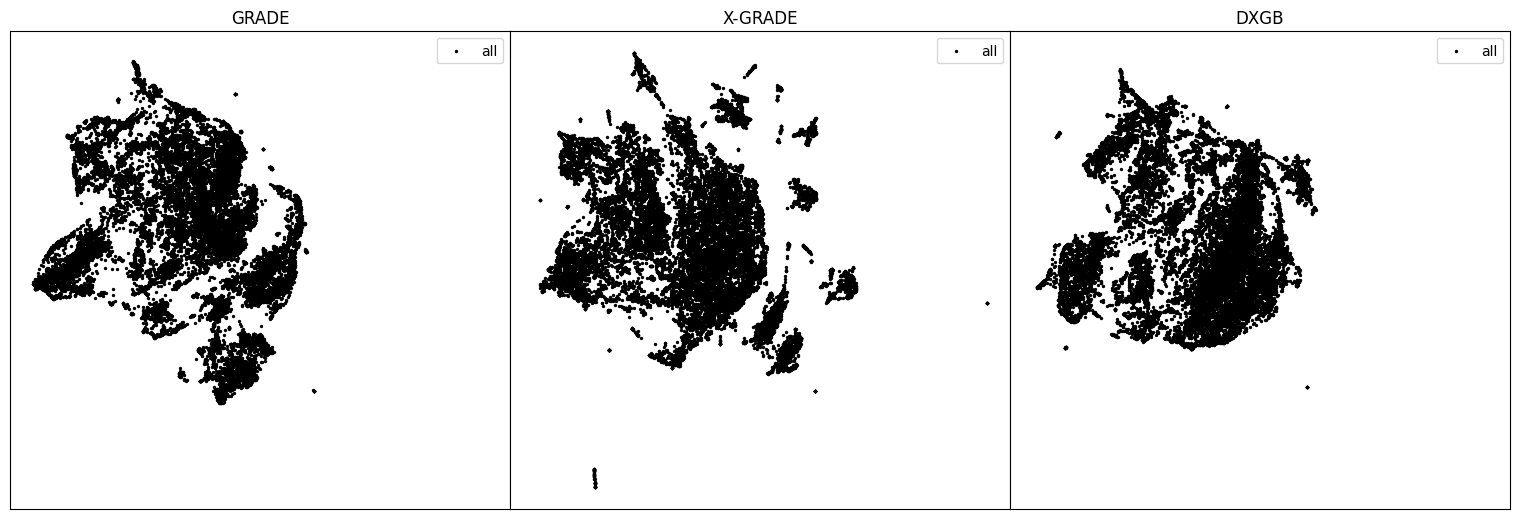